<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/Carrefour/Carrefour_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "CAFREUR"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-27 17:23:31,589 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-27 17:23:31,592 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for CAFREUR
2019-08-27 17:26:55,874 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-27 17:33:43,221 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-27 17:37:17,601 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-27 17:40:46,750 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-27 17:44:20,091 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-27 17:47:45,117 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-27 17:51:17,982 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-27 17:54:34,789 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-3

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-27 18:04:54,839 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_439__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_CAFREUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-CAFREUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-CAFREUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  0.18032  0.18158  0.18027  0.18068  2.017995
2018-01-02 09:00:00  0.18073  0.18078  0.18002  0.18037  2.046268
2018-01-02 10:00:00  0.18042  0.18072  0.17968  0.17968  1.376857
2018-01-02 11:00:00  0.17972  0.18008  0.17942  0.17982  0.888680
2018-01-02 12:00:00  0.17983  0.18033  0.17962  0.18033  1.036006
...                      ...      ...      ...      ...       ...
2018-12-31 08:00:00  0.14898  0.14977  0.14837  0.14973  0.492554
2018-12-31 09:00:00  0.14973  0.14983  0.14903  0.14923  0.455768
2018-12-31 10:00:00  0.14928  0.14943  0.14822  0.14862  0.413110
2018-12-31 11:00:00  0.14862  0.14913  0.14837  0.14893  0.431994
2018-12-31 12:00:00  0.14893  0.14907  0.14688  0.14872  0.326100

[2279 rows x 5 columns]

Open         High          Low        Close       Volume
count  2279.000000  2279.000000  2279.000000  2279.000000  2279.000000
mean      0.163480     0.164003     0.162983     0.163486     2.113185
std       0.014464     0.014500     0.014438     0.014467     1.710977
min       0.130630     0.130830     0.129470     0.130620     0.000020
25%       0.153470     0.153930     0.153025     0.153500     1.268008
50%       0.164170     0.164630     0.163770     0.164220     1.776380
75%       0.172225     0.172930     0.171795     0.172180     2.425075
max       0.196620     0.197280     0.196270     0.196630    34.705429

25

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2018-01-09 13:00:00  0.17923  0.17978  0.17917  0.17948  1.606659    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.179893  0.180000 -0.180278  0.179285  0.179738  0.179683    0.179870    0.179825  0.181166  0.179612  0.179497  0.179733  0.179635  0.179612  0.179540  0.180857                0.180581                 0.179612                0.178644                0.181065                 0.179612                0.178160                0.181549                 0.179612                0.177676                0.182033                 0.179612                0.177192  0.179738  0.179522  0.180633                0.180706                 0.179738                0.178770                0.181191                 0.179738                0.178286                0.181675                 0.179738                0.177802                0.182159                 0.179738   
2018-01-09 14:00:00  0.17947  0.17958  0.17807  0.17808  4.947267    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.179802  0.179995 -0.180046  0.178730  0.179370  0.179625    0.179375    0.179550  0.180962  0.179488  0.178751  0.179643  0.179294  0.179488  0.178780  0.180669                0.180869                 0.179488                0.178106                0.181559                 0.179488                0.177416                0.182250                 0.179488                0.176725                0.182940                 0.179488                0.176035  0.179370  0.178547  0.180451                0.180751                 0.179370                0.177989                0.181441                 0.179370                0.177298                0.182132                 0.179370                0.176607                0.182822                 0.179370   
2018-01-09 15:00:00  0.17812  0.17843  0.17752  0.17812 

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month        hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000    2229.000000  2229.00000   2229.000000     2229.000000     2229.000000       2229.000000  2229.000000  2229.000000  2229.000000  2229.000000   2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000             2229.000000              2229.000000             2229.000000             2229.000000              2229.000000             2229.000000             2229.000000              2229.000000             2229.000000             2229.000000              2229.000000             2229.000000  2229.000000  2229.000000  2229.000000             2229.000000              2229.000000             2229.000000             2229.000000              2229.000000             2229.000000             2229.000000   
mean      0.163072     0.163595     0.162573     0.163078     2.123110    15.993719     2.018394   185.571108      30.424406    11.37057      0.033647        0.023777        0.002243          0.004038     6.602064     2.535218    26.962315     2.018394      2.005384    26.962315     0.163133     0.163263    -0.006017     0.163077     0.163127     0.163086     0.163110     0.163122     0.163190     0.163126     0.163079     0.163126     0.163110     0.163126     0.163083     0.163229                0.164777                 0.163126                0.161476                0.165602                 0.163126                0.160651                0.166427                 0.163126                0.159826                0.167252                 0.163126                0.159001     0.163127     0.163087     0.163212                0.164777                 0.163127                0.161477                0.165602                 0.163127                0.160651                0.166427   
std       0.014360     0.014398     0.014331     0.014365     1.725332     8.579910     1.412983   101.940922       0.853894     2.62103      0.180360        0.152389        0.047319          0.063429     3.354037     1.103789    14.563931     1.412983      1.404650    14.563931     0.014327     0.014237     0.163603     0.014382     0.014308     0.014334     0.014318     0.014331     0.014376     0.014328     0.014372     0.014337     0.014333     0.014328     0.014357     0.014263                0.014430                 0.014328                0.014363                0.014532                 0.014328                0.014433                0.014667                 0.014328                0.014535                0.014833                 0.014328                0.014671     0.014308     0.014350     0.014273                0.014414                 0.014308                0.014340                0.014518                 0.014308                0.014408                0.014654   
min       0.130630     0.130830     0.129470  

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.736475  0.736644  0.744012  0.740191  0.046294    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.751277  0.762243  0.043366  0.737295  0.747381  0.744442    0.747816    0.749810  0.762368  0.744670  0.741426  0.746779  0.745047  0.744670  0.742397  0.770745                0.710652                 0.744670                0.742370                0.671372                 0.744670                0.753943                0.635290                 0.744670                0.770425                0.602231                 0.744670                0.785255  0.747381  0.742523  0.765838                0.705293                 0.747381                0.746620                0.664186                 0.747381                0.750570                0.627859                 0.747381                0.766359                0.595526                 0.747381   
2018-01-09 14:00:00  0.740112  0.733634  0.727545  0.718982  0.142550    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.749887  0.762165  0.043958  0.728938  0.741722  0.743539    0.740230    0.745621  0.759364  0.742756  0.730081  0.745402  0.739844  0.742756  0.730839  0.767775                0.714828                 0.742756                0.734363                0.678120                 0.742756                0.743551                0.644310                 0.742756                0.758259                0.613259                 0.742756                0.771646  0.741722  0.727694  0.762985                0.705933                 0.741722                0.735031                0.667579                 0.741722                0.736411                0.633685                 0.741722                0.750613                0.603517                 0.741722   
2018-01-09 15:00:00  0.719654  0.716328  

52

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         4 hours 24 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 8 days
H2O cluster name:           H2O_from_python_unknownUser_zdpznr
H2O cluster total nodes:    1
H2O cluster free memory:    8.46 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_181456_mod...  0.571102  0.692895              0.496000  0.499874  0.249874
1  DeepLearning_grid_1_AutoML_20190827_181456_mod...  0.569878  0.814955              0.488000  0.547613  0.299880
2              DeepLearning_1_AutoML_20190827_181456  0.534122  0.715262              0.492000  0.506093  0.256130
3  DeepLearning_grid_1_AutoML_20190827_181456_mod...  0.530612  0.707262              0.500000  0.506605  0.256649
4  DeepLearning_grid_1_AutoML_20190827_181456_mod...  0.525347  3.022948              0.480000  0.683469  0.467129
5  DeepLearning_grid_1_AutoML_20190827_181456_mod...  0.518939  0.696851              0.496000  0.501844  0.251847
6  DeepLearning_grid_1_AutoML_20190827_181456_mod...  0.500000  0.691330              0.500000  0.499091  0.249092
7  DeepLearning_grid_1_AutoML_20190827_181456_mod...  0.474449  1.199259              0.496000  0.638230  0.407337
8  DeepLearning_grid_1_AutoML_20190827_181456_mod...  0.465551  0.704495              0.493102  0.505422  0.255452
9  DeepLearning_grid_1_AutoML_20190827_181456_mod...  0.450449  1.201396              0.500000  0.614957  0.378172

variable  relative_importance  scaled_importance  percentage
0                    CORREL_30             1.000000           1.000000    0.001097
1                 aroondown_14             0.999928           0.999928    0.001097
2                         DX_8             0.991122           0.991122    0.001088
3                 aroondown_12             0.988441           0.988441    0.001085
4                   aroonup_24             0.986110           0.986110    0.001082
...                        ...                  ...                ...         ...
1029  BBANDS_middleband_14_2_5             0.805505           0.805505    0.000884
1030                    SMA_14             0.803793           0.803793    0.000882
1031            CDLHARAMICROSS             0.802286           0.802286    0.000880
1032                    SUM_20             0.802021           0.802021    0.000880
1033   BBANDS_upperband_12_2_2             0.794134           0.794134    0.000871

[1034 rows x 4 columns]

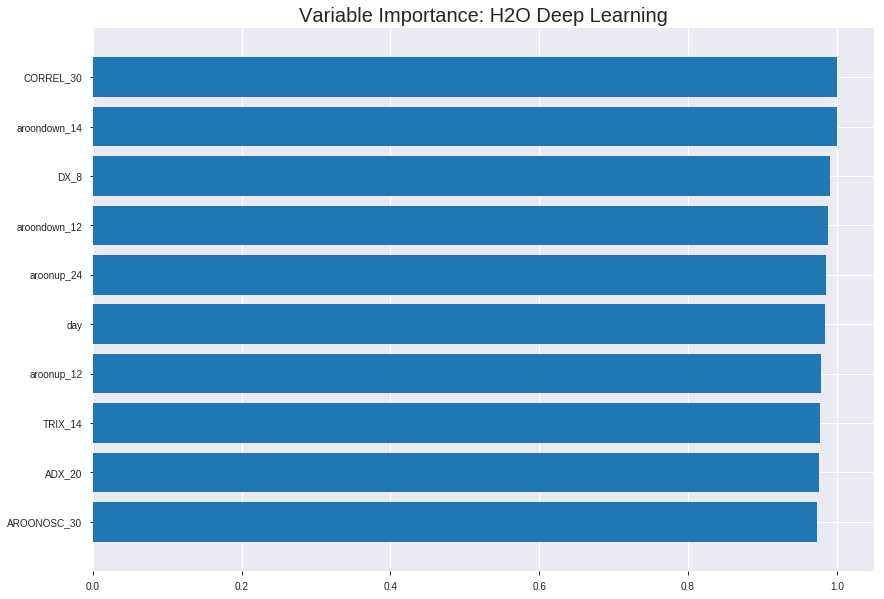

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_181456_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24955927707774114
RMSE: 0.49955908266964894
LogLoss: 0.6922648013079498
Mean Per-Class Error: 0.47066614205894264
AUC: 0.5230138713745272
pr_auc: 0.5166334432107802
Gini: 0.0460277427490543
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4700863192394741: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      7    786   0.9912   (786.0/793.0)
1      0    766   0        (0.0/766.0)
Total  7    1552  0.5042   (786.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.470086     0.660915   392
max f2                       0.470086     0.829723   392
max f0point5                 0.482548     0.556256   337
max accuracy                 0.487922     0.524054   298
max precision                0.528197     1          0
max recall                   0.470086     1          392
max specificity              0.528197     1          0
max absolute_mcc             0.482548     0.0860654  337
max min_per_class_accuracy   0.502512     0.51198    185
max mean_per_class_accuracy  0.487922     0.529334   298

Gains/Lift Table: Avg response rate: 49.13 %, avg score: 50.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.525076           1.52644   1.52644            0.75             0.526271  0.75                        0.526271            0.0156658       0.0156658                  52.6436   52.6436
    2        0.020526                    0.523834           1.14483   1.33563            0.5625           0.524463  0.65625                     0.525367            0.0117493       0.0274151                  14.4827   33.5632
    3        0.0301475                   0.523046           1.22115   1.29909            0.6              0.523457  0.638298                    0.524757            0.0117493       0.0391645                  22.1149   29.9094
    4        0.0404105                   0.521907           0.890421  1.1953             0.4375           0.522532  0.587302                    0.524192            0.00913838      0.0483029                  -10.9579  19.5304
    5        0.0500321                   0.520964           1.22115   1.20027            0.6              0.521362  0.589744                    0.523648            0.0117493       0.0600522                  22.1149   20.0274
    6        0.100064                    0.517776           0.965438  1.08286            0.474359         0.519262  0.532051                    0.521455            0.0483029       0.108355                   -3.45618  8.28563
    7        0.150096                    0.515725           0.887159  1.01762            0.435897         0.516798  0.5                         0.519903            0.0443864       0.152742                   -11.2841  1.7624
    8        0.200128                    0.513434           1.14809   1.05024            0.564103         0.514407  0.516026                    0.518529            0.0574413       0.210183                   14.8089   5.02402
    9        0.300192                    0.507628           1.01762   1.03937            0.5              0.510382  0.510684                    0.515813            0.101828        0.31201                    1.7624    3.93681
    10       0.400257                    0.504914           0.978485  1.02415            0.480769         0.506257  0.503205                    0.513424            0.0979112       0.409922                   -2.15154  2.41473
    11       0.500321                    0.502509           1.04372   1.02806            0.512821         0.503712  0.505128                    0.511482            0.104439        0.51436                    4.37169   2.80612
    12       0.599743                    0.499249           0.919144  1.01001            0.451613         0.501119  0.496257                    0.509764            0.0913838       0.605744                   -8.08557  1.00054
    13       0.699808                    0.493252           1.122     1.02602            0.551282         0.495937  0.504125                    0.507787            0.112272        0.718016                   12.1996   2.60187
    14       0.799872                    0.488128           1.10895   1.03639            0.544872         0.491069  0.509222                    0.505695            0.110966        0.828982                   10.8949   3.63933
    15       0.899936                    0.482091           0.952392  1.02705            0.467949         0.485317  0.504633                    0.503429            0.0953003       0.924282                   -4.76083  2.70532
    16       1                           0.465499           0.756695  1                  0.371795         0.478182  0.491341                    0.500903          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24979074383342284
RMSE: 0.49979070002694415
LogLoss: 0.6927282598166209
Mean Per-Class Error: 0.4565637065637066
AUC: 0.5259009009009009
pr_auc: 0.5314281776387069
Gini: 0.05180180180180183
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4790135716060715: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      11   211  0.9505   (211.0/222.0)
1      2    222  0.0089   (2.0/224.0)
Total  13   433  0.4776   (213.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479014     0.675799  386
max f2                       0.475628     0.836445  396
max f0point5                 0.479014     0.567485  386
max accuracy                 0.493481     0.542601  127
max precision                0.504845     1         0
max recall                   0.475628     1         396
max specificity              0.504845     1         0
max absolute_mcc             0.479014     0.120736  386
max min_per_class_accuracy   0.490819     0.513393  197
max mean_per_class_accuracy  0.493481     0.543436  127

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 49.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.503157           1.19464   1.19464            0.6              0.504027  0.6                         0.504027            0.0133929       0.0133929                  19.4643    19.4643
    2        0.0201794                   0.502347           1.4933    1.32738            0.75             0.502747  0.666667                    0.503458            0.0133929       0.0267857                  49.3304    32.7381
    3        0.0313901                   0.501902           1.59286   1.42219            0.8              0.502192  0.714286                    0.503006            0.0178571       0.0446429                  59.2857    42.2194
    4        0.0403587                   0.500959           0         1.10615            0                0.501529  0.555556                    0.502678            0               0.0446429                  -100       10.6151
    5        0.0515695                   0.500703           1.19464   1.12539            0.6              0.500855  0.565217                    0.502281            0.0133929       0.0580357                  19.4643    12.5388
    6        0.100897                    0.497738           1.26705   1.19464            0.636364         0.49937   0.6                         0.500858            0.0625          0.120536                   26.7045    19.4643
    7        0.150224                    0.4965             0.814529  1.06983            0.409091         0.497056  0.537313                    0.49961             0.0401786       0.160714                   -18.5471   6.98294
    8        0.201794                    0.495456           1.29852   1.12827            0.652174         0.496003  0.566667                    0.498688            0.0669643       0.227679                   29.8525    12.8274
    9        0.300448                    0.493703           1.08604   1.11441            0.545455         0.494311  0.559701                    0.497251            0.107143        0.334821                   8.6039     11.4406
    10       0.401345                    0.492022           0.973413  1.07896            0.488889         0.492899  0.541899                    0.496157            0.0982143       0.433036                   -2.65873   7.89605
    11       0.5                         0.490625           0.814529  1.02679            0.409091         0.491214  0.515695                    0.495181            0.0803571       0.513393                   -18.5471   2.67857
    12       0.600897                    0.48902            0.840675  0.995536           0.422222         0.489851  0.5                         0.494286            0.0848214       0.598214                   -15.9325   -0.446429
    13       0.699552                    0.487293           0.995536  0.995536           0.5              0.488063  0.5                         0.493409            0.0982143       0.696429                   -0.446429  -0.446429
    14       0.800448                    0.485537           0.973413  0.992747           0.488889         0.486483  0.498599                    0.492536            0.0982143       0.794643                   -2.65873   -0.72529
    15       0.899103                    0.483589           1.3123    1.02781            0.659091         0.484481  0.516209                    0.491652            0.129464        0.924107                   31.2297    2.78099
    16       1                           0.469768           0.752183  1                  0.377778         0.48028   0.502242               


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:36:13  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 18:36:15  6 min 30.284 sec   203 obs/sec       0.297627  1             464        0.693716         3.09086             -0.925547      0.521061        0.459725           0.508812         0.501604                         0.678377           2.08152               -0.840821        0.49084           0.488815             0.796429           0.493274
    2019-08-27 18:37:06  7 min 23.121 sec   199 obs/sec       6.18409   20            9641       0.499559         0.692265            0.00146339     0.523014        0.516633           1.52644          0.504169                         0.499791           0.692728              0.000816932      0.525901          0.531428             1.19464            0.477578
    2019-08-27 18:38:15  8 min 30.218 sec   218 obs/sec       15.4766   50            24128      0.501523         0.696206            -0.00640467    0.475299        0.472297           0.508812         0.508659                         0.500672           0.694492              -0.00270888      0.47801           0.483101             0.398214           0.497758
    2019-08-27 18:39:03  9 min 18.403 sec   231 obs/sec       22.8531   74            35628      0.49976          0.69266             0.000661832    0.50942         0.0609422          1.00936          0.502886                         0.501028           0.695213              -0.00413512      0.509401          0.438565             1.02197            0.495516
    2019-08-27 18:39:51  10 min  5.829 sec  246 obs/sec       31.0558   101           48416      0.501301         0.695718            -0.00551298    0.535441        0.225535           1.05873          0.497114                         0.504762           0.702875              -0.0191589       0.497899          0.342823             0.981709           0.495516
    2019-08-27 18:40:39  10 min 54.460 sec  260 obs/sec       40.238    131           62731      0.498216         0.689242            0.00682581     0.525533        0.525775           1.65364          0.497755                         0.50342            0.700978              -0.0137484       0.496742          0.50505              0.796429           0.495516
    2019-08-27 18:41:28  11 min 42.592 sec  278 obs/sec       50.6697   165           78994      0.497475         0.6873              0.00977779     0.539366        0.591044           1.05976          0.494548                         0.506482           0.712136              -0.0261175       0.505088          0.583538             1.00917            0.495516
    2019-08-27 18:41:32  11 min 47.445 sec  277 obs/sec       50.6697   165           78994      0.499559         0.692265            0.00146339     0.523014        0.516633           1.52644          0.504169                         0.499791           0.692728              0.000816932      0.525901          0.531428             1.19464            0.477578

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CORREL_30                 1.0                    1.0                  0.0010973128006738454
aroondown_14              0.9999282956123352     0.9999282956123352   0.0010972341185313964
DX_8                      0.9911224842071533     0.9911224842071533   0.0010875713889561705
aroondown_12              0.9884411692619324     0.9884411692619324   0.0010846291477441415
aroonup_24                0.986110270023346      0.986110270023346    0.0010820714221725597
---                       ---                    ---                  ---
BBANDS_middleband_14_2_5  0.8055048584938049     0.8055048584938049   0.0008838907922302266
SMA_14                    0.8037933111190796     0.8037933111190796   0.0008820126893869807
CDLHARAMICROSS            0.8022858500480652     0.8022858500480652   0.0008803585330572391
SUM_20                    0.8020207285881042     0.8020207285881042   0.0008800676118854906
BBANDS_upperband_12_2_2   0.7941341400146484     0.7941341400146484   0.0008714135572901895


See the whole table with table.as_data_frame()


('accuracy', 0.6053811659192825)

('F1', 0.6125)

('auc', 0.5711020408163265)

('logloss', 0.692895419293447)

('mean_per_class_error', 0.4215918367346938)

('rmse', 0.49987399599455956)

('mse', 0.24987401187156894)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


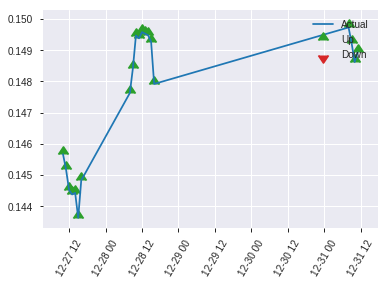


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24987401187156894
RMSE: 0.49987399599455956
LogLoss: 0.692895419293447
Mean Per-Class Error: 0.4215918367346938
AUC: 0.5711020408163265
pr_auc: 0.5191660446986343
Gini: 0.14220408163265308
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46663295864923027: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    124  0.992    (124.0/125.0)
1      0    98   0        (0.0/98.0)
Total  1    222  0.5561   (124.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.466633     0.6125    221
max f2                       0.466633     0.798046  221
max f0point5                 0.506447     0.528302  107
max accuracy                 0.51065      0.605381  41
max precision                0.512626     1         0
max recall                   0.466633     1         221
max specificity              0.512626     1         0
max absolute_mcc             0.511706     0.18056   13
max min_per_class_accuracy   0.506447     0.571429  107
max mean_per_class_accuracy  0.507177     0.578408  100

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 50.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.51206            1.51701   1.51701            0.666667         0.512288  0.666667                    0.512288            0.0204082       0.0204082                  51.7007   51.7007
    2        0.0224215                   0.512018           1.13776   1.36531            0.5              0.512038  0.6                         0.512188            0.0102041       0.0306122                  13.7755   36.5306
    3        0.0313901                   0.511919           2.27551   1.62536            1                0.51199   0.714286                    0.512131            0.0204082       0.0510204                  127.551   62.5364
    4        0.0403587                   0.511859           1.13776   1.51701            0.5              0.511886  0.666667                    0.512077            0.0102041       0.0612245                  13.7755   51.7007
    5        0.0538117                   0.511765           2.27551   1.70663            1                0.511821  0.75                        0.512013            0.0306122       0.0918367                  127.551   70.6633
    6        0.103139                    0.511292           1.03432   1.38509            0.454545         0.511475  0.608696                    0.511755            0.0510204       0.142857                   3.43228   38.5093
    7        0.152466                    0.510914           1.03432   1.27161            0.454545         0.511062  0.558824                    0.511531            0.0510204       0.193878                   3.43228   27.1609
    8        0.201794                    0.510553           1.44805   1.31474            0.636364         0.510728  0.577778                    0.511335            0.0714286       0.265306                   44.8052   31.4739
    9        0.300448                    0.509174           0.930891  1.1887             0.409091         0.509842  0.522388                    0.510845            0.0918367       0.357143                   -6.91095  18.8699
    10       0.399103                    0.507732           1.13776   1.17611            0.5              0.508539  0.516854                    0.510275            0.112245        0.469388                   13.7755   17.6106
    11       0.502242                    0.506047           0.989352  1.13776            0.434783         0.507019  0.5                         0.509606            0.102041        0.571429                   -1.06477  13.7755
    12       0.600897                    0.504194           0.620594  1.05285            0.272727         0.505448  0.462687                    0.508923            0.0612245       0.632653                   -37.9406  5.2848
    13       0.699552                    0.4974             1.03432   1.05024            0.454545         0.500908  0.461538                    0.507793            0.102041        0.734694                   3.43228   5.02355
    14       0.798206                    0.494269           0.724026  1.00992            0.318182         0.49599   0.44382                     0.506334            0.0714286       0.806122                   -27.5974  0.991745
    15       0.896861                    0.488935           0.827458  0.989847           0.363636         0.491625  0.435                       0.504716            0.0816327       0.887755                   -17.2542  -1.01531
    16       1                           0.464454           1.08829   1                  0.478261         0.478122  0.439462                    0.501973        

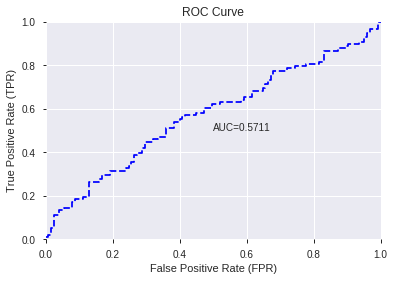

This function is available for GLM models only


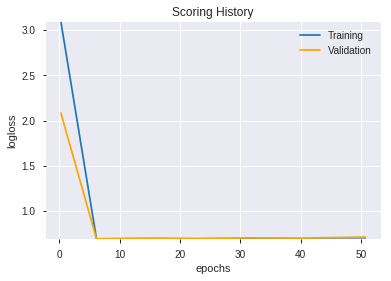

--2019-08-27 18:41:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.86.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.86.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_181456_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_181456_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_85f7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_184151_model_8  0.557184  0.691029              0.464408  0.498940  0.248941
1  DeepLearning_grid_1_AutoML_20190827_184151_model_2  0.554857  0.869269              0.492000  0.536372  0.287695
2  DeepLearning_grid_1_AutoML_20190827_184151_model_5  0.550857  0.704160              0.500000  0.504431  0.254451
3               DeepLearning_1_AutoML_20190827_184151  0.550694  0.855641              0.492000  0.541858  0.293610
4  DeepLearning_grid_1_AutoML_20190827_184151_model_3  0.537469  0.850461              0.488000  0.532030  0.283056
5  DeepLearning_grid_1_AutoML_20190827_184151_model_4  0.526122  0.947258              0.441918  0.571672  0.326809
6  DeepLearning_grid_1_AutoML_20190827_184151_model_9  0.514612  0.693620              0.492000  0.500237  0.250237
7  DeepLearning_grid_1_AutoML_20190827_184151_model_6  0.508327  0.692140              0.493102  0.499487  0.249487
8  DeepLearning_grid_1_AutoML_20190827_184151_model_1  0.497796  1.034931              0.477102  0.584640  0.341804
9  DeepLearning_grid_1_AutoML_20190827_184151_model_7  0.461388  1.099355              0.500000  0.621211  0.385904

variable  relative_importance  scaled_importance  percentage
0                      week             1.000000           1.000000    0.022376
1                      hour             0.992205           0.992205    0.022202
2   BBANDS_lowerband_14_6_3             0.991409           0.991409    0.022184
3                 aroonup_8             0.965642           0.965642    0.021607
4              weekday_name             0.962828           0.962828    0.021544
5                       day             0.960684           0.960684    0.021496
6              aroondown_20             0.957745           0.957745    0.021431
7                aroonup_12             0.951138           0.951138    0.021283
8         LINEARREG_ANGLE_8             0.948260           0.948260    0.021218
9                    ULTOSC             0.934435           0.934435    0.020909
10               aroonup_30             0.933571           0.933571    0.020890
11                  ADXR_12             0.929594           0.929594    0.020801
12             aroondown_12             0.928409           0.928409    0.020774
13                dayofyear             0.927286           0.927286    0.020749
14                 WILLR_12             0.925864           0.925864    0.020717
15               aroonup_24             0.914724           0.914724    0.020468
16                   ADX_20             0.912058           0.912058    0.020408
17                  NATR_24             0.908489           0.908489    0.020329
18              AROONOSC_30             0.908440           0.908440    0.020327
19                    CCI_8             0.904866           0.904866    0.020247
20                   CMO_30             0.901204           0.901204    0.020166
21                STDDEV_30             0.900756           0.900756    0.020156
22              aroondown_8             0.900544           0.900544    0.020151
23               aroonup_14             0.900307           0.900307    0.020145
24                CORREL_24             0.899204           0.899204    0.020121
25               PLUS_DI_30             0.897747           0.897747    0.020088
26                 WILLR_20             0.897478           0.897478    0.020082
27                    DX_24             0.896502           0.896502    0.020060
28                      BOP             0.895690           0.895690    0.020042
29                STDDEV_12             0.890619           0.890619    0.019929
30                   MFI_20             0.890610           0.890610    0.019929
31                     DX_8             0.884034           0.884034    0.019781
32                  BETA_24             0.880828           0.880828    0.019710
33                  NATR_12             0.871706           0.871706    0.019506
34              MINUS_DI_20             0.869470           0.869470    0.019455
35                CORREL_30             0.864260           0.864260    0.019339
36                 CORREL_8             0.863972           0.863972    0.019332
37                  ROCP_24             0.857725           0.857725    0.019193
38             aroondown_14             0.854302           0.854302    0.019116
39                   MOM_24             0.847788           0.847788    0.018970
40               aroonup_20             0.844881           0.844881    0.018905
41                  TRIX_14             0.842456           0.842456    0.018851
42             aroondown_24             0.839244           0.839244    0.018779
43                   VAR_14             0.836297           0.836297    0.018713
44              AROONOSC_24             0.832217           0.832217    0.018622
45                      APO             0.830280           0.830280    0.018579
46                   CMO_20             0.795095           0.795095    0.017791
47          CDLADVANCEBLOCK             0.786236           0.786236    0.017593
48              CDLPIERCING             0.783684           0.783684    0.017536
49       CDLMORNING

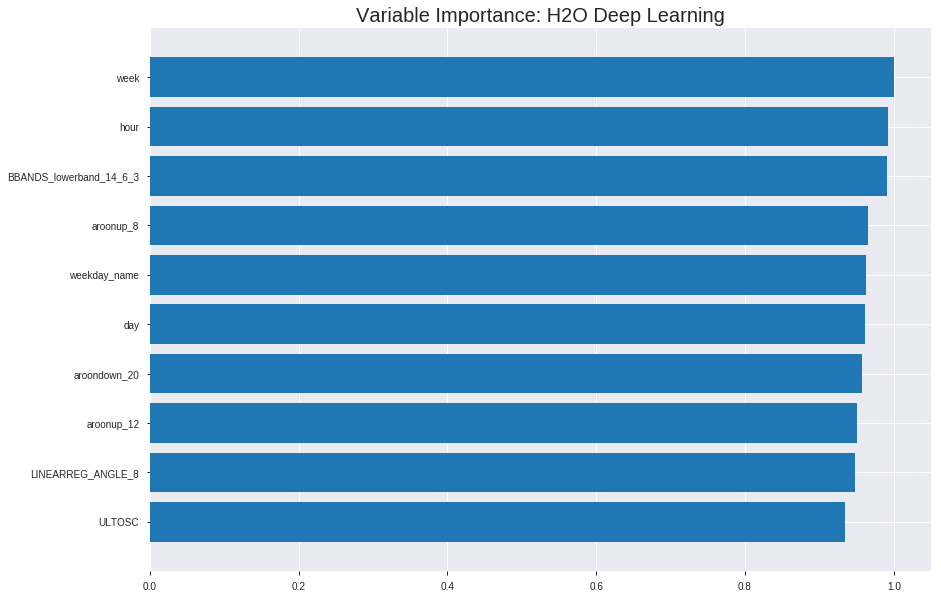

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_184151_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24993749747847913
RMSE: 0.49993749357142553
LogLoss: 0.6930221757413021
Mean Per-Class Error: 0.4916131358262078
AUC: 0.4958761223367652
pr_auc: 0.48539862896938996
Gini: -0.008247755326469597
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4894902824529671: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    793   1        (793.0/793.0)
1      0    766   0        (0.0/766.0)
Total  0    1559  0.5087   (793.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.48949      0.658925   399
max f2                       0.48949      0.828466   399
max f0point5                 0.48949      0.546987   399
max accuracy                 0.493294     0.509942   34
max precision                0.4936       0.518519   16
max recall                   0.48949      1          399
max specificity              0.494005     0.998739   0
max absolute_mcc             0.489927     0.0500099  385
max min_per_class_accuracy   0.491978     0.501305   188
max mean_per_class_accuracy  0.492103     0.508387   171

Gains/Lift Table: Avg response rate: 49.13 %, avg score: 49.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.49367            0.763218  0.763218           0.375            0.493827  0.375                       0.493827            0.0078329       0.0078329                  -23.6782  -23.6782
    2        0.020526                    0.493522           1.27203   1.01762            0.625            0.493609  0.5                         0.493718            0.0130548       0.0208877                  27.203    1.7624
    3        0.0301475                   0.493418           0.814099  0.952669           0.4              0.493459  0.468085                    0.493635            0.0078329       0.0287206                  -18.5901  -4.73307
    4        0.0404105                   0.493333           1.14483   1.00147            0.5625           0.49338   0.492063                    0.49357             0.0117493       0.04047                    14.4827   0.147126
    5        0.0500321                   0.493233           0.814099  0.965438           0.4              0.493282  0.474359                    0.493515            0.0078329       0.0483029                  -18.5901  -3.45618
    6        0.100064                    0.493005           0.965438  0.965438           0.474359         0.493119  0.474359                    0.493317            0.0483029       0.0966057                  -3.45618  -3.45618
    7        0.150096                    0.492831           0.939345  0.956741           0.461538         0.492923  0.470085                    0.493186            0.0469974       0.143603                   -6.06547  -4.32595
    8        0.200128                    0.492687           1.01762   0.971961           0.5              0.492752  0.477564                    0.493077            0.0509138       0.194517                   1.7624    -2.80386
    9        0.300192                    0.49242            1.03067   0.991531           0.50641          0.492545  0.487179                    0.4929              0.103133        0.29765                    3.06705   -0.84689
    10       0.400257                    0.492197           1.04372   1.00458            0.512821         0.492307  0.49359                     0.492751            0.104439        0.402089                   4.37169   0.457756
    11       0.500321                    0.491974           0.991531  1.00197            0.487179         0.492088  0.492308                    0.492619            0.0992167       0.501305                   -0.84689  0.196827
    12       0.599743                    0.491702           0.984797  0.999122           0.483871         0.491839  0.490909                    0.49249             0.0979112       0.599217                   -1.52026  -0.0878234
    13       0.699808                    0.491366           0.991531  0.998036           0.487179         0.491548  0.490376                    0.492355            0.0992167       0.698433                   -0.84689  -0.196361
    14       0.799872                    0.490955           1.00458   0.998855           0.49359          0.491168  0.490778                    0.492206            0.100522        0.798956                   0.457756  -0.114531
    15       0.899936                    0.490458           0.913252  0.989337           0.448718         0.490707  0.486101                    0.49204             0.0913838       0.890339                   -8.67477  -1.06635
    16       1                           0.48949            1.0959    1                  0.538462         0.490139  0.491341                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2500768259362221
RMSE: 0.5000768200349044
LogLoss: 0.6933008414051619
Mean Per-Class Error: 0.4559202059202059
AUC: 0.5223515926640927
pr_auc: 0.5093841776145247
Gini: 0.0447031853281854
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4891413984168277: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    222  1        (222.0/222.0)
1      0    224  0        (0.0/224.0)
Total  0    446  0.4978   (222.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.489141     0.668657   399
max f2                       0.489141     0.834575   399
max f0point5                 0.491153     0.567602   300
max accuracy                 0.491364     0.544843   265
max precision                0.493641     1          0
max recall                   0.489141     1          399
max specificity              0.493641     1          0
max absolute_mcc             0.491153     0.0961949  300
max min_per_class_accuracy   0.491745     0.513514   200
max mean_per_class_accuracy  0.491364     0.54408    265

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 49.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.49314            1.19464   1.19464            0.6              0.493293  0.6                         0.493293            0.0133929       0.0133929                  19.4643    19.4643
    2        0.0201794                   0.493045           0.995536  1.10615            0.5              0.493096  0.555556                    0.493205            0.00892857      0.0223214                  -0.446429  10.6151
    3        0.0313901                   0.492923           0.796429  0.995536           0.4              0.492986  0.5                         0.493127            0.00892857      0.03125                    -20.3571   -0.446429
    4        0.0403587                   0.492846           0.995536  0.995536           0.5              0.492884  0.5                         0.493073            0.00892857      0.0401786                  -0.446429  -0.446429
    5        0.0515695                   0.49279            1.19464   1.03882            0.6              0.492823  0.521739                    0.493019            0.0133929       0.0535714                  19.4643    3.88199
    6        0.100897                    0.492586           0.995536  1.01766            0.5              0.492685  0.511111                    0.492855            0.0491071       0.102679                   -0.446429  1.76587
    7        0.150224                    0.492473           0.814529  0.950959           0.409091         0.492524  0.477612                    0.492747            0.0401786       0.142857                   -18.5471   -4.90405
    8        0.201794                    0.492332           0.692547  0.884921           0.347826         0.492398  0.444444                    0.492658            0.0357143       0.178571                   -30.7453   -11.5079
    9        0.300448                    0.492136           1.17654   0.980677           0.590909         0.492232  0.492537                    0.492518            0.116071        0.294643                   17.6542    -1.9323
    10       0.401345                    0.49196            1.32738   1.06784            0.666667         0.492037  0.536313                    0.492397            0.133929        0.428571                   32.7381    6.78372
    11       0.5                         0.49175            0.859781  1.02679            0.431818         0.491851  0.515695                    0.492289            0.0848214       0.513393                   -14.0219   2.67857
    12       0.600897                    0.491504           1.0619    1.03268            0.533333         0.49163   0.518657                    0.492179            0.107143        0.620536                   6.19048    3.26826
    13       0.699552                    0.491278           1.13129   1.04659            0.568182         0.491402  0.525641                    0.492069            0.111607        0.732143                   13.1291    4.65888
    14       0.800448                    0.491011           0.973413  1.03736            0.488889         0.491159  0.521008                    0.491954            0.0982143       0.830357                   -2.65873   3.73649
    15       0.899103                    0.490617           0.678774  0.998018           0.340909         0.490831  0.501247                    0.491831            0.0669643       0.897321                   -32.1226   -0.198165
    16       1                           0.489141           1.01766   1                  0.511111         0.490013  0.502242            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:46:46  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 18:46:48  57.674 sec        622 obs/sec       0.63374   1             988        0.510512         0.715499            -0.042801      0.51069         0.512591           1.52644          0.507377                         0.514366           0.72457               -0.0583127       0.498421          0.517724             1.19464            0.497758
    2019-08-27 18:46:57  1 min  6.779 sec  1009 obs/sec      6.3374    10            9880       0.499937         0.693022            -4.99455e-05   0.495876        0.485399           0.763218         0.508659                         0.500077           0.693301              -0.000327419     0.522352          0.509384             1.19464            0.497758
    2019-08-27 18:47:06  1 min 16.063 sec  1186 obs/sec      13.8557   22            21601      0.498989         0.691084            0.00373957     0.56941         0.563334           1.65364          0.488775                         0.505779           0.704958              -0.0232695       0.496441          0.526638             1.59286            0.484305
    2019-08-27 18:47:16  1 min 26.527 sec  1237 obs/sec      21.3823   34            33335      0.495521         0.683962            0.0175424      0.606571        0.594286           1.65364          0.493906                         0.502484           0.6982                -0.00998155      0.491544          0.506696             1.19464            0.482063
    2019-08-27 18:47:33  1 min 43.089 sec  1360 obs/sec      37.1937   59            57985      0.477903         0.645193            0.0861595      0.658735        0.670736           1.90805          0.420783                         0.501501           0.696917              -0.00603431      0.549308          0.535051             0.796429           0.486547
    2019-08-27 18:47:42  1 min 52.363 sec  1406 obs/sec      46.0026   73            71718      0.469582         0.626168            0.117706       0.703899        0.707522           1.90805          0.418217                         0.503206           0.703616              -0.0128857       0.522653          0.545459             1.19464            0.491031
    2019-08-27 18:47:43  1 min 53.272 sec  1405 obs/sec      46.0026   73            71718      0.499937         0.693022            -4.99455e-05   0.495876        0.485399           0.763218         0.508659                         0.500077           0.693301              -0.000327419     0.522352          0.509384             1.19464            0.497758

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
week                     1.0                    1.0                  0.022376236196277675
hour                     0.9922049641609192     0.9922049641609192   0.022201812633183955
BBANDS_lowerband_14_6_3  0.991409182548523      0.991409182548523    0.02218400603586432
aroonup_8                0.965641975402832      0.965641975402832    0.02160743292265393
weekday_name             0.9628276228904724     0.9628276228904724   0.02154445830609778
---                      ---                    ---                  ---
APO                      0.8302802443504333     0.8302802443504333   0.01857854685668844
CMO_20                   0.7950952649116516     0.7950952649116516   0.017791239446205087
CDLADVANCEBLOCK          0.786235511302948      0.786235511302948    0.01759299150681591
CDLPIERCING              0.7836844325065613     0.7836844325065613   0.017535907965112646
CDLMORNINGDOJISTAR       0.7774877548217773     0.7774877548217773   0.017397249641605717


See the whole table with table.as_data_frame()


('accuracy', 0.5605381165919282)

('F1', 0.6204620462046205)

('auc', 0.5571836734693877)

('logloss', 0.6910286998519517)

('mean_per_class_error', 0.43677551020408156)

('rmse', 0.4989397596030363)

('mse', 0.24894088371273568)

deeplearning prediction progress: |███████████████████████████████████████| 100%


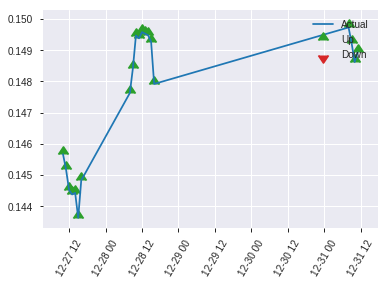


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24894088371273568
RMSE: 0.4989397596030363
LogLoss: 0.6910286998519517
Mean Per-Class Error: 0.43677551020408156
AUC: 0.5571836734693877
pr_auc: 0.46777297007791013
Gini: 0.11436734693877537
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4901411926904383: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      14   111  0.888    (111.0/125.0)
1      4    94   0.0408   (4.0/98.0)
Total  18   205  0.5157   (115.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.490141     0.620462  204
max f2                       0.4901       0.800654  208
max f0point5                 0.490525     0.519391  155
max accuracy                 0.492815     0.560538  3
max precision                0.492815     0.5       3
max recall                   0.4901       1         208
max specificity              0.49359      0.992     0
max absolute_mcc             0.490141     0.129699  204
max min_per_class_accuracy   0.490858     0.552     110
max mean_per_class_accuracy  0.490783     0.563224  122

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 49.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.4929             0.758503  0.758503           0.333333         0.493354  0.333333                    0.493354            0.0102041       0.0102041                  -24.1497  -24.1497
    2        0.0224215                   0.492705           1.13776   0.910204           0.5              0.492804  0.4                         0.493134            0.0102041       0.0204082                  13.7755   -8.97959
    3        0.0313901                   0.492508           1.13776   0.975219           0.5              0.492582  0.428571                    0.492976            0.0102041       0.0306122                  13.7755   -2.47813
    4        0.0403587                   0.492364           1.13776   1.01134            0.5              0.492456  0.444444                    0.492861            0.0102041       0.0408163                  13.7755   1.13379
    5        0.0538117                   0.492298           0.758503  0.948129           0.333333         0.492319  0.416667                    0.492725            0.0102041       0.0510204                  -24.1497  -5.18707
    6        0.103139                    0.49192            1.03432   0.989352           0.454545         0.492076  0.434783                    0.492415            0.0510204       0.102041                   3.43228   -1.06477
    7        0.152466                    0.491763           1.24119   1.07083            0.545455         0.49184   0.470588                    0.492229            0.0612245       0.163265                   24.1187   7.08283
    8        0.201794                    0.491625           1.24119   1.11247            0.545455         0.4917    0.488889                    0.4921              0.0612245       0.22449                    24.1187   11.2472
    9        0.300448                    0.49134            1.03432   1.08681            0.454545         0.491462  0.477612                    0.49189             0.102041        0.326531                   3.43228   8.68108
    10       0.399103                    0.491033           1.13776   1.0994             0.5              0.491192  0.483146                    0.491717            0.112245        0.438776                   13.7755   9.94038
    11       0.502242                    0.49085            1.28616   1.13776            0.565217         0.490925  0.5                         0.491555            0.132653        0.571429                   28.6158   13.7755
    12       0.600897                    0.490694           0.827458  1.08681            0.363636         0.490772  0.477612                    0.491426            0.0816327       0.653061                   -17.2542  8.68108
    13       0.699552                    0.490524           1.13776   1.094              0.5              0.490593  0.480769                    0.491309            0.112245        0.765306                   13.7755   9.39953
    14       0.798206                    0.490348           0.620594  1.03548            0.272727         0.490447  0.455056                    0.491202            0.0612245       0.826531                   -37.9406  3.5485
    15       0.896861                    0.490172           1.03432   1.03536            0.454545         0.490252  0.455                       0.491098            0.102041        0.928571                   3.43228   3.53571
    16       1                           0.489994           0.692547  1                  0.304348         0.490125  0.439462                    0.490997     

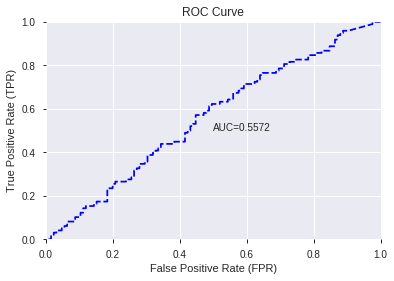

This function is available for GLM models only


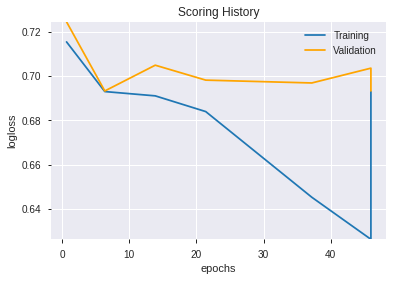

--2019-08-27 18:48:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.177.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.177.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_184151_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_184151_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_85f7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['week',
 'hour',
 'BBANDS_lowerband_14_6_3',
 'aroonup_8',
 'weekday_name',
 'day',
 'aroondown_20',
 'aroonup_12',
 'LINEARREG_ANGLE_8',
 'ULTOSC',
 'aroonup_30',
 'ADXR_12',
 'aroondown_12',
 'dayofyear',
 'WILLR_12',
 'aroonup_24',
 'ADX_20',
 'NATR_24',
 'AROONOSC_30',
 'CCI_8',
 'CMO_30',
 'STDDEV_30',
 'aroondown_8',
 'aroonup_14',
 'CORREL_24',
 'PLUS_DI_30',
 'WILLR_20',
 'DX_24',
 'BOP',
 'STDDEV_12',
 'MFI_20',
 'DX_8',
 'BETA_24',
 'NATR_12',
 'MINUS_DI_20',
 'CORREL_30',
 'CORREL_8',
 'ROCP_24',
 'aroondown_14',
 'MOM_24',
 'aroonup_20',
 'TRIX_14',
 'aroondown_24',
 'VAR_14',
 'AROONOSC_24',
 'APO',
 'CMO_20',
 'CDLADVANCEBLOCK',
 'CDLPIERCING',
 'CDLMORNINGDOJISTAR']

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_184858_model_1  0.515184  0.69375                   0.5  0.500301  0.250301

variable  relative_importance  scaled_importance  percentage
0         LINEARREG_ANGLE_8             0.008592           1.000000    0.052115
1        CDLMORNINGDOJISTAR             0.007796           0.907378    0.047288
2              weekday_name             0.007596           0.884089    0.046074
3                aroonup_12             0.007129           0.829713    0.043241
4   BBANDS_lowerband_14_6_3             0.006981           0.812505    0.042344
5                    ULTOSC             0.006812           0.792824    0.041318
6                  WILLR_12             0.006607           0.768962    0.040075
7                      week             0.006509           0.757549    0.039480
8                 dayofyear             0.006369           0.741221    0.038629
9                  CORREL_8             0.006285           0.731523    0.038123
10                     hour             0.006182           0.719523    0.037498
11                aroonup_8             0.005628           0.655013    0.034136
12               aroonup_30             0.005355           0.623198    0.032478
13                 WILLR_20             0.005130           0.597104    0.031118
14              AROONOSC_30             0.004733           0.550852    0.028708
15                STDDEV_12             0.004414           0.513776    0.026776
16                      day             0.004154           0.483426    0.025194
17                  ROCP_24             0.003767           0.438470    0.022851
18                   MOM_24             0.003715           0.432345    0.022532
19             aroondown_20             0.003714           0.432199    0.022524
20               aroonup_24             0.003646           0.424337    0.022114
21             aroondown_12             0.003588           0.417537    0.021760
22                    DX_24             0.003393           0.394875    0.020579
23              AROONOSC_24             0.003259           0.379331    0.019769
24                CORREL_30             0.003208           0.373391    0.019459
25                  ADXR_12             0.003125           0.363665    0.018952
26                     DX_8             0.002864           0.333323    0.017371
27                      APO             0.002835           0.329912    0.017193
28              MINUS_DI_20             0.002518           0.293028    0.015271
29             aroondown_24             0.002078           0.241860    0.012605
30                      BOP             0.001901           0.221269    0.011531
31                  TRIX_14             0.001842           0.214323    0.011169
32               aroonup_14             0.001814           0.211117    0.011002
33             aroondown_14             0.001680           0.195528    0.010190
34               aroonup_20             0.001481           0.172364    0.008983
35                CORREL_24             0.001400           0.162979    0.008494
36                    CCI_8             0.001249           0.145357    0.007575
37               PLUS_DI_30             0.001024           0.119198    0.006212
38                   VAR_14             0.000896           0.104319    0.005437
39                   CMO_20             0.000782           0.091058    0.004746
40          CDLADVANCEBLOCK             0.000576           0.066988    0.003491
41                STDDEV_30             0.000536           0.062389    0.003251
42                   CMO_30             0.000431           0.050212    0.002617
43                   MFI_20             0.000360           0.041879    0.002183
44                  BETA_24             0.000238           0.027694    0.001443
45              aroondown_8             0.000198           0.023063    0.001202
46                   ADX_20             0.000194           0.022560    0.001176
47              CDLPIERCING             0.000128           0.014945    0.000779
48                  NATR_12             0.000094           0.010933    0.000570
49                 

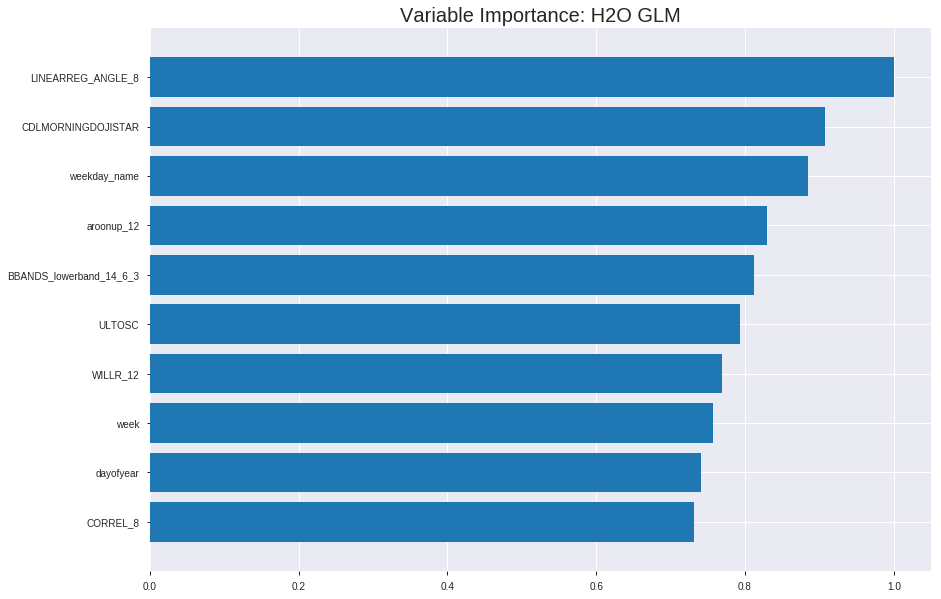

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_184858_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24877401030538787
RMSE: 0.49877250355787245
LogLoss: 0.6906937924921996
Null degrees of freedom: 1558
Residual degrees of freedom: 1508
Null deviance: 2160.7652781666966
Residual deviance: 2153.583244990679
AIC: 2255.583244990679
AUC: 0.5677764644292915
pr_auc: 0.5611908723706764
Gini: 0.13555292885858305
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4709701750190357: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      15   778   0.9811   (778.0/793.0)
1      5    761   0.0065   (5.0/766.0)
Total  20   1539  0.5022   (783.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.47097      0.660304  384
max f2                       0.466536     0.828466  399
max f0point5                 0.484856     0.561206  278
max accuracy                 0.497719     0.554201  128
max precision                0.533413     1         0
max recall                   0.466536     1         399
max specificity              0.533413     1         0
max absolute_mcc             0.499369     0.11737   112
max min_per_class_accuracy   0.491423     0.533943  201
max mean_per_class_accuracy  0.48791      0.553215  242

Gains/Lift Table: Avg response rate: 49.13 %, avg score: 49.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.519637           1.39923   1.39923            0.6875           0.523459  0.6875                      0.523459            0.0143603       0.0143603                  39.9233   39.9233
    2        0.020526                    0.513653           1.39923   1.39923            0.6875           0.516285  0.6875                      0.519872            0.0143603       0.0287206                  39.9233   39.9233
    3        0.0301475                   0.510492           1.49252   1.429              0.733333         0.511879  0.702128                    0.517321            0.0143603       0.0430809                  49.2515   42.9004
    4        0.0404105                   0.508263           1.52644   1.45375            0.75             0.509319  0.714286                    0.515289            0.0156658       0.0587467                  52.6436   45.3749
    5        0.0500321                   0.507372           1.22115   1.40902            0.6              0.507909  0.692308                    0.513869            0.0117493       0.0704961                  22.1149   40.9018
    6        0.100064                    0.503449           1.122     1.26551            0.551282         0.505292  0.621795                    0.509581            0.0561358       0.126632                   12.1996   26.5507
    7        0.150096                    0.500854           1.14809   1.22637            0.564103         0.50203   0.602564                    0.507064            0.0574413       0.184073                   14.8089   22.6367
    8        0.200128                    0.499082           1.22637   1.22637            0.602564         0.499898  0.602564                    0.505273            0.0613577       0.245431                   22.6367   22.6367
    9        0.300192                    0.496194           0.926299  1.12634            0.455128         0.497528  0.553419                    0.502691            0.0926893       0.33812                    -7.37012  12.6345
    10       0.400257                    0.493664           1.00458   1.0959             0.49359          0.494822  0.538462                    0.500724            0.100522        0.438642                   0.457756  9.59028
    11       0.500321                    0.491346           0.978485  1.07242            0.480769         0.492464  0.526923                    0.499072            0.0979112       0.536554                   -2.15154  7.24192
    12       0.599743                    0.488613           1.07671   1.07313            0.529032         0.490024  0.527273                    0.497572            0.10705         0.643603                   7.67119   7.31308
    13       0.699808                    0.486145           1.03067   1.06706            0.50641          0.487318  0.52429                     0.496106            0.103133        0.746736                   3.06705   6.70595
    14       0.799872                    0.483371           0.900206  1.04619            0.442308         0.484941  0.514034                    0.494709            0.0900783       0.836815                   -9.97941  4.6186
    15       0.899936                    0.478398           0.834974  1.0227             0.410256         0.481134  0.502495                    0.4932              0.0835509       0.920366                   -16.5026  2.27013
    16       1                           0.466536           0.795834  1                  0.391026         0.47462   0.491341                    0.491341          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25022900061818343
RMSE: 0.5002289482009047
LogLoss: 0.6936054151488494
Null degrees of freedom: 445
Residual degrees of freedom: 395
Null deviance: 618.4903607498804
Residual deviance: 618.6960303127737
AIC: 720.6960303127737
AUC: 0.49251930501930496
pr_auc: 0.5057897193434175
Gini: -0.01496138996139007
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48151731539967246: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    216  0.973    (216.0/222.0)
1      2    222  0.0089   (2.0/224.0)
Total  8    438  0.4888   (218.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.481517     0.670695  392
max f2                       0.477488     0.834575  399
max f0point5                 0.481517     0.561741  392
max accuracy                 0.506811     0.526906  83
max precision                0.511019     0.608696  44
max recall                   0.477488     1         399
max specificity              0.52066      0.995495  0
max absolute_mcc             0.492131     0.105111  304
max min_per_class_accuracy   0.499472     0.5       198
max mean_per_class_accuracy  0.506811     0.528274  83

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 49.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.51767            0.398214  0.398214           0.2              0.519309  0.2                         0.519309            0.00446429      0.00446429                 -60.1786  -60.1786
    2        0.0201794                   0.51522            1.4933    0.884921           0.75             0.516588  0.444444                    0.518099            0.0133929       0.0178571                  49.3304   -11.5079
    3        0.0313901                   0.514947           0.398214  0.711097           0.2              0.515099  0.357143                    0.517028            0.00446429      0.0223214                  -60.1786  -28.8903
    4        0.0403587                   0.514294           1.99107   0.995536           1                0.514677  0.5                         0.516505            0.0178571       0.0401786                  99.1071   -0.446429
    5        0.0515695                   0.513662           1.19464   1.03882            0.6              0.513883  0.521739                    0.515935            0.0133929       0.0535714                  19.4643   3.88199
    6        0.100897                    0.511105           1.35755   1.19464            0.681818         0.512339  0.6                         0.514177            0.0669643       0.120536                   35.7549   19.4643
    7        0.150224                    0.508762           1.08604   1.15898            0.545455         0.509859  0.58209                     0.512759            0.0535714       0.174107                   8.6039    15.8982
    8        0.201794                    0.506634           1.03882   1.12827            0.521739         0.507619  0.566667                    0.511445            0.0535714       0.227679                   3.88199   12.8274
    9        0.300448                    0.503826           0.814529  1.02525            0.409091         0.505356  0.514925                    0.509446            0.0803571       0.308036                   -18.5471  2.52532
    10       0.401345                    0.50106            0.884921  0.989974           0.444444         0.502315  0.497207                    0.507653            0.0892857       0.397321                   -11.5079  -1.00259
    11       0.5                         0.499385           1.04079   1                  0.522727         0.500239  0.502242                    0.50619             0.102679        0.5                        4.07873   0
    12       0.600897                    0.496743           0.796429  0.965818           0.4              0.498077  0.485075                    0.504828            0.0803571       0.580357                   -20.3571  -3.41818
    13       0.699552                    0.494766           0.859781  0.950864           0.431818         0.495799  0.477564                    0.503555            0.0848214       0.665179                   -14.0219  -4.91358
    14       0.800448                    0.491581           0.973413  0.953706           0.488889         0.493017  0.478992                    0.502226            0.0982143       0.763393                   -2.65873  -4.62935
    15       0.899103                    0.486583           1.26705   0.988088           0.636364         0.48917   0.496259                    0.500794            0.125           0.888393                   26.7045   -1.19122
    16       1                           0.477488           1.10615   1                  0.555556         0.483607  0.502242                    0.49906      


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 18:48:59  0.000 sec   2            2.5       51            1.38139           1.38721
    2019-08-27 18:48:59  0.025 sec   4            1.5       51            1.37941           1.38783
    2019-08-27 18:48:59  0.047 sec   6            0.96      51            1.37692           1.38893
    2019-08-27 18:48:59  0.063 sec   8            0.6       51            1.37393           1.39067
    2019-08-27 18:48:59  0.075 sec   10           0.37      51            1.37053           1.39306

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5695067264573991)

('F1', 0.6105919003115265)

('auc', 0.5151836734693878)

('logloss', 0.6937498703065718)

('mean_per_class_error', 0.4573061224489796)

('rmse', 0.5003010831019944)

('mse', 0.2503011737530287)

glm prediction progress: |████████████████████████████████████████████████| 100%


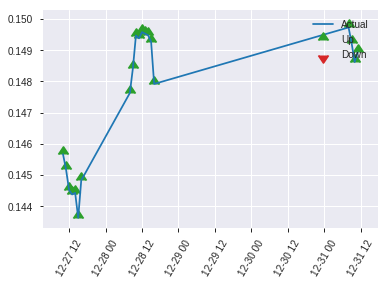


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2503011737530287
RMSE: 0.5003010831019944
LogLoss: 0.6937498703065718
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 308.275230921901
Residual deviance: 309.412442156731
AIC: 411.412442156731
AUC: 0.5151836734693878
pr_auc: 0.46032670279380283
Gini: 0.03036734693877552
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47951218803257983: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    125  1        (125.0/125.0)
1      0    98   0        (0.0/98.0)
Total  0    223  0.5605   (125.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479512     0.610592  222
max f2                       0.479512     0.796748  222
max f0point5                 0.479512     0.494949  222
max accuracy                 0.518702     0.569507  5
max precision                0.521519     0.666667  2
max recall                   0.479512     1         222
max specificity              0.522037     0.992     0
max absolute_mcc             0.488576     0.133148  202
max min_per_class_accuracy   0.502929     0.520408  105
max mean_per_class_accuracy  0.504076     0.542694  93

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 50.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.521207           1.51701   1.51701            0.666667         0.521745  0.666667                    0.521745            0.0204082       0.0204082                  51.7007   51.7007
    2        0.0224215                   0.519352           1.13776   1.36531            0.5              0.51998   0.6                         0.521039            0.0102041       0.0306122                  13.7755   36.5306
    3        0.0313901                   0.518301           1.13776   1.30029            0.5              0.518662  0.571429                    0.52036             0.0102041       0.0408163                  13.7755   30.0292
    4        0.0403587                   0.517579           1.13776   1.26417            0.5              0.518115  0.555556                    0.519861            0.0102041       0.0510204                  13.7755   26.4172
    5        0.0538117                   0.517179           0.758503  1.13776            0.333333         0.517387  0.5                         0.519242            0.0102041       0.0612245                  -24.1497  13.7755
    6        0.103139                    0.515689           0.827458  0.989352           0.363636         0.516228  0.434783                    0.517801            0.0408163       0.102041                   -17.2542  -1.06477
    7        0.152466                    0.51347            1.44805   1.13776            0.636364         0.514618  0.5                         0.516771            0.0714286       0.173469                   44.8052   13.7755
    8        0.201794                    0.511738           1.03432   1.11247            0.454545         0.512463  0.488889                    0.515718            0.0510204       0.22449                    3.43228   11.2472
    9        0.300448                    0.507977           1.03432   1.08681            0.454545         0.510234  0.477612                    0.513917            0.102041        0.326531                   3.43228   8.68108
    10       0.399103                    0.505027           1.03432   1.07384            0.454545         0.506548  0.47191                     0.512096            0.102041        0.428571                   3.43228   7.38363
    11       0.502242                    0.502252           0.890417  1.03617            0.391304         0.503348  0.455357                    0.510299            0.0918367       0.520408                   -10.9583  3.61698
    12       0.600897                    0.500093           1.03432   1.03587            0.454545         0.501173  0.455224                    0.508801            0.102041        0.622449                   3.43228   3.58666
    13       0.699552                    0.497802           0.724026  0.991889           0.318182         0.49896   0.435897                    0.507413            0.0714286       0.693878                   -27.5974  -0.811094
    14       0.798206                    0.494614           0.930891  0.98435            0.409091         0.496105  0.432584                    0.506015            0.0918367       0.785714                   -6.91095  -1.56501
    15       0.896861                    0.489102           0.827458  0.967092           0.363636         0.492131  0.425                       0.504488            0.0816327       0.867347                   -17.2542  -3.29082
    16       1                           0.479512           1.28616   1                  0.565217         0.485077  0.439462                    0.502486    

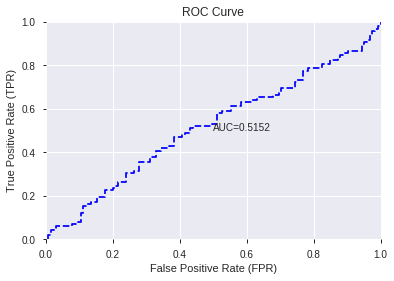

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


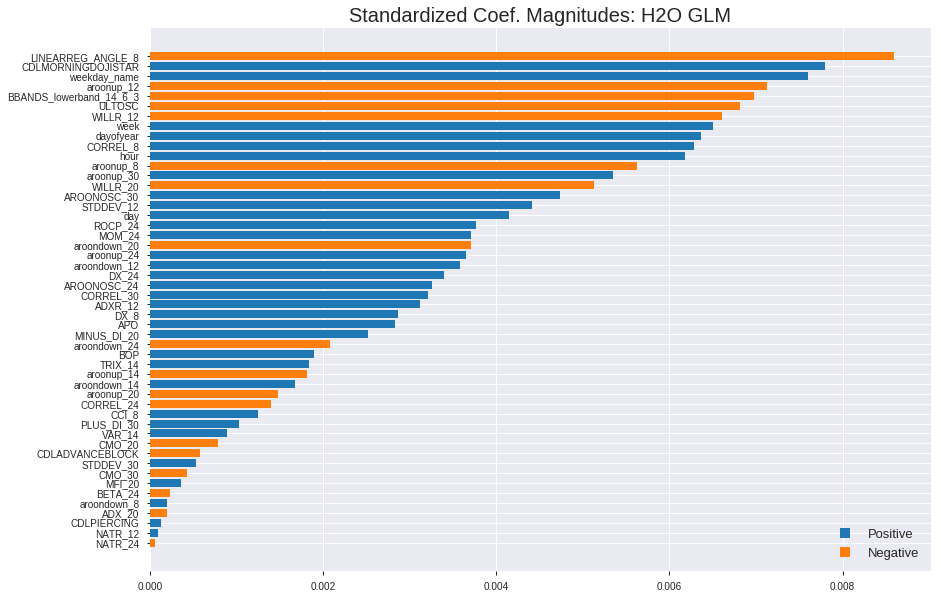

'log_likelihood'
--2019-08-27 18:49:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.229.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.229.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_184858_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_184858_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_85f7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['LINEARREG_ANGLE_8',
 'CDLMORNINGDOJISTAR',
 'weekday_name',
 'aroonup_12',
 'BBANDS_lowerband_14_6_3',
 'ULTOSC',
 'WILLR_12',
 'week',
 'dayofyear',
 'CORREL_8',
 'hour',
 'aroonup_8',
 'aroonup_30',
 'WILLR_20',
 'AROONOSC_30',
 'STDDEV_12',
 'day',
 'ROCP_24',
 'MOM_24',
 'aroondown_20',
 'aroonup_24',
 'aroondown_12',
 'DX_24',
 'AROONOSC_24',
 'CORREL_30',
 'ADXR_12',
 'DX_8',
 'APO',
 'MINUS_DI_20',
 'aroondown_24',
 'BOP',
 'TRIX_14',
 'aroonup_14',
 'aroondown_14',
 'aroonup_20',
 'CORREL_24',
 'CCI_8',
 'PLUS_DI_30',
 'VAR_14',
 'CMO_20',
 'CDLADVANCEBLOCK',
 'STDDEV_30',
 'CMO_30',
 'MFI_20',
 'BETA_24',
 'aroondown_8',
 'ADX_20',
 'CDLPIERCING',
 'NATR_12',
 'NATR_24']

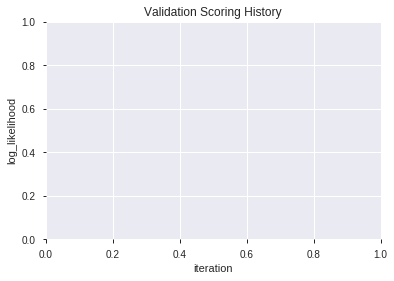

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_184911_model_4  0.540082  0.704649                 0.500  0.505632  0.255664
1  XGBoost_grid_1_AutoML_20190827_184911_model_2  0.526449  0.706334                 0.484  0.506498  0.256540
2  XGBoost_grid_1_AutoML_20190827_184911_model_5  0.520653  0.756325                 0.500  0.526777  0.277494
3  XGBoost_grid_1_AutoML_20190827_184911_model_3  0.518449  0.715375                 0.500  0.510585  0.260697
4               XGBoost_2_AutoML_20190827_184911  0.514122  0.713957                 0.500  0.510008  0.260108
5  XGBoost_grid_1_AutoML_20190827_184911_model_6  0.513388  0.718774                 0.500  0.512192  0.262341
6  XGBoost_grid_1_AutoML_20190827_184911_model_7  0.513224  0.715924                 0.500  0.510664  0.260778
7               XGBoost_1_AutoML_20190827_184911  0.511755  0.725733                 0.500  0.515097  0.265325
8               XGBoost_3_AutoML_20190827_184911  0.503510  0.717095                 0.500  0.511361  0.261490
9  XGBoost_grid_1_AutoML_20190827_184911_model_1  0.495673  0.717829                 0.500  0.511563  0.261697

variable  relative_importance  scaled_importance  percentage
0   BBANDS_lowerband_14_6_3           144.288239           1.000000    0.060178
1                  WILLR_12           138.110519           0.957185    0.057602
2         LINEARREG_ANGLE_8           107.379768           0.744203    0.044785
3                   BETA_24           101.744804           0.705150    0.042435
4                     CCI_8            95.141891           0.659388    0.039681
5                   TRIX_14            88.161423           0.611009    0.036769
6                    MFI_20            78.165688           0.541733    0.032601
7                       day            77.564438           0.537566    0.032350
8                       BOP            76.966698           0.533423    0.032100
9                  WILLR_20            76.142532           0.527711    0.031757
10                      APO            75.149292           0.520828    0.031343
11                     DX_8            74.282562           0.514821    0.030981
12              MINUS_DI_20            72.948280           0.505573    0.030425
13                     hour            71.882294           0.498185    0.029980
14               aroonup_24            64.856880           0.449495    0.027050
15                STDDEV_12            59.165184           0.410049    0.024676
16                dayofyear            57.267876           0.396899    0.023885
17                   ULTOSC            57.026108           0.395224    0.023784
18               aroonup_12            56.724621           0.393134    0.023658
19             weekday_name            53.350632           0.369750    0.022251
20                  NATR_24            52.884041           0.366517    0.022056
21              AROONOSC_30            50.975704           0.353291    0.021260
22                  NATR_12            49.391773           0.342313    0.020600
23              AROONOSC_24            48.839615           0.338486    0.020370
24                aroonup_8            48.607174           0.336876    0.020273
25             aroondown_20            45.052448           0.312239    0.018790
26                   MOM_24            44.571407           0.308905    0.018589
27                  ADXR_12            41.814060           0.289795    0.017439
28               aroonup_30            39.749126           0.275484    0.016578
29                STDDEV_30            37.061058           0.256854    0.015457
30                   ADX_20            35.329552           0.244854    0.014735
31               aroonup_14            30.134464           0.208849    0.012568
32                   CMO_30            28.022324           0.194211    0.011687
33               PLUS_DI_30            27.814081           0.192767    0.011600
34               aroonup_20            26.216917           0.181698    0.010934
35                   CMO_20            26.138382           0.181154    0.010902
36             aroondown_14            22.549337           0.156280    0.009405
37              aroondown_8            22.265942           0.154316    0.009286
38                   VAR_14            21.538010           0.149271    0.008983
39                  ROCP_24            19.995869           0.138583    0.008340
40             aroondown_24            17.457661           0.120992    0.007281
41                    DX_24            15.568031           0.107895    0.006493
42             aroondown_12            14.874922           0.103092    0.006204
43                CORREL_30             4.508331           0.031245    0.001880

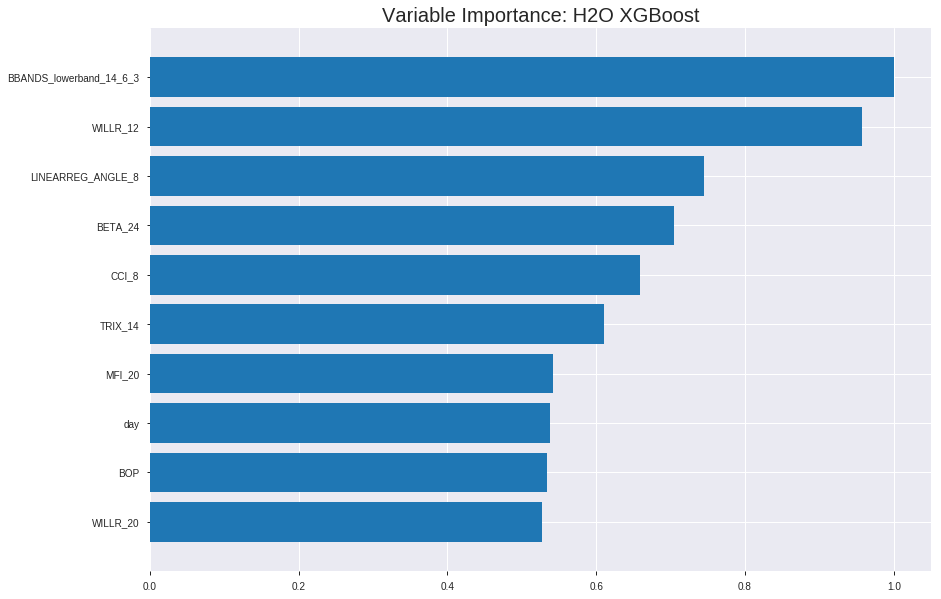

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_184911_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2205839573295014
RMSE: 0.46966366405067084
LogLoss: 0.6334831626223637
Mean Per-Class Error: 0.28346679002630726
AUC: 0.7805866606962356
pr_auc: 0.7770184037561518
Gini: 0.5611733213924712
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45555024594068527: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      397  396   0.4994   (396.0/793.0)
1      104  662   0.1358   (104.0/766.0)
Total  501  1058  0.3207   (500.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.45555      0.725877  251
max f2                       0.40132      0.837649  327
max f0point5                 0.519653     0.717306  150
max accuracy                 0.49142      0.716485  192
max precision                0.668003     1         0
max recall                   0.314119     1         395
max specificity              0.668003     1         0
max absolute_mcc             0.49142      0.433002  192
max min_per_class_accuracy   0.491973     0.713745  191
max mean_per_class_accuracy  0.49142      0.716533  192

Gains/Lift Table: Avg response rate: 49.13 %, avg score: 49.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.638783           2.03525   2.03525            1                0.647914  1                           0.647914            0.0208877       0.0208877                  103.525   103.525
    2        0.020526                    0.62794            2.03525   2.03525            1                0.633448  1                           0.640681            0.0208877       0.0417755                  103.525   103.525
    3        0.0301475                   0.619067           1.89956   1.99194            0.933333         0.622455  0.978723                    0.634864            0.0182768       0.0600522                  89.9565   99.1945
    4        0.0404105                   0.613539           1.65364   1.90603            0.8125           0.616796  0.936508                    0.630275            0.0169713       0.0770235                  65.3639   90.6026
    5        0.0500321                   0.607172           1.89956   1.90478            0.933333         0.611268  0.935897                    0.62662             0.0182768       0.0953003                  89.9565   90.4783
    6        0.100064                    0.585972           1.8265    1.86564            0.897436         0.596636  0.916667                    0.611628            0.0913838       0.186684                   82.6505   86.5644
    7        0.150096                    0.569422           1.72213   1.81781            0.846154         0.576641  0.893162                    0.599966            0.0861619       0.272846                   72.2133   81.7807
    8        0.200128                    0.555181           1.43511   1.72213            0.705128         0.561526  0.846154                    0.590356            0.0718016       0.344648                   43.5111   72.2133
    9        0.300192                    0.532343           1.36988   1.60471            0.673077         0.544166  0.788462                    0.574959            0.137076        0.481723                   36.9878   60.4715
    10       0.400257                    0.511312           1.22637   1.51013            0.602564         0.522397  0.741987                    0.561819            0.122715        0.604439                   22.6367   51.0128
    11       0.500321                    0.490874           1.16114   1.44033            0.570513         0.500548  0.707692                    0.549565            0.116188        0.720627                   16.1135   44.0329
    12       0.599743                    0.470489           0.774707  1.32999            0.380645         0.480323  0.653476                    0.538086            0.0770235       0.79765                    -22.5293  32.9986
    13       0.699808                    0.450212           0.782788  1.25174            0.384615         0.460397  0.615032                    0.526977            0.078329        0.875979                   -21.7212  25.1743
    14       0.799872                    0.426217           0.587091  1.16859            0.288462         0.438191  0.574178                    0.51587             0.0587467       0.934726                   -41.2909  16.8595
    15       0.899936                    0.395962           0.378347  1.08073            0.185897         0.411806  0.531005                    0.504299            0.037859        0.972585                   -62.1653  8.07269
    16       1                           0.278488           0.273976  1                  0.134615         0.369031  0.491341                    0.490764         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25094838343401904
RMSE: 0.5009474857048581
LogLoss: 0.6950684127004331
Mean Per-Class Error: 0.4534467503217503
AUC: 0.5253881113256113
pr_auc: 0.5192385625959661
Gini: 0.0507762226512225
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38908082246780396: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      17   205  0.9234   (205.0/222.0)
1      5    219  0.0223   (5.0/224.0)
Total  22   424  0.4709   (210.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.389081     0.675926  377
max f2                       0.302744     0.834575  399
max f0point5                 0.415493     0.576497  349
max accuracy                 0.472743     0.547085  245
max precision                0.639315     0.75      3
max recall                   0.302744     1         399
max specificity              0.668059     0.995495  0
max absolute_mcc             0.415493     0.135479  349
max min_per_class_accuracy   0.495215     0.504464  199
max mean_per_class_accuracy  0.472743     0.546553  245

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 49.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.624921           1.19464   1.19464            0.6              0.648915  0.6                         0.648915            0.0133929       0.0133929                  19.4643    19.4643
    2        0.0201794                   0.620058           1.4933    1.32738            0.75             0.621842  0.666667                    0.636883            0.0133929       0.0267857                  49.3304    32.7381
    3        0.0313901                   0.613588           0.796429  1.13776            0.4              0.61616   0.571429                    0.629482            0.00892857      0.0357143                  -20.3571   13.7755
    4        0.0403587                   0.609601           1.4933    1.21677            0.75             0.611559  0.611111                    0.625499            0.0133929       0.0491071                  49.3304    21.6766
    5        0.0515695                   0.604368           1.59286   1.29852            0.8              0.607897  0.652174                    0.621672            0.0178571       0.0669643                  59.2857    29.8525
    6        0.100897                    0.581799           0.905032  1.10615            0.454545         0.590312  0.555556                    0.606341            0.0446429       0.111607                   -9.49675   10.6151
    7        0.150224                    0.566064           0.633523  0.950959           0.318182         0.57339   0.477612                    0.595521            0.03125         0.142857                   -36.6477   -4.90405
    8        0.201794                    0.555551           1.03882   0.973413           0.521739         0.560363  0.488889                    0.586536            0.0535714       0.196429                   3.88199    -2.65873
    9        0.300448                    0.536257           1.04079   0.995536           0.522727         0.545579  0.5                         0.573088            0.102679        0.299107                   4.07873    -0.446429
    10       0.401345                    0.514924           1.0619    1.01222            0.533333         0.525889  0.50838                     0.561222            0.107143        0.40625                    6.19048    1.22207
    11       0.5                         0.494763           0.995536  1.00893            0.5              0.505072  0.506726                    0.550143            0.0982143       0.504464                   -0.446429  0.892857
    12       0.600897                    0.477124           1.28313   1.05497            0.644444         0.484779  0.529851                    0.539168            0.129464        0.633929                   28.3135    5.49707
    13       0.699552                    0.459009           0.905032  1.03383            0.454545         0.46873   0.519231                    0.529234            0.0892857       0.723214                   -9.49675   3.38255
    14       0.800448                    0.433915           1.0619    1.03736            0.533333         0.447354  0.521008                    0.518913            0.107143        0.830357                   6.19048    3.73649
    15       0.899103                    0.410618           1.04079   1.03774            0.522727         0.423456  0.521197                    0.508439            0.102679        0.933036                   4.07873    3.77405
    16       1                           0.302744           0.66369   1                  0.333333         0.382737  0.502242               


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:49:18  2.424 sec   0                  0.5              0.693147            0.5             0                  1                0.508659                         0.5                0.693147              0.5               0                    1                  0.497758
    2019-08-27 18:49:18  2.535 sec   5                  0.496235         0.685639            0.654238        0.631924           1.27203          0.431046                         0.499928           0.693003              0.50543           0.499029             1.19464            0.488789
    2019-08-27 18:49:18  2.585 sec   10                 0.492527         0.678286            0.695168        0.680797           1.79581          0.423348                         0.499618           0.692382              0.520331          0.510676             1.59286            0.495516
    2019-08-27 18:49:18  2.638 sec   15                 0.489078         0.671474            0.715345        0.699796           1.90805          0.386786                         0.49889            0.690929              0.540983          0.519894             0.398214           0.493274
    2019-08-27 18:49:18  2.698 sec   20                 0.485254         0.663958            0.73707         0.732904           1.90805          0.356639                         0.498842           0.690823              0.531049          0.520554             1.19464            0.493274
    2019-08-27 18:49:18  2.757 sec   25                 0.482516         0.658583            0.743507        0.739585           1.90805          0.341886                         0.499061           0.69124               0.526273          0.52551              1.59286            0.470852
    2019-08-27 18:49:18  2.818 sec   30                 0.479927         0.653487            0.743726        0.74011            1.90805          0.372675                         0.499175           0.691462              0.529631          0.527616             1.59286            0.475336
    2019-08-27 18:49:18  2.889 sec   35                 0.47668          0.647144            0.758052        0.753258           2.03525          0.36177                          0.500439           0.693996              0.51838           0.517433             1.19464            0.486547
    2019-08-27 18:49:18  2.953 sec   40                 0.474218         0.642355            0.768893        0.76671            2.03525          0.309173                         0.500821           0.694783              0.518068          0.514611             1.59286            0.488789
    2019-08-27 18:49:18  3.020 sec   45                 0.471749         0.637544            0.775994        0.772977           2.03525          0.319436                         0.500802           0.694755              0.523608          0.516869             1.59286            0.473094
    2019-08-27 18:49:18  3.086 sec   50                 0.469664         0.633483            0.780587        0.777018           2.03525          0.320718                         0.500947           0.695068              0.525388          0.519239             1.19464            0.470852

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
BBANDS_lowerband_14_6_3  144.28823852539062     1.0                   0.06017827277238903
WILLR_12                 138.1105194091797      0.9571848739762401    0.05760173243974699
LINEARREG_ANGLE_8        107.37976837158203     0.7442031968023939    0.044784862975258376
BETA_24                  101.74480438232422     0.7051496741671015    0.04243468943738908
CCI_8                    95.14189147949219      0.6593877120673971    0.03968081359955334
---                      ---                    ---                   ---
ROCP_24                  19.995868682861328     0.13858280402627982   0.008339673782256
aroondown_24             17.457660675048828     0.1209915711319518    0.007281063770738506
DX_24                    15.568031311035156     0.10789535910992236   0.006492956351391778
aroondown_12             14.874921798706055     0.10309171385503117   0.006203881276941143
CORREL_30                4.508330821990967      0.031245310553830268  0.0018802888213664036


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6053811659192825)

('F1', 0.6105919003115265)

('auc', 0.5400816326530612)

('logloss', 0.7046490545258155)

('mean_per_class_error', 0.4188163265306122)

('rmse', 0.5056320577976204)

('mse', 0.25566377787265615)

xgboost prediction progress: |████████████████████████████████████████████| 100%


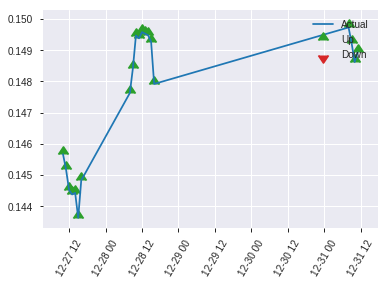


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25566377787265615
RMSE: 0.5056320577976204
LogLoss: 0.7046490545258155
Mean Per-Class Error: 0.4188163265306122
AUC: 0.5400816326530612
pr_auc: 0.5036115546653799
Gini: 0.08016326530612239
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3201974630355835: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    125  1        (125.0/125.0)
1      0    98   0        (0.0/98.0)
Total  0    223  0.5605   (125.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.320197     0.610592  222
max f2                       0.320197     0.796748  222
max f0point5                 0.577321     0.525641  72
max accuracy                 0.592969     0.605381  55
max precision                0.691786     1         0
max recall                   0.320197     1         222
max specificity              0.691786     1         0
max absolute_mcc             0.592969     0.174805  55
max min_per_class_accuracy   0.537712     0.540816  107
max mean_per_class_accuracy  0.577321     0.581184  72

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 53.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.661711           1.51701   1.51701            0.666667         0.675864  0.666667                    0.675864            0.0204082       0.0204082                  51.7007   51.7007
    2        0.0224215                   0.652926           2.27551   1.82041            1                0.655743  0.8                         0.667816            0.0204082       0.0408163                  127.551   82.0408
    3        0.0313901                   0.645678           1.13776   1.62536            0.5              0.648825  0.714286                    0.66239             0.0102041       0.0510204                  13.7755   62.5364
    4        0.0403587                   0.640164           1.13776   1.51701            0.5              0.643263  0.666667                    0.658139            0.0102041       0.0612245                  13.7755   51.7007
    5        0.0538117                   0.637036           1.51701   1.51701            0.666667         0.638469  0.666667                    0.653222            0.0204082       0.0816327                  51.7007   51.7007
    6        0.103139                    0.620633           0.827458  1.18722            0.363636         0.629118  0.521739                    0.641694            0.0408163       0.122449                   -17.2542  18.7223
    7        0.152466                    0.60954            0.827458  1.07083            0.363636         0.615691  0.470588                    0.633281            0.0408163       0.163265                   -17.2542  7.08283
    8        0.201794                    0.6013             1.86178   1.26417            0.818182         0.60413   0.555556                    0.626156            0.0918367       0.255102                   86.1781   26.4172
    9        0.300448                    0.579353           1.24119   1.25663            0.545455         0.59093   0.552239                    0.614589            0.122449        0.377551                   24.1187   25.6625
    10       0.399103                    0.562185           0.930891  1.17611            0.409091         0.570959  0.516854                    0.603804            0.0918367       0.469388                   -6.91095  17.6106
    11       0.502242                    0.533824           0.692547  1.0768             0.304348         0.546623  0.473214                    0.592061            0.0714286       0.540816                   -30.7453  7.68039
    12       0.600897                    0.515983           0.724026  1.01889            0.318182         0.525319  0.447761                    0.581104            0.0714286       0.612245                   -27.5974  1.88852
    13       0.699552                    0.487332           0.620594  0.962716           0.272727         0.499908  0.423077                    0.569653            0.0612245       0.673469                   -37.9406  -3.72841
    14       0.798206                    0.469724           0.930891  0.958782           0.409091         0.477583  0.421348                    0.558274            0.0918367       0.765306                   -6.91095  -4.12176
    15       0.896861                    0.443751           1.24119   0.989847           0.545455         0.457198  0.435                       0.547155            0.122449        0.887755                   24.1187   -1.01531
    16       1                           0.320197           1.08829   1                  0.478261         0.411352  0.439462                    0.533149      

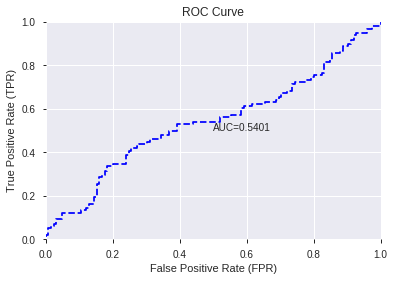

This function is available for GLM models only


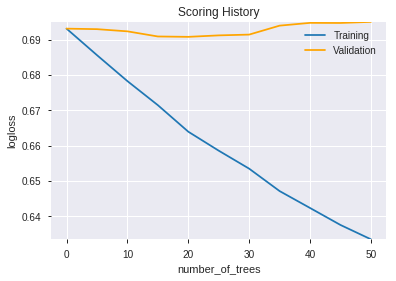

--2019-08-27 18:49:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.40.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.40.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.ge

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_184911_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_184911_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_85f7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BBANDS_lowerband_14_6_3',
 'WILLR_12',
 'LINEARREG_ANGLE_8',
 'BETA_24',
 'CCI_8',
 'TRIX_14',
 'MFI_20',
 'day',
 'BOP',
 'WILLR_20',
 'APO',
 'DX_8',
 'MINUS_DI_20',
 'hour',
 'aroonup_24',
 'STDDEV_12',
 'dayofyear',
 'ULTOSC',
 'aroonup_12',
 'weekday_name',
 'NATR_24',
 'AROONOSC_30',
 'NATR_12',
 'AROONOSC_24',
 'aroonup_8',
 'aroondown_20',
 'MOM_24',
 'ADXR_12',
 'aroonup_30',
 'STDDEV_30',
 'ADX_20',
 'aroonup_14',
 'CMO_30',
 'PLUS_DI_30',
 'aroonup_20',
 'CMO_20',
 'aroondown_14',
 'aroondown_8',
 'VAR_14',
 'ROCP_24',
 'aroondown_24',
 'DX_24',
 'aroondown_12',
 'CORREL_30']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse      mse
0  GLM_grid_1_AutoML_20190827_184936_model_1  0.541143  0.692302              0.481102  0.49958  0.24958

variable  relative_importance  scaled_importance    percentage
0                        ADOSC         8.409502e-03           1.000000  1.483482e-02
1                       Volume         6.830307e-03           0.812213  1.204903e-02
2           CDLIDENTICAL3CROWS         6.259286e-03           0.744311  1.104172e-02
3         HT_PHASOR_quadrature         6.137056e-03           0.729776  1.082610e-02
4                 CDLSHORTLINE         5.497068e-03           0.653673  9.697126e-03
...                        ...                  ...                ...           ...
1029                      TANH         8.943415e-07           0.000106  1.577667e-06
1030  BBANDS_middleband_14_1_2         8.142665e-07           0.000097  1.436410e-06
1031                       TAN         6.225984e-07           0.000074  1.098297e-06
1032   BBANDS_upperband_30_7_2         1.196986e-07           0.000014  2.111549e-07
1033                      ACOS         1.109876e-07           0.000013  1.957881e-07

[1034 rows x 4 columns]

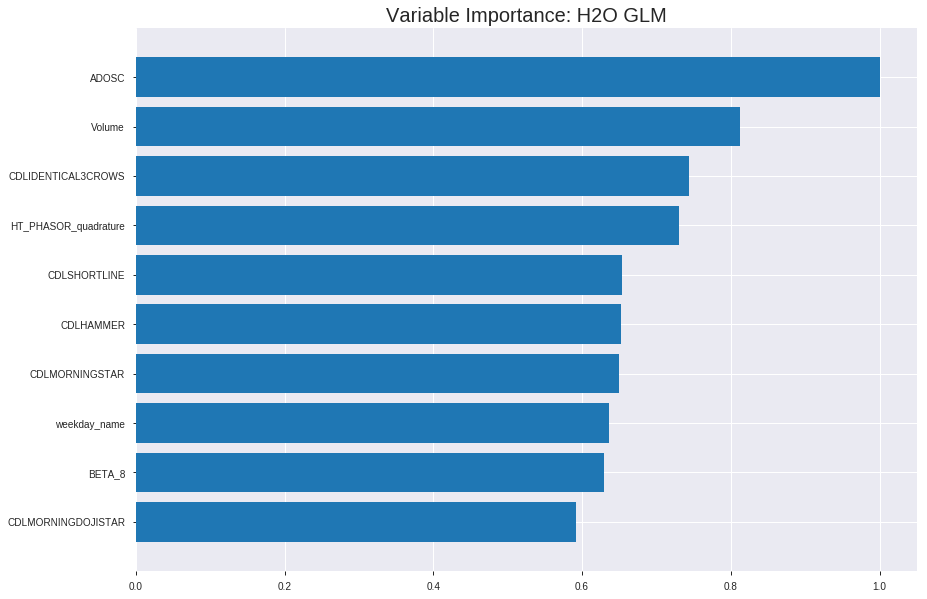

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_184936_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.246934154867178
RMSE: 0.49692469738097944
LogLoss: 0.686999102598439
Null degrees of freedom: 1558
Residual degrees of freedom: 524
Null deviance: 2160.7652781666966
Residual deviance: 2142.0632019019326
AIC: 4212.063201901932
AUC: 0.5768613422275195
pr_auc: 0.5628657684282348
Gini: 0.153722684455039
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4311295655910279: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      9    784   0.9887   (784.0/793.0)
1      1    765   0.0013   (1.0/766.0)
Total  10   1549  0.5035   (785.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.43113      0.660907  391
max f2                       0.430156     0.829543  393
max f0point5                 0.471873     0.563445  278
max accuracy                 0.50914      0.554843  130
max precision                0.585946     1         0
max recall                   0.430156     1         393
max specificity              0.585946     1         0
max absolute_mcc             0.522175     0.134924  83
max min_per_class_accuracy   0.490867     0.551072  202
max mean_per_class_accuracy  0.4893       0.554568  208

Gains/Lift Table: Avg response rate: 49.13 %, avg score: 49.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.558099           1.14483   1.14483            0.5625           0.569243  0.5625                      0.569243            0.0117493       0.0117493                  14.4827   14.4827
    2        0.020526                    0.549587           1.39923   1.27203            0.6875           0.554222  0.625                       0.561732            0.0143603       0.0261097                  39.9233   27.203
    3        0.0301475                   0.544085           1.49252   1.3424             0.733333         0.546295  0.659574                    0.556806            0.0143603       0.04047                    49.2515   34.2398
    4        0.0404105                   0.539052           1.27203   1.32453            0.625            0.541479  0.650794                    0.552913            0.0130548       0.0535248                  27.203    32.4527
    5        0.0500321                   0.536088           1.35683   1.33074            0.666667         0.537814  0.653846                    0.55001             0.0130548       0.0665796                  35.6832   33.0739
    6        0.100064                    0.524928           1.17418   1.25246            0.576923         0.529503  0.615385                    0.539756            0.0587467       0.125326                   17.4182   25.246
    7        0.150096                    0.520173           1.43511   1.31334            0.705128         0.522471  0.645299                    0.533995            0.0718016       0.197128                   43.5111   31.3344
    8        0.200128                    0.515027           0.965438  1.22637            0.474359         0.517515  0.602564                    0.529875            0.0483029       0.245431                   -3.45618  22.6367
    9        0.300192                    0.507044           0.991531  1.14809            0.487179         0.511059  0.564103                    0.523603            0.0992167       0.344648                   -0.84689  14.8089
    10       0.400257                    0.497828           1.08286   1.13178            0.532051         0.502381  0.55609                     0.518297            0.108355        0.453003                   8.28563   13.1781
    11       0.500321                    0.490822           1.01762   1.10895            0.5              0.494145  0.544872                    0.513467            0.101828        0.55483                    1.7624    10.8949
    12       0.599743                    0.482945           0.879752  1.07095            0.432258         0.486844  0.526203                    0.509053            0.0874674       0.642298                   -12.0248  7.0954
    13       0.699808                    0.475003           1.01762   1.06333            0.5              0.47927   0.522456                    0.504795            0.101828        0.744125                   1.7624    6.33285
    14       0.799872                    0.467254           0.926299  1.04619            0.455128         0.471285  0.514034                    0.500603            0.0926893       0.836815                   -7.37012  4.6186
    15       0.899936                    0.457069           0.939345  1.03431            0.461538         0.462479  0.508197                    0.496364            0.0939948       0.930809                   -6.06547  3.43064
    16       1                           0.406769           0.691462  1                  0.339744         0.446166  0.491341                    0.491341            0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2504067479249114
RMSE: 0.5004065826154882
LogLoss: 0.6939636042192595
Null degrees of freedom: 445
Residual degrees of freedom: -589
Null deviance: 618.4903607498804
Residual deviance: 619.0155349635795
AIC: 2689.0155349635797
AUC: 0.49813988095238093
pr_auc: 0.51675622822647
Gini: -0.0037202380952381375
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4531318836422355: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    216  0.973    (216.0/222.0)
1      3    221  0.0134   (3.0/224.0)
Total  9    437  0.491    (219.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.453132     0.668684  391
max f2                       0.42875      0.834575  399
max f0point5                 0.453132     0.560345  391
max accuracy                 0.510262     0.522422  61
max precision                0.554869     1         0
max recall                   0.42875      1         399
max specificity              0.554869     1         0
max absolute_mcc             0.541889     0.081924  2
max min_per_class_accuracy   0.488894     0.495495  201
max mean_per_class_accuracy  0.510262     0.524011  61

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 48.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.540042           1.19464   1.19464            0.6              0.544888  0.6                         0.544888            0.0133929       0.0133929                  19.4643    19.4643
    2        0.0201794                   0.534673           0.995536  1.10615            0.5              0.536586  0.555556                    0.541198            0.00892857      0.0223214                  -0.446429  10.6151
    3        0.0313901                   0.53028            1.19464   1.13776            0.6              0.532253  0.571429                    0.538004            0.0133929       0.0357143                  19.4643    13.7755
    4        0.0403587                   0.52581            0.995536  1.10615            0.5              0.529126  0.555556                    0.536031            0.00892857      0.0446429                  -0.446429  10.6151
    5        0.0515695                   0.522054           0.796429  1.03882            0.4              0.523706  0.521739                    0.533351            0.00892857      0.0535714                  -20.3571   3.88199
    6        0.100897                    0.514937           1.17654   1.10615            0.590909         0.518306  0.555556                    0.525996            0.0580357       0.111607                   17.6542    10.6151
    7        0.150224                    0.509744           1.17654   1.12926            0.590909         0.511968  0.567164                    0.52139             0.0580357       0.169643                   17.6542    12.9264
    8        0.201794                    0.505651           0.865683  1.0619             0.434783         0.507475  0.533333                    0.517834            0.0446429       0.214286                   -13.4317   6.19048
    9        0.300448                    0.498427           0.995536  1.04011            0.5              0.50185   0.522388                    0.512585            0.0982143       0.3125                     -0.446429  4.01119
    10       0.401345                    0.492109           0.929167  1.01222            0.466667         0.495664  0.50838                     0.508331            0.09375         0.40625                    -7.08333   1.22207
    11       0.5                         0.488869           0.905032  0.991071           0.454545         0.490525  0.497758                    0.504818            0.0892857       0.495536                   -9.49675   -0.892857
    12       0.600897                    0.484193           0.884921  0.973248           0.444444         0.486731  0.488806                    0.501781            0.0892857       0.584821                   -11.5079   -2.67524
    13       0.699552                    0.478307           0.995536  0.976391           0.5              0.481179  0.490385                    0.498876            0.0982143       0.683036                   -0.446429  -2.36092
    14       0.800448                    0.473704           0.929167  0.970438           0.466667         0.476164  0.487395                    0.496013            0.09375         0.776786                   -7.08333   -2.95618
    15       0.899103                    0.465318           1.08604   0.983123           0.545455         0.469836  0.493766                    0.49314             0.107143        0.883929                   8.6039     -1.68774
    16       1                           0.42875            1.1504    1                  0.577778         0.45747   0.502242              


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 18:49:40  0.000 sec   2            3.8       1035          1.374             1.38793
    2019-08-27 18:49:42  2.015 sec   4            2.7       1035          1.37134           1.38873
    2019-08-27 18:49:44  4.025 sec   6            2         1035          1.36813           1.38974
    2019-08-27 18:49:46  6.114 sec   8            1.5       1035          1.36428           1.3911
    2019-08-27 18:49:48  8.131 sec   10           1.1       1035          1.35977           1.39288

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5964125560538116)

('F1', 0.6178343949044586)

('auc', 0.5411428571428571)

('logloss', 0.6923019250328185)

('mean_per_class_error', 0.4470612244897959)

('rmse', 0.4995798945418329)

('mse', 0.24958007103042884)

glm prediction progress: |████████████████████████████████████████████████| 100%


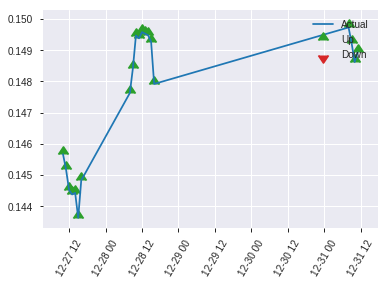


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24958007103042884
RMSE: 0.4995798945418329
LogLoss: 0.6923019250328185
Null degrees of freedom: 222
Residual degrees of freedom: -812
Null deviance: 308.275230921901
Residual deviance: 308.766658564637
AIC: 2378.766658564637
AUC: 0.5411428571428571
pr_auc: 0.49789189481832424
Gini: 0.0822857142857143
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4651186527668238: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    119  0.952    (119.0/125.0)
1      1    97   0.0102   (1.0/98.0)
Total  7    216  0.5381   (120.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.465119     0.617834  215
max f2                       0.465119     0.797697  215
max f0point5                 0.465119     0.504158  215
max accuracy                 0.53351      0.596413  23
max precision                0.554173     1         0
max recall                   0.449678     1         222
max specificity              0.554173     1         0
max absolute_mcc             0.53351      0.158977  23
max min_per_class_accuracy   0.506127     0.540816  109
max mean_per_class_accuracy  0.53129      0.552939  29

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 50.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.550448           1.51701   1.51701            0.666667         0.552527  0.666667                    0.552527            0.0204082       0.0204082                  51.7007   51.7007
    2        0.0224215                   0.546669           2.27551   1.82041            1                0.548279  0.8                         0.550828            0.0204082       0.0408163                  127.551   82.0408
    3        0.0313901                   0.544514           0         1.30029            0                0.544648  0.571429                    0.549062            0               0.0408163                  -100      30.0292
    4        0.0403587                   0.542298           2.27551   1.51701            1                0.543955  0.666667                    0.547927            0.0204082       0.0612245                  127.551   51.7007
    5        0.0538117                   0.540308           1.51701   1.51701            0.666667         0.541298  0.666667                    0.54627             0.0204082       0.0816327                  51.7007   51.7007
    6        0.103139                    0.533715           1.44805   1.48403            0.636364         0.535867  0.652174                    0.541295            0.0714286       0.153061                   44.8052   48.4028
    7        0.152466                    0.529548           1.03432   1.33854            0.454545         0.531591  0.588235                    0.538155            0.0510204       0.204082                   3.43228   33.8535
    8        0.201794                    0.524222           1.03432   1.26417            0.454545         0.52667   0.555556                    0.535348            0.0510204       0.255102                   3.43228   26.4172
    9        0.300448                    0.51708            0.827458  1.12077            0.363636         0.520727  0.492537                    0.530547            0.0816327       0.336735                   -17.2542  12.0774
    10       0.399103                    0.511578           0.827458  1.04827            0.363636         0.51446   0.460674                    0.52657             0.0816327       0.418367                   -17.2542  4.82687
    11       0.502242                    0.505859           1.18722   1.0768             0.521739         0.508616  0.473214                    0.522883            0.122449        0.540816                   18.7223   7.68039
    12       0.600897                    0.499262           1.03432   1.06983            0.454545         0.502823  0.470149                    0.51959             0.102041        0.642857                   3.43228   6.98294
    13       0.699552                    0.496177           0.724026  1.02106            0.318182         0.497813  0.448718                    0.516519            0.0714286       0.714286                   -27.5974  2.10623
    14       0.798206                    0.486534           0.620594  0.971566           0.272727         0.49245   0.426966                    0.513544            0.0612245       0.77551                    -37.9406  -2.84338
    15       0.896861                    0.473453           1.34462   1.0126             0.590909         0.481043  0.445                       0.509969            0.132653        0.908163                   34.462    1.2602
    16       1                           0.449678           0.890417  1                  0.391304         0.465234  0.439462                    0.505355         

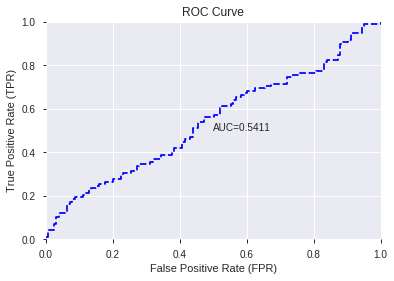

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


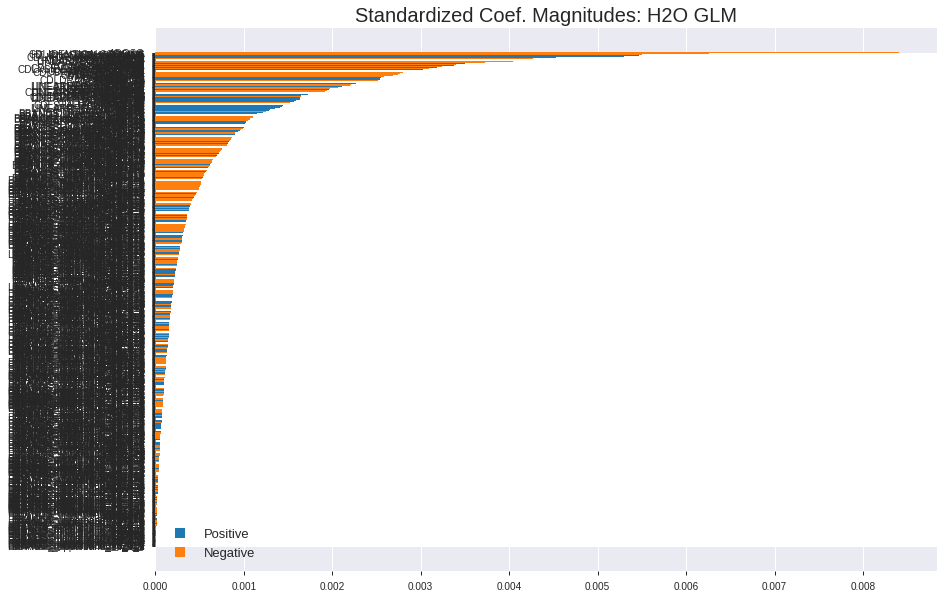

'log_likelihood'
--2019-08-27 18:50:14--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.109.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.109.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_184936_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_184936_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_85f7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

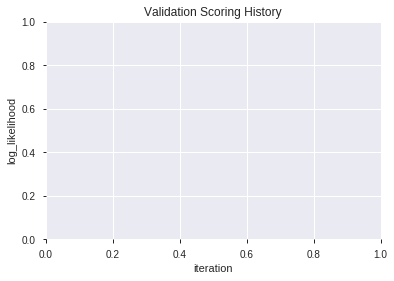

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_185019_model_3  0.543673  0.709109              0.500000  0.507563  0.257620
1  XGBoost_grid_1_AutoML_20190827_185019_model_2  0.542122  0.707072              0.500000  0.506667  0.256712
2               XGBoost_3_AutoML_20190827_185019  0.518122  0.712062              0.500000  0.508948  0.259028
3  XGBoost_grid_1_AutoML_20190827_185019_model_1  0.515265  0.710976              0.496000  0.508543  0.258616
4  XGBoost_grid_1_AutoML_20190827_185019_model_4  0.513878  0.701483              0.471306  0.504060  0.254077
5               XGBoost_2_AutoML_20190827_185019  0.509469  0.720824              0.500000  0.513083  0.263254
6  XGBoost_grid_1_AutoML_20190827_185019_model_7  0.507755  0.732930              0.496000  0.518172  0.268502
7  XGBoost_grid_1_AutoML_20190827_185019_model_6  0.492327  0.717195              0.492000  0.511361  0.261490
8  XGBoost_grid_1_AutoML_20190827_185019_model_5  0.481959  0.761741              0.500000  0.530074  0.280978
9               XGBoost_1_AutoML_20190827_185019  0.479755  0.733377              0.477102  0.518966  0.269326

variable  relative_importance  scaled_importance  percentage
0                     Volume           100.918777           1.000000    0.019957
1                     MFI_12            83.417435           0.826580    0.016496
2                    BETA_24            81.221390           0.804819    0.016062
3                        BOP            74.103996           0.734293    0.014654
4                      ADOSC            72.938194           0.722742    0.014424
..                       ...                  ...                ...         ...
273   BBANDS_upperband_8_6_3             1.710552           0.016950    0.000338
274                   ATR_14             1.330320           0.013182    0.000263
275  BBANDS_lowerband_12_0_2             1.201735           0.011908    0.000238
276   BBANDS_lowerband_8_5_5             0.961031           0.009523    0.000190
277  BBANDS_upperband_12_1_4             0.854515           0.008467    0.000169

[278 rows x 4 columns]

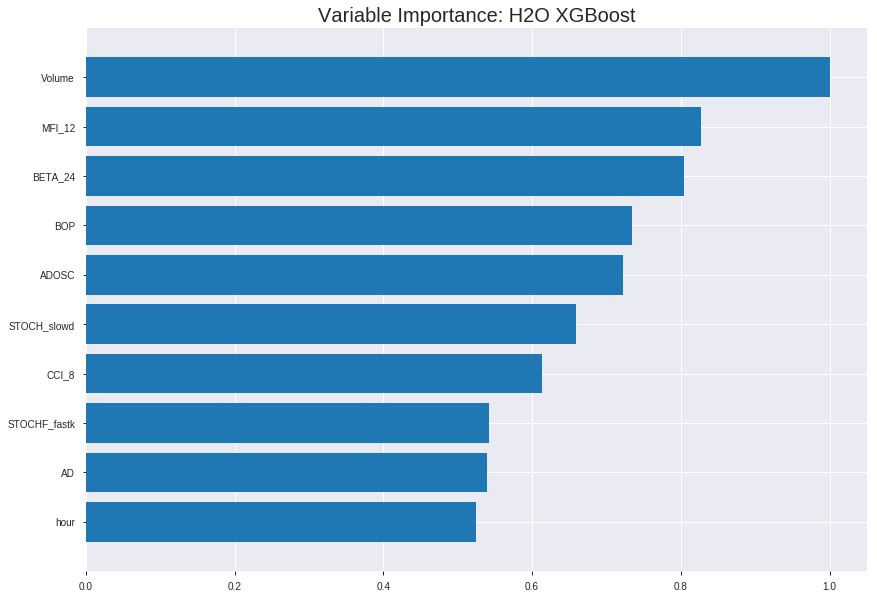

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_185019_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17910814627227267
RMSE: 0.42321170384604523
LogLoss: 0.5470269319974902
Mean Per-Class Error: 0.1326950240189122
AUC: 0.937062712573135
pr_auc: 0.931926863471498
Gini: 0.87412542514627
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4797263989845912: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      677  116  0.1463   (116.0/793.0)
1      92   674  0.1201   (92.0/766.0)
Total  769  790  0.1334   (208.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479726     0.866324  208
max f2                       0.429715     0.90898   256
max f0point5                 0.503258     0.882436  187
max accuracy                 0.481524     0.867223  206
max precision                0.805282     1         0
max recall                   0.351525     1         333
max specificity              0.805282     1         0
max absolute_mcc             0.481524     0.734504  206
max min_per_class_accuracy   0.482781     0.865069  205
max mean_per_class_accuracy  0.481524     0.867305  206

Gains/Lift Table: Avg response rate: 49.13 %, avg score: 49.06 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.733198           2.03525    2.03525            1                0.757556  1                           0.757556            0.0208877       0.0208877                  103.525   103.525
    2        0.020526                    0.716406           2.03525    2.03525            1                0.723423  1                           0.74049             0.0208877       0.0417755                  103.525   103.525
    3        0.0301475                   0.702306           2.03525    2.03525            1                0.708703  1                           0.730345            0.0195822       0.0613577                  103.525   103.525
    4        0.0404105                   0.690379           2.03525    2.03525            1                0.695525  1                           0.721502            0.0208877       0.0822454                  103.525   103.525
    5        0.0500321                   0.684556           1.89956    2.00916            0.933333         0.687576  0.987179                    0.714978            0.0182768       0.100522                   89.9565   100.916
    6        0.100064                    0.645804           2.03525    2.0222             1                0.663397  0.99359                     0.689187            0.101828        0.20235                    103.525   102.22
    7        0.150096                    0.618379           1.98306    2.00916            0.974359         0.631149  0.987179                    0.669841            0.0992167       0.301567                   98.3062   100.916
    8        0.200128                    0.597959           1.93088    1.98959            0.948718         0.607956  0.977564                    0.65437             0.0966057       0.398172                   93.0876   98.9585
    9        0.300192                    0.559962           1.81346    1.93088            0.891026         0.578359  0.948718                    0.629033            0.181462        0.579634                   81.3458   93.0876
    10       0.400257                    0.519513           1.64385    1.85912            0.807692         0.540464  0.913462                    0.606891            0.164491        0.744125                   64.3854   85.9121
    11       0.500321                    0.480514           1.31769    1.75084            0.647436         0.499398  0.860256                    0.585392            0.131854        0.875979                   31.7693   75.0835
    12       0.599743                    0.448816           0.577748   1.55637            0.283871         0.464902  0.764706                    0.565418            0.0574413       0.93342                    -42.2252  55.6366
    13       0.699808                    0.418724           0.482719   1.40285            0.237179         0.435035  0.689276                    0.546775            0.0483029       0.981723                   -51.7281  40.2847
    14       0.799872                    0.387699           0.143511   1.2453             0.0705128        0.403559  0.611868                    0.528858            0.0143603       0.996084                   -85.6489  24.5304
    15       0.899936                    0.348977           0.0391394  1.11119            0.0192308        0.368918  0.545973                    0.511075            0.00391645      1                          -96.0861  11.119
    16       1                           0.16865            0          1                  0                0.306544  0.491341                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2562902996454911
RMSE: 0.5062512218706154
LogLoss: 0.7064113795723738
Mean Per-Class Error: 0.4640846203346203
AUC: 0.5086369851994852
pr_auc: 0.5135921252199063
Gini: 0.017273970398970384
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29696354269981384: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    221  0.9955   (221.0/222.0)
1      0    224  0        (0.0/224.0)
Total  1    445  0.4955   (221.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.296964     0.669656   398
max f2                       0.296964     0.835198   398
max f0point5                 0.296964     0.558882   398
max accuracy                 0.51819      0.535874   195
max precision                0.736894     0.666667   2
max recall                   0.296964     1          398
max specificity              0.751742     0.995495   0
max absolute_mcc             0.51819      0.0718416  195
max min_per_class_accuracy   0.515647     0.531532   200
max mean_per_class_accuracy  0.51819      0.535915   195

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 51.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.726709           1.19464   1.19464            0.6              0.737563  0.6                         0.737563            0.0133929       0.0133929                  19.4643    19.4643
    2        0.0201794                   0.710938           0.497768  0.884921           0.25             0.722797  0.444444                    0.731001            0.00446429      0.0178571                  -50.2232   -11.5079
    3        0.0313901                   0.69116            1.59286   1.13776            0.8              0.699712  0.571429                    0.719826            0.0178571       0.0357143                  59.2857    13.7755
    4        0.0403587                   0.668744           0.995536  1.10615            0.5              0.684311  0.555556                    0.711934            0.00892857      0.0446429                  -0.446429  10.6151
    5        0.0515695                   0.660472           1.19464   1.12539            0.6              0.663373  0.565217                    0.701377            0.0133929       0.0580357                  19.4643    12.5388
    6        0.100897                    0.621729           1.08604   1.10615            0.545455         0.638978  0.555556                    0.670871            0.0535714       0.111607                   8.6039     10.6151
    7        0.150224                    0.600524           1.08604   1.09955            0.545455         0.610878  0.552239                    0.651172            0.0535714       0.165179                   8.6039     9.95469
    8        0.201794                    0.581088           0.605978  0.973413           0.304348         0.590757  0.488889                    0.635732            0.03125         0.196429                   -39.4022   -2.65873
    9        0.300448                    0.552786           1.04079   0.995536           0.522727         0.566464  0.5                         0.612987            0.102679        0.299107                   4.07873    -0.446429
    10       0.401345                    0.532004           1.0619    1.01222            0.533333         0.541109  0.50838                     0.594917            0.107143        0.40625                    6.19048    1.22207
    11       0.5                         0.515788           1.26705   1.0625             0.636364         0.523333  0.533632                    0.580793            0.125           0.53125                    26.7045    6.25
    12       0.600897                    0.498009           0.796429  1.01782            0.4              0.506145  0.511194                    0.568259            0.0803571       0.611607                   -20.3571   1.78238
    13       0.699552                    0.477543           0.950284  1.0083             0.477273         0.487279  0.50641                     0.556839            0.09375         0.705357                   -4.97159   0.829899
    14       0.800448                    0.451561           0.796429  0.981593           0.4              0.464866  0.492997                    0.545246            0.0803571       0.785714                   -20.3571   -1.84074
    15       0.899103                    0.421633           0.995536  0.983123           0.5              0.435318  0.493766                    0.533184            0.0982143       0.883929                   -0.446429  -1.68774
    16       1                           0.279567           1.1504    1                  0.577778         0.37072   0.502242                


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:50:43  7.221 sec   0                  0.5              0.693147            0.5             0                  1                0.508659                         0.5                0.693147              0.5               0                    1                  0.497758
    2019-08-27 18:50:44  8.411 sec   5                  0.490533         0.674351            0.74246         0.721879           1.78084          0.334189                         0.500313           0.693756              0.488196          0.514109             1.70663            0.495516
    2019-08-27 18:50:45  8.792 sec   10                 0.480514         0.654731            0.807525        0.800388           2.03525          0.277101                         0.502462           0.698084              0.484496          0.512816             1.59286            0.493274
    2019-08-27 18:50:45  9.125 sec   15                 0.473593         0.641295            0.831029        0.822158           1.90805          0.245029                         0.503525           0.700234              0.469082          0.501208             1.19464            0.484305
    2019-08-27 18:50:45  9.468 sec   20                 0.466081         0.626888            0.857625        0.850121           2.03525          0.234766                         0.503855           0.700887              0.47247           0.504464             1.19464            0.484305
    2019-08-27 18:50:46  9.826 sec   25                 0.460204         0.615633            0.870926        0.865315           2.03525          0.225144                         0.503806           0.700828              0.48164           0.514156             1.19464            0.486547
    2019-08-27 18:50:46  10.192 sec  30                 0.45186          0.599838            0.88957         0.884551           2.03525          0.191148                         0.504484           0.702278              0.486999          0.50775              1.19464            0.488789
    2019-08-27 18:50:46  10.550 sec  35                 0.445076         0.587195            0.907099        0.904219           2.03525          0.173188                         0.505175           0.703815              0.497225          0.502401             1.19464            0.493274
    2019-08-27 18:50:47  10.950 sec  40                 0.435294         0.569126            0.922204        0.91849            2.03525          0.156511                         0.505906           0.705523              0.500804          0.502822             0.398214           0.488789
    2019-08-27 18:50:47  11.314 sec  45                 0.430014         0.559371            0.928877        0.925803           2.03525          0.144965                         0.505309           0.704323              0.505731          0.509738             0.796429           0.491031
    2019-08-27 18:50:47  11.700 sec  50                 0.423212         0.547027            0.937063        0.931927           2.03525          0.133419                         0.506251           0.706411              0.508637          0.513592             1.19464            0.495516

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
Volume                   100.91877746582031     1.0                   0.019957073641207478
MFI_12                   83.41743469238281      0.8265799169102603    0.016496116272121226
BETA_24                  81.22138977050781      0.8048193984317368    0.016061840002374473
BOP                      74.10399627685547      0.734293440107847     0.014654348258487876
ADOSC                    72.93819427490234      0.7227415561945885    0.014423806460536296
---                      ---                    ---                   ---
BBANDS_upperband_8_6_3   1.7105522155761719     0.016949791292859354  0.00033826823303469145
ATR_14                   1.3303203582763672     0.013182089514777633  0.0002630759311914062
BBANDS_lowerband_12_0_2  1.2017345428466797     0.011907937977683978  0.0002376475951355704
BBANDS_lowerband_8_5_5   0.9610309600830078     0.009522816112278953  0.00019004754242442817
BBANDS_upperband_12_1_4  0.8545150756835938     0.00846735461072153   0.0001689836195123873


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5874439461883408)

('F1', 0.6105919003115265)

('auc', 0.5436734693877551)

('logloss', 0.7091094363819704)

('mean_per_class_error', 0.4363265306122449)

('rmse', 0.5075627370213801)

('mse', 0.25761993201263467)

xgboost prediction progress: |████████████████████████████████████████████| 100%


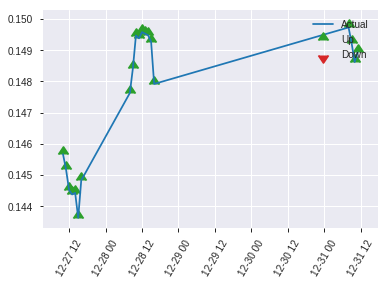


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25761993201263467
RMSE: 0.5075627370213801
LogLoss: 0.7091094363819704
Mean Per-Class Error: 0.4363265306122449
AUC: 0.5436734693877551
pr_auc: 0.47663651517216094
Gini: 0.08734693877551014
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35146042704582214: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    125  1        (125.0/125.0)
1      0    98   0        (0.0/98.0)
Total  0    223  0.5605   (125.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.35146      0.610592  222
max f2                       0.35146      0.796748  222
max f0point5                 0.549089     0.502008  99
max accuracy                 0.586725     0.587444  65
max precision                0.736699     1         0
max recall                   0.35146      1         222
max specificity              0.736699     1         0
max absolute_mcc             0.586725     0.138463  65
max min_per_class_accuracy   0.541183     0.530612  108
max mean_per_class_accuracy  0.586725     0.563673  65

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 54.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.712345           1.51701   1.51701            0.666667         0.723704  0.666667                    0.723704            0.0204082       0.0204082                  51.7007   51.7007
    2        0.0224215                   0.705932           0         0.910204           0                0.709306  0.4                         0.717945            0               0.0204082                  -100      -8.97959
    3        0.0313901                   0.694117           1.13776   0.975219           0.5              0.701161  0.428571                    0.71315             0.0102041       0.0306122                  13.7755   -2.47813
    4        0.0403587                   0.686089           1.13776   1.01134            0.5              0.690707  0.444444                    0.708162            0.0102041       0.0408163                  13.7755   1.13379
    5        0.0538117                   0.677027           2.27551   1.32738            1                0.682481  0.583333                    0.701742            0.0306122       0.0714286                  127.551   32.7381
    6        0.103139                    0.649317           1.03432   1.18722            0.454545         0.664724  0.521739                    0.684038            0.0510204       0.122449                   3.43228   18.7223
    7        0.152466                    0.627152           1.24119   1.20468            0.545455         0.632986  0.529412                    0.667521            0.0612245       0.183673                   24.1187   20.4682
    8        0.201794                    0.613558           0.620594  1.0619             0.272727         0.622051  0.466667                    0.656406            0.0306122       0.214286                   -37.9406  6.19048
    9        0.300448                    0.586088           1.55148   1.22266            0.681818         0.59871   0.537313                    0.637461            0.153061        0.367347                   55.1484   22.2662
    10       0.399103                    0.560893           0.827458  1.12497            0.363636         0.572168  0.494382                    0.621321            0.0816327       0.44898                    -17.2542  12.4971
    11       0.502242                    0.536626           0.791482  1.05649            0.347826         0.5479    0.464286                    0.606244            0.0816327       0.530612                   -20.8518  5.64869
    12       0.600897                    0.513101           1.03432   1.05285            0.454545         0.525167  0.462687                    0.592933            0.102041        0.632653                   3.43228   5.2848
    13       0.699552                    0.496763           1.03432   1.05024            0.454545         0.504217  0.461538                    0.580421            0.102041        0.734694                   3.43228   5.02355
    14       0.798206                    0.469639           0.724026  1.00992            0.318182         0.481407  0.44382                     0.568184            0.0714286       0.806122                   -27.5974  0.991745
    15       0.896861                    0.435582           0.827458  0.989847           0.363636         0.45259   0.435                       0.555468            0.0816327       0.887755                   -17.2542  -1.01531
    16       1                           0.35146            1.08829   1                  0.478261         0.408881  0.439462                    0.54035       

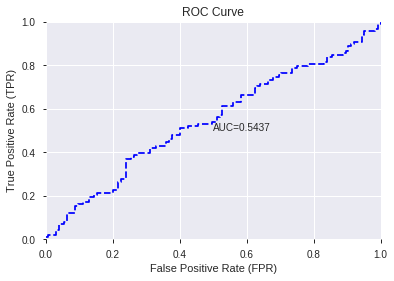

This function is available for GLM models only


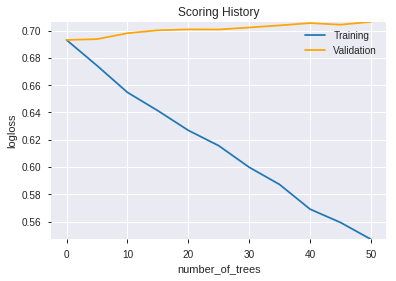

--2019-08-27 18:51:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.147.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.147.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_185019_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_185019_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_85f7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_185123_model_3  0.553224  0.746055              0.451020  0.515509  0.265749
1  DeepLearning_grid_1_AutoML_20190827_185123_model_6  0.535347  0.695690              0.482204  0.501214  0.251216
2  DeepLearning_grid_1_AutoML_20190827_185123_model_2  0.521469  0.854271              0.496000  0.546215  0.298351
3  DeepLearning_grid_1_AutoML_20190827_185123_model_7  0.520000  1.119467              0.470204  0.571376  0.326471
4  DeepLearning_grid_1_AutoML_20190827_185123_model_9  0.513143  0.695331              0.496000  0.501061  0.251062
5  DeepLearning_grid_1_AutoML_20190827_185123_model_5  0.512245  0.711256              0.500000  0.507329  0.257383
6  DeepLearning_grid_1_AutoML_20190827_185123_model_8  0.505143  0.710599              0.500000  0.508593  0.258667
7  DeepLearning_grid_1_AutoML_20190827_185123_model_1  0.494694  0.978909              0.484000  0.577821  0.333877
8               DeepLearning_1_AutoML_20190827_185123  0.492163  0.786686              0.496000  0.537589  0.289002
9  DeepLearning_grid_1_AutoML_20190827_185123_model_4  0.492000  0.869106              0.480000  0.554285  0.307232

variable  relative_importance  scaled_importance  percentage
0        CDLMORNINGDOJISTAR             1.000000           1.000000    0.053286
1               CDLPIERCING             0.895623           0.895623    0.047724
2                  CORREL_8             0.695899           0.695899    0.037082
3           CDLADVANCEBLOCK             0.448368           0.448368    0.023892
4                      hour             0.435520           0.435520    0.023207
5                       BOP             0.430419           0.430419    0.022935
6              weekday_name             0.407039           0.407039    0.021689
7                aroonup_20             0.400873           0.400873    0.021361
8              aroondown_14             0.393274           0.393274    0.020956
9                aroonup_24             0.391740           0.391740    0.020874
10                aroonup_8             0.391175           0.391175    0.020844
11              aroondown_8             0.389179           0.389179    0.020738
12                CORREL_30             0.382499           0.382499    0.020382
13               aroonup_14             0.382161           0.382161    0.020364
14               aroonup_30             0.377757           0.377757    0.020129
15                      day             0.369188           0.369188    0.019672
16               aroonup_12             0.365186           0.365186    0.019459
17                     DX_8             0.364348           0.364348    0.019415
18                    CCI_8             0.364201           0.364201    0.019407
19                  ADXR_12             0.360738           0.360738    0.019222
20             aroondown_20             0.359732           0.359732    0.019169
21             aroondown_12             0.358231           0.358231    0.019089
22                dayofyear             0.350708           0.350708    0.018688
23                   MFI_20             0.350370           0.350370    0.018670
24                   ADX_20             0.345768           0.345768    0.018425
25  BBANDS_lowerband_14_6_3             0.344170           0.344170    0.018339
26                  BETA_24             0.340801           0.340801    0.018160
27             aroondown_24             0.337985           0.337985    0.018010
28                  NATR_24             0.335851           0.335851    0.017896
29               PLUS_DI_30             0.334427           0.334427    0.017820
30                   VAR_14             0.333055           0.333055    0.017747
31              AROONOSC_30             0.332782           0.332782    0.017733
32                  NATR_12             0.331087           0.331087    0.017642
33                 WILLR_12             0.326174           0.326174    0.017380
34                     week             0.324247           0.324247    0.017278
35                STDDEV_12             0.324156           0.324156    0.017273
36                   ULTOSC             0.315666           0.315666    0.016821
37                    DX_24             0.315126           0.315126    0.016792
38                STDDEV_30             0.310618           0.310618    0.016551
39              AROONOSC_24             0.304450           0.304450    0.016223
40                 WILLR_20             0.304295           0.304295    0.016215
41        LINEARREG_ANGLE_8             0.300118           0.300118    0.015992
42                CORREL_24             0.298973           0.298973    0.015931
43              MINUS_DI_20             0.294249           0.294249    0.015679
44                   CMO_30             0.293278           0.293278    0.015628
45                  ROCP_24             0.284879           0.284879    0.015180
46                      APO             0.284653           0.284653    0.015168
47                   MOM_24             0.271864           0.271864    0.014486
48                  TRIX_14             0.260246           0.260246    0.013867
49                 

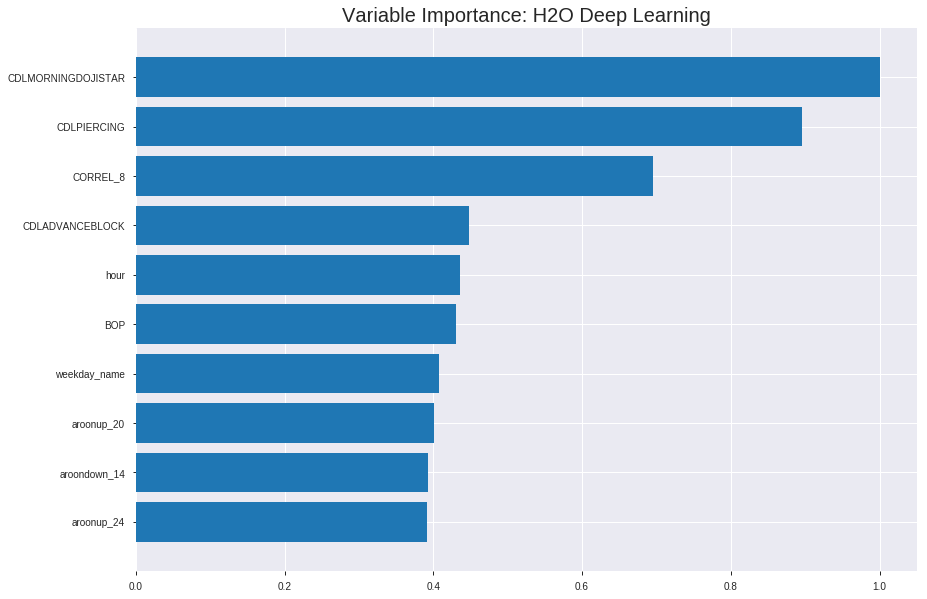

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_185123_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23221067091366032
RMSE: 0.4818824243668369
LogLoss: 0.6640527446010387
Mean Per-Class Error: 0.3625036629252697
AUC: 0.6717343992308681
pr_auc: 0.6461884053430229
Gini: 0.34346879846173617
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38834462341438164: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      220  573   0.7226   (573.0/793.0)
1      86   680   0.1123   (86.0/766.0)
Total  306  1253  0.4227   (659.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.388345     0.673601  285
max f2                       0.0147833    0.828466  399
max f0point5                 0.509103     0.629362  209
max accuracy                 0.509103     0.636305  209
max precision                0.977483     1         0
max recall                   0.0147833    1         399
max specificity              0.977483     1         0
max absolute_mcc             0.509103     0.277408  209
max min_per_class_accuracy   0.54357      0.627937  187
max mean_per_class_accuracy  0.509103     0.637496  209

Gains/Lift Table: Avg response rate: 49.13 %, avg score: 52.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.91317            1.65364   1.65364            0.8125           0.943662  0.8125                      0.943662            0.0169713       0.0169713                  65.3639   65.3639
    2        0.020526                    0.867261           1.65364   1.65364            0.8125           0.888578  0.8125                      0.91612             0.0169713       0.0339426                  65.3639   65.3639
    3        0.0301475                   0.842534           1.35683   1.55891            0.666667         0.850782  0.765957                    0.895267            0.0130548       0.0469974                  35.6832   55.8913
    4        0.0404105                   0.810985           1.78084   1.61528            0.875            0.823721  0.793651                    0.877097            0.0182768       0.0652742                  78.0842   61.5276
    5        0.0500321                   0.790674           1.6282    1.61776            0.8              0.800029  0.794872                    0.862276            0.0156658       0.0809399                  62.8198   61.7761
    6        0.100064                    0.734276           1.30465   1.4612             0.641026         0.758677  0.717949                    0.810477            0.0652742       0.146214                   30.4646   46.1204
    7        0.150096                    0.699088           1.22637   1.38292            0.602564         0.715931  0.679487                    0.778961            0.0613577       0.207572                   22.6367   38.2925
    8        0.200128                    0.673638           1.40902   1.38945            0.692308         0.685034  0.682692                    0.75548             0.0704961       0.278068                   40.9018   38.9448
    9        0.300192                    0.634526           1.31769   1.36553            0.647436         0.654529  0.67094                     0.721829            0.131854        0.409922                   31.7693   36.553
    10       0.400257                    0.581074           1.22637   1.33074            0.602564         0.607395  0.653846                    0.693221            0.122715        0.532637                   22.6367   33.0739
    11       0.500321                    0.541024           0.991531  1.2629             0.487179         0.560912  0.620513                    0.666759            0.0992167       0.631854                   -0.84689  26.2898
    12       0.599743                    0.491528           1.01106   1.22115            0.496774         0.516225  0.6                         0.641804            0.100522        0.732376                   1.10587   22.1149
    13       0.699808                    0.442948           0.821927  1.16406            0.403846         0.471537  0.571952                    0.617458            0.0822454       0.814621                   -17.8073  16.4065
    14       0.799872                    0.388728           0.678416  1.10331            0.333333         0.417223  0.542101                    0.592409            0.0678851       0.882507                   -32.1584  10.331
    15       0.899936                    0.29298            0.587091  1.04591            0.288462         0.347024  0.513899                    0.565124            0.0587467       0.941253                   -41.2909  4.59115
    16       1                           0.0147833          0.587091  1                  0.288462         0.193311  0.491341                    0.527919           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2746413565698598
RMSE: 0.5240623594285891
LogLoss: 0.7626515382224028
Mean Per-Class Error: 0.45475386100386106
AUC: 0.5347289253539254
pr_auc: 0.5475385213910183
Gini: 0.06945785070785071
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.041769869698313256: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    222  1        (222.0/222.0)
1      0    224  0        (0.0/224.0)
Total  0    446  0.4978   (222.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0417699    0.668657  399
max f2                       0.0417699    0.834575  399
max f0point5                 0.210736     0.563341  346
max accuracy                 0.496222     0.544843  161
max precision                0.856044     1         0
max recall                   0.0417699    1         399
max specificity              0.856044     1         0
max absolute_mcc             0.756967     0.12571   6
max min_per_class_accuracy   0.456314     0.527027  198
max mean_per_class_accuracy  0.496222     0.545246  161

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 43.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.783277           1.99107   1.99107            1                0.807705  1                           0.807705            0.0223214       0.0223214                  99.1071    99.1071
    2        0.0201794                   0.746532           1.4933    1.76984            0.75             0.760756  0.888889                    0.786838            0.0133929       0.0357143                  49.3304    76.9841
    3        0.0313901                   0.72946            0.796429  1.42219            0.4              0.739317  0.714286                    0.769867            0.00892857      0.0446429                  -20.3571   42.2194
    4        0.0403587                   0.719068           0.995536  1.32738            0.5              0.725108  0.666667                    0.75992             0.00892857      0.0535714                  -0.446429  32.7381
    5        0.0515695                   0.712261           0.796429  1.21196            0.4              0.714511  0.608696                    0.750049            0.00892857      0.0625                     -20.3571   21.1957
    6        0.100897                    0.664526           1.08604   1.1504             0.545455         0.685839  0.577778                    0.718657            0.0535714       0.116071                   8.6039     15.0397
    7        0.150224                    0.625184           0.995536  1.09955            0.5              0.643608  0.552239                    0.694014            0.0491071       0.165179                   -0.446429  9.95469
    8        0.201794                    0.587159           1.12539   1.10615            0.565217         0.606837  0.555556                    0.671735            0.0580357       0.223214                   12.5388    10.6151
    9        0.300448                    0.538034           1.04079   1.08469            0.522727         0.562927  0.544776                    0.636007            0.102679        0.325893                   4.07873    8.46882
    10       0.401345                    0.497656           1.1504    1.10121            0.577778         0.516937  0.553073                    0.606073            0.116071        0.441964                   15.0397    10.1207
    11       0.5                         0.456991           0.859781  1.05357            0.431818         0.480149  0.529148                    0.581227            0.0848214       0.526786                   -14.0219   5.35714
    12       0.600897                    0.413979           0.884921  1.02525            0.444444         0.436505  0.514925                    0.556927            0.0892857       0.616071                   -11.5079   2.52532
    13       0.699552                    0.346164           0.814529  0.995536           0.409091         0.382281  0.5                         0.532297            0.0803571       0.696429                   -18.5471   -0.446429
    14       0.800448                    0.255718           1.19464   1.02063            0.6              0.303586  0.512605                    0.503468            0.120536        0.816964                   19.4643    2.06333
    15       0.899103                    0.181635           0.905032  1.00795            0.454545         0.227445  0.506234                    0.473181            0.0892857       0.90625                    -9.49675   0.794888
    16       1                           0.0417699          0.929167  1                  0.466667         0.126011  0.502242                 


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:53:00  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 18:53:03  1 min 38.332 sec  5886 obs/sec      8.78576   1             13697      0.525665         0.797241            -0.105625      0.566866        0.553532           1.27203          0.507377                         0.533572           0.805017              -0.138818        0.508858          0.514462             1.19464            0.484305
    2019-08-27 18:53:08  1 min 43.910 sec  6981 obs/sec      35.0988   4             54719      0.481882         0.664053            0.0708786      0.671734        0.646188           1.65364          0.422707                         0.524062           0.762652              -0.0985875       0.534729          0.547539             1.99107            0.497758
    2019-08-27 18:53:14  1 min 49.885 sec  7959 obs/sec      70.1758   8             109404     0.459857         0.624426            0.153872       0.730282        0.711432           1.78084          0.351507                         0.534504           0.790227              -0.1428          0.51101           0.524319             1.19464            0.495516
    2019-08-27 18:53:19  1 min 55.137 sec  8669 obs/sec      105.272   12            164119     0.434538         0.579223            0.244479       0.791775        0.778521           1.78084          0.304041                         0.542383           0.842453              -0.176743        0.534799          0.544199             1.59286            0.493274
    2019-08-27 18:53:26  2 min  1.235 sec  9316 obs/sec      149.142   17            232513     0.414652         0.536004            0.312048       0.82731         0.821381           1.90805          0.268121                         0.552282           0.883964              -0.220088        0.522704          0.525754             1.59286            0.497758
    2019-08-27 18:53:31  2 min  6.885 sec  9851 obs/sec      192.994   22            300878     0.396128         0.500156            0.372141       0.858067        0.847447           1.90805          0.216164                         0.556458           0.894921              -0.238608        0.527097          0.527817             1.59286            0.495516
    2019-08-27 18:53:31  2 min  6.960 sec  9849 obs/sec      192.994   22            300878     0.481882         0.664053            0.0708786      0.671734        0.646188           1.65364          0.422707                         0.524062           0.762652              -0.0985875       0.534729          0.547539             1.99107            0.497758

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLMORNINGDOJISTAR  1.0                    1.0                  0.053285745183961404
CDLPIERCING         0.8956228494644165     0.8956228494644165   0.04772393093749432
CORREL_8            0.695899248123169      0.695899248123169    0.03708151000920151
CDLADVANCEBLOCK     0.4483675956726074     0.4483675956726074   0.023891601451755996
hour                0.43551966547966003    0.43551966547966003  0.023206989917353274
---                 ---                    ---                  ---
ROCP_24             0.2848794162273407     0.2848794162273407   0.015180011981245755
APO                 0.2846534252166748     0.2846534252166748   0.015167969881837547
MOM_24              0.2718639075756073     0.2718639075756073   0.014486470903789845
TRIX_14             0.2602463364601135     0.2602463364601135   0.013867419969673092
CMO_20              0.2535991966724396     0.2535991966724396   0.013513222172744928


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5829596412556054)

('F1', 0.6153846153846153)

('auc', 0.5532244897959183)

('logloss', 0.7460546019411024)

('mean_per_class_error', 0.441469387755102)

('rmse', 0.5155087073893685)

('mse', 0.2657492273942575)

deeplearning prediction progress: |███████████████████████████████████████| 100%


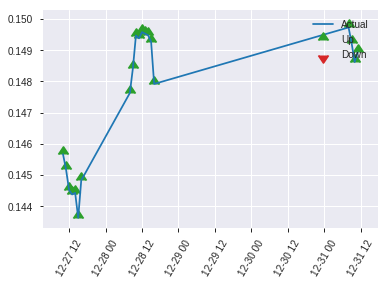


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2657492273942575
RMSE: 0.5155087073893685
LogLoss: 0.7460546019411024
Mean Per-Class Error: 0.441469387755102
AUC: 0.5532244897959183
pr_auc: 0.4919691589613785
Gini: 0.10644897959183663
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17619779635461508: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      25   100  0.8      (100.0/125.0)
1      10   88   0.102    (10.0/98.0)
Total  35   188  0.4933   (110.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.176198     0.615385  187
max f2                       0.0487205    0.796748  222
max f0point5                 0.186501     0.520581  181
max accuracy                 0.612366     0.58296   24
max precision                0.813503     1         0
max recall                   0.0487205    1         222
max specificity              0.813503     1         0
max absolute_mcc             0.763678     0.152634  3
max min_per_class_accuracy   0.390043     0.544     110
max mean_per_class_accuracy  0.34332      0.558531  130

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 38.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.794182           2.27551   2.27551            1                0.807592   1                           0.807592            0.0306122       0.0306122                  127.551   127.551
    2        0.0224215                   0.752081           1.13776   1.82041            0.5              0.758626   0.8                         0.788005            0.0102041       0.0408163                  13.7755   82.0408
    3        0.0313901                   0.73445            1.13776   1.62536            0.5              0.74983    0.714286                    0.777098            0.0102041       0.0510204                  13.7755   62.5364
    4        0.0403587                   0.71456            0         1.26417            0                0.722431   0.555556                    0.76495             0               0.0510204                  -100      26.4172
    5        0.0538117                   0.66728            1.51701   1.32738            0.666667         0.690886   0.583333                    0.746434            0.0204082       0.0714286                  51.7007   32.7381
    6        0.103139                    0.619185           1.24119   1.28616            0.545455         0.638879   0.565217                    0.694995            0.0612245       0.132653                   24.1187   28.6158
    7        0.152466                    0.587071           0.827458  1.13776            0.363636         0.597731   0.5                         0.663527            0.0408163       0.173469                   -17.2542  13.7755
    8        0.201794                    0.567015           1.03432   1.11247            0.454545         0.577114   0.488889                    0.642404            0.0510204       0.22449                    3.43228   11.2472
    9        0.300448                    0.511491           1.03432   1.08681            0.454545         0.533784   0.477612                    0.606738            0.102041        0.326531                   3.43228   8.68108
    10       0.399103                    0.465628           1.13776   1.0994             0.5              0.490092   0.483146                    0.577904            0.112245        0.438776                   13.7755   9.94038
    11       0.502242                    0.388987           1.08829   1.09712            0.478261         0.433654   0.482143                    0.548281            0.112245        0.55102                    8.82875   9.7121
    12       0.600897                    0.336095           1.13776   1.10379            0.5              0.3579     0.485075                    0.517025            0.112245        0.663265                   13.7755   10.3792
    13       0.699552                    0.259979           0.620594  1.03565            0.272727         0.309665   0.455128                    0.487782            0.0612245       0.72449                    -37.9406  3.56489
    14       0.798206                    0.18897            1.24119   1.06105            0.545455         0.22548    0.466292                    0.455362            0.122449        0.846939                   24.1187   6.10525
    15       0.896861                    0.125386           0.724026  1.02398            0.318182         0.164751   0.45                        0.423395            0.0714286       0.918367                   -27.5974  2.39796
    16       1                           0.0487205          0.791482  1                  0.347826         0.0926373  0.439462                    

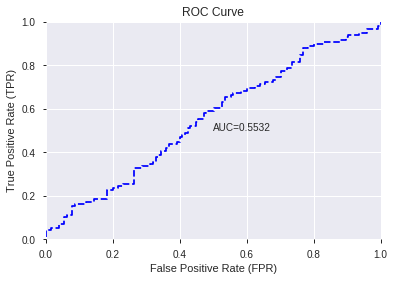

This function is available for GLM models only


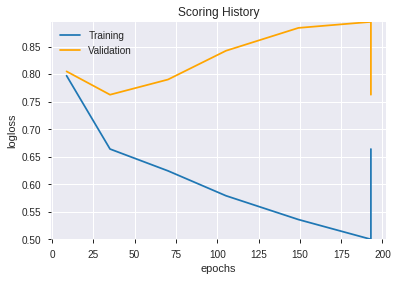

--2019-08-27 19:00:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.144.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.144.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_185123_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_185123_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_85f7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLMORNINGDOJISTAR',
 'CDLPIERCING',
 'CORREL_8',
 'CDLADVANCEBLOCK',
 'hour',
 'BOP',
 'weekday_name',
 'aroonup_20',
 'aroondown_14',
 'aroonup_24',
 'aroonup_8',
 'aroondown_8',
 'CORREL_30',
 'aroonup_14',
 'aroonup_30',
 'day',
 'aroonup_12',
 'DX_8',
 'CCI_8',
 'ADXR_12',
 'aroondown_20',
 'aroondown_12',
 'dayofyear',
 'MFI_20',
 'ADX_20',
 'BBANDS_lowerband_14_6_3',
 'BETA_24',
 'aroondown_24',
 'NATR_24',
 'PLUS_DI_30',
 'VAR_14',
 'AROONOSC_30',
 'NATR_12',
 'WILLR_12',
 'week',
 'STDDEV_12',
 'ULTOSC',
 'DX_24',
 'STDDEV_30',
 'AROONOSC_24',
 'WILLR_20',
 'LINEARREG_ANGLE_8',
 'CORREL_24',
 'MINUS_DI_20',
 'CMO_30',
 'ROCP_24',
 'APO',
 'MOM_24',
 'TRIX_14',
 'CMO_20']

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_190023_model_1  0.515184  0.69375                   0.5  0.500301  0.250301

variable  relative_importance  scaled_importance  percentage
0         LINEARREG_ANGLE_8             0.008592           1.000000    0.052115
1        CDLMORNINGDOJISTAR             0.007796           0.907378    0.047288
2              weekday_name             0.007596           0.884089    0.046074
3                aroonup_12             0.007129           0.829713    0.043241
4   BBANDS_lowerband_14_6_3             0.006981           0.812505    0.042344
5                    ULTOSC             0.006812           0.792824    0.041318
6                  WILLR_12             0.006607           0.768962    0.040075
7                      week             0.006509           0.757549    0.039480
8                 dayofyear             0.006369           0.741221    0.038629
9                  CORREL_8             0.006285           0.731523    0.038123
10                     hour             0.006182           0.719523    0.037498
11                aroonup_8             0.005628           0.655013    0.034136
12               aroonup_30             0.005355           0.623198    0.032478
13                 WILLR_20             0.005130           0.597104    0.031118
14              AROONOSC_30             0.004733           0.550852    0.028708
15                STDDEV_12             0.004414           0.513776    0.026776
16                      day             0.004154           0.483426    0.025194
17                  ROCP_24             0.003767           0.438470    0.022851
18                   MOM_24             0.003715           0.432345    0.022532
19             aroondown_20             0.003714           0.432199    0.022524
20               aroonup_24             0.003646           0.424337    0.022114
21             aroondown_12             0.003588           0.417537    0.021760
22                    DX_24             0.003393           0.394875    0.020579
23              AROONOSC_24             0.003259           0.379331    0.019769
24                CORREL_30             0.003208           0.373391    0.019459
25                  ADXR_12             0.003125           0.363665    0.018952
26                     DX_8             0.002864           0.333323    0.017371
27                      APO             0.002835           0.329912    0.017193
28              MINUS_DI_20             0.002518           0.293028    0.015271
29             aroondown_24             0.002078           0.241860    0.012605
30                      BOP             0.001901           0.221269    0.011531
31                  TRIX_14             0.001842           0.214323    0.011169
32               aroonup_14             0.001814           0.211117    0.011002
33             aroondown_14             0.001680           0.195528    0.010190
34               aroonup_20             0.001481           0.172364    0.008983
35                CORREL_24             0.001400           0.162979    0.008494
36                    CCI_8             0.001249           0.145357    0.007575
37               PLUS_DI_30             0.001024           0.119198    0.006212
38                   VAR_14             0.000896           0.104319    0.005437
39                   CMO_20             0.000782           0.091058    0.004746
40          CDLADVANCEBLOCK             0.000576           0.066988    0.003491
41                STDDEV_30             0.000536           0.062389    0.003251
42                   CMO_30             0.000431           0.050212    0.002617
43                   MFI_20             0.000360           0.041879    0.002183
44                  BETA_24             0.000238           0.027694    0.001443
45              aroondown_8             0.000198           0.023063    0.001202
46                   ADX_20             0.000194           0.022560    0.001176
47              CDLPIERCING             0.000128           0.014945    0.000779
48                  NATR_12             0.000094           0.010933    0.000570
49                 

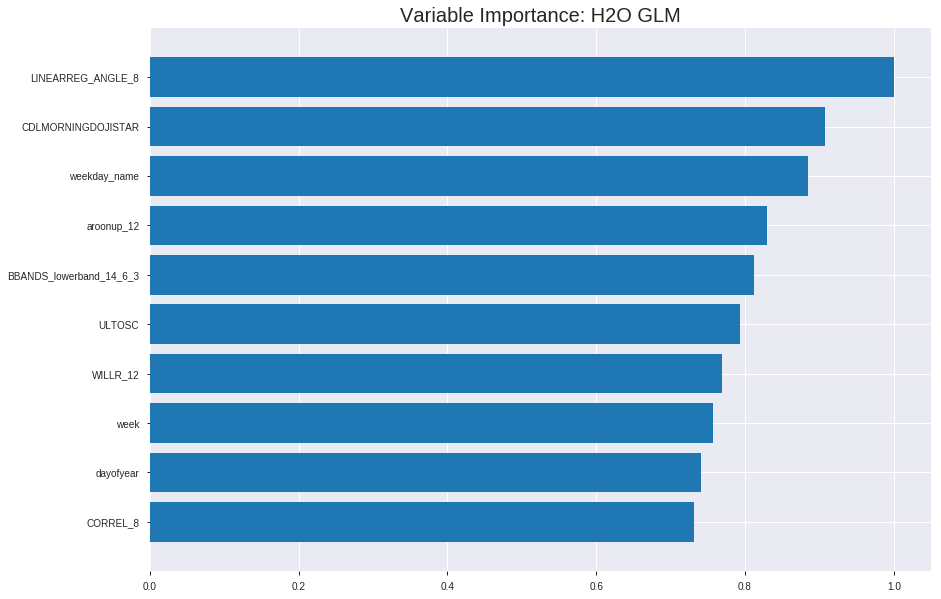

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_190023_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24877401030538787
RMSE: 0.49877250355787245
LogLoss: 0.6906937924921996
Null degrees of freedom: 1558
Residual degrees of freedom: 1508
Null deviance: 2160.7652781666966
Residual deviance: 2153.583244990679
AIC: 2255.583244990679
AUC: 0.5677764644292915
pr_auc: 0.5611908723706764
Gini: 0.13555292885858305
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4709701750190357: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      15   778   0.9811   (778.0/793.0)
1      5    761   0.0065   (5.0/766.0)
Total  20   1539  0.5022   (783.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.47097      0.660304  384
max f2                       0.466536     0.828466  399
max f0point5                 0.484856     0.561206  278
max accuracy                 0.497719     0.554201  128
max precision                0.533413     1         0
max recall                   0.466536     1         399
max specificity              0.533413     1         0
max absolute_mcc             0.499369     0.11737   112
max min_per_class_accuracy   0.491423     0.533943  201
max mean_per_class_accuracy  0.48791      0.553215  242

Gains/Lift Table: Avg response rate: 49.13 %, avg score: 49.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.519637           1.39923   1.39923            0.6875           0.523459  0.6875                      0.523459            0.0143603       0.0143603                  39.9233   39.9233
    2        0.020526                    0.513653           1.39923   1.39923            0.6875           0.516285  0.6875                      0.519872            0.0143603       0.0287206                  39.9233   39.9233
    3        0.0301475                   0.510492           1.49252   1.429              0.733333         0.511879  0.702128                    0.517321            0.0143603       0.0430809                  49.2515   42.9004
    4        0.0404105                   0.508263           1.52644   1.45375            0.75             0.509319  0.714286                    0.515289            0.0156658       0.0587467                  52.6436   45.3749
    5        0.0500321                   0.507372           1.22115   1.40902            0.6              0.507909  0.692308                    0.513869            0.0117493       0.0704961                  22.1149   40.9018
    6        0.100064                    0.503449           1.122     1.26551            0.551282         0.505292  0.621795                    0.509581            0.0561358       0.126632                   12.1996   26.5507
    7        0.150096                    0.500854           1.14809   1.22637            0.564103         0.50203   0.602564                    0.507064            0.0574413       0.184073                   14.8089   22.6367
    8        0.200128                    0.499082           1.22637   1.22637            0.602564         0.499898  0.602564                    0.505273            0.0613577       0.245431                   22.6367   22.6367
    9        0.300192                    0.496194           0.926299  1.12634            0.455128         0.497528  0.553419                    0.502691            0.0926893       0.33812                    -7.37012  12.6345
    10       0.400257                    0.493664           1.00458   1.0959             0.49359          0.494822  0.538462                    0.500724            0.100522        0.438642                   0.457756  9.59028
    11       0.500321                    0.491346           0.978485  1.07242            0.480769         0.492464  0.526923                    0.499072            0.0979112       0.536554                   -2.15154  7.24192
    12       0.599743                    0.488613           1.07671   1.07313            0.529032         0.490024  0.527273                    0.497572            0.10705         0.643603                   7.67119   7.31308
    13       0.699808                    0.486145           1.03067   1.06706            0.50641          0.487318  0.52429                     0.496106            0.103133        0.746736                   3.06705   6.70595
    14       0.799872                    0.483371           0.900206  1.04619            0.442308         0.484941  0.514034                    0.494709            0.0900783       0.836815                   -9.97941  4.6186
    15       0.899936                    0.478398           0.834974  1.0227             0.410256         0.481134  0.502495                    0.4932              0.0835509       0.920366                   -16.5026  2.27013
    16       1                           0.466536           0.795834  1                  0.391026         0.47462   0.491341                    0.491341          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25022900061818343
RMSE: 0.5002289482009047
LogLoss: 0.6936054151488494
Null degrees of freedom: 445
Residual degrees of freedom: 395
Null deviance: 618.4903607498804
Residual deviance: 618.6960303127737
AIC: 720.6960303127737
AUC: 0.49251930501930496
pr_auc: 0.5057897193434175
Gini: -0.01496138996139007
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48151731539967246: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    216  0.973    (216.0/222.0)
1      2    222  0.0089   (2.0/224.0)
Total  8    438  0.4888   (218.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.481517     0.670695  392
max f2                       0.477488     0.834575  399
max f0point5                 0.481517     0.561741  392
max accuracy                 0.506811     0.526906  83
max precision                0.511019     0.608696  44
max recall                   0.477488     1         399
max specificity              0.52066      0.995495  0
max absolute_mcc             0.492131     0.105111  304
max min_per_class_accuracy   0.499472     0.5       198
max mean_per_class_accuracy  0.506811     0.528274  83

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 49.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.51767            0.398214  0.398214           0.2              0.519309  0.2                         0.519309            0.00446429      0.00446429                 -60.1786  -60.1786
    2        0.0201794                   0.51522            1.4933    0.884921           0.75             0.516588  0.444444                    0.518099            0.0133929       0.0178571                  49.3304   -11.5079
    3        0.0313901                   0.514947           0.398214  0.711097           0.2              0.515099  0.357143                    0.517028            0.00446429      0.0223214                  -60.1786  -28.8903
    4        0.0403587                   0.514294           1.99107   0.995536           1                0.514677  0.5                         0.516505            0.0178571       0.0401786                  99.1071   -0.446429
    5        0.0515695                   0.513662           1.19464   1.03882            0.6              0.513883  0.521739                    0.515935            0.0133929       0.0535714                  19.4643   3.88199
    6        0.100897                    0.511105           1.35755   1.19464            0.681818         0.512339  0.6                         0.514177            0.0669643       0.120536                   35.7549   19.4643
    7        0.150224                    0.508762           1.08604   1.15898            0.545455         0.509859  0.58209                     0.512759            0.0535714       0.174107                   8.6039    15.8982
    8        0.201794                    0.506634           1.03882   1.12827            0.521739         0.507619  0.566667                    0.511445            0.0535714       0.227679                   3.88199   12.8274
    9        0.300448                    0.503826           0.814529  1.02525            0.409091         0.505356  0.514925                    0.509446            0.0803571       0.308036                   -18.5471  2.52532
    10       0.401345                    0.50106            0.884921  0.989974           0.444444         0.502315  0.497207                    0.507653            0.0892857       0.397321                   -11.5079  -1.00259
    11       0.5                         0.499385           1.04079   1                  0.522727         0.500239  0.502242                    0.50619             0.102679        0.5                        4.07873   0
    12       0.600897                    0.496743           0.796429  0.965818           0.4              0.498077  0.485075                    0.504828            0.0803571       0.580357                   -20.3571  -3.41818
    13       0.699552                    0.494766           0.859781  0.950864           0.431818         0.495799  0.477564                    0.503555            0.0848214       0.665179                   -14.0219  -4.91358
    14       0.800448                    0.491581           0.973413  0.953706           0.488889         0.493017  0.478992                    0.502226            0.0982143       0.763393                   -2.65873  -4.62935
    15       0.899103                    0.486583           1.26705   0.988088           0.636364         0.48917   0.496259                    0.500794            0.125           0.888393                   26.7045   -1.19122
    16       1                           0.477488           1.10615   1                  0.555556         0.483607  0.502242                    0.49906      


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 19:00:23  0.000 sec   2            2.5       51            1.38139           1.38721
    2019-08-27 19:00:23  0.011 sec   4            1.5       51            1.37941           1.38783
    2019-08-27 19:00:23  0.024 sec   6            0.96      51            1.37692           1.38893
    2019-08-27 19:00:23  0.036 sec   8            0.6       51            1.37393           1.39067
    2019-08-27 19:00:23  0.048 sec   10           0.37      51            1.37053           1.39306

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5695067264573991)

('F1', 0.6105919003115265)

('auc', 0.5151836734693878)

('logloss', 0.6937498703065718)

('mean_per_class_error', 0.4573061224489796)

('rmse', 0.5003010831019944)

('mse', 0.2503011737530287)

glm prediction progress: |████████████████████████████████████████████████| 100%


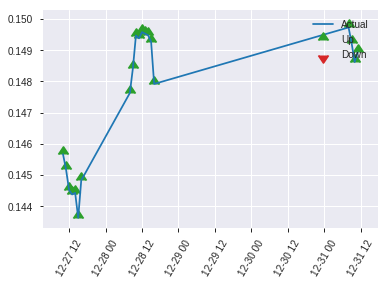


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2503011737530287
RMSE: 0.5003010831019944
LogLoss: 0.6937498703065718
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 308.275230921901
Residual deviance: 309.412442156731
AIC: 411.412442156731
AUC: 0.5151836734693878
pr_auc: 0.46032670279380283
Gini: 0.03036734693877552
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47951218803257983: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    125  1        (125.0/125.0)
1      0    98   0        (0.0/98.0)
Total  0    223  0.5605   (125.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479512     0.610592  222
max f2                       0.479512     0.796748  222
max f0point5                 0.479512     0.494949  222
max accuracy                 0.518702     0.569507  5
max precision                0.521519     0.666667  2
max recall                   0.479512     1         222
max specificity              0.522037     0.992     0
max absolute_mcc             0.488576     0.133148  202
max min_per_class_accuracy   0.502929     0.520408  105
max mean_per_class_accuracy  0.504076     0.542694  93

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 50.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.521207           1.51701   1.51701            0.666667         0.521745  0.666667                    0.521745            0.0204082       0.0204082                  51.7007   51.7007
    2        0.0224215                   0.519352           1.13776   1.36531            0.5              0.51998   0.6                         0.521039            0.0102041       0.0306122                  13.7755   36.5306
    3        0.0313901                   0.518301           1.13776   1.30029            0.5              0.518662  0.571429                    0.52036             0.0102041       0.0408163                  13.7755   30.0292
    4        0.0403587                   0.517579           1.13776   1.26417            0.5              0.518115  0.555556                    0.519861            0.0102041       0.0510204                  13.7755   26.4172
    5        0.0538117                   0.517179           0.758503  1.13776            0.333333         0.517387  0.5                         0.519242            0.0102041       0.0612245                  -24.1497  13.7755
    6        0.103139                    0.515689           0.827458  0.989352           0.363636         0.516228  0.434783                    0.517801            0.0408163       0.102041                   -17.2542  -1.06477
    7        0.152466                    0.51347            1.44805   1.13776            0.636364         0.514618  0.5                         0.516771            0.0714286       0.173469                   44.8052   13.7755
    8        0.201794                    0.511738           1.03432   1.11247            0.454545         0.512463  0.488889                    0.515718            0.0510204       0.22449                    3.43228   11.2472
    9        0.300448                    0.507977           1.03432   1.08681            0.454545         0.510234  0.477612                    0.513917            0.102041        0.326531                   3.43228   8.68108
    10       0.399103                    0.505027           1.03432   1.07384            0.454545         0.506548  0.47191                     0.512096            0.102041        0.428571                   3.43228   7.38363
    11       0.502242                    0.502252           0.890417  1.03617            0.391304         0.503348  0.455357                    0.510299            0.0918367       0.520408                   -10.9583  3.61698
    12       0.600897                    0.500093           1.03432   1.03587            0.454545         0.501173  0.455224                    0.508801            0.102041        0.622449                   3.43228   3.58666
    13       0.699552                    0.497802           0.724026  0.991889           0.318182         0.49896   0.435897                    0.507413            0.0714286       0.693878                   -27.5974  -0.811094
    14       0.798206                    0.494614           0.930891  0.98435            0.409091         0.496105  0.432584                    0.506015            0.0918367       0.785714                   -6.91095  -1.56501
    15       0.896861                    0.489102           0.827458  0.967092           0.363636         0.492131  0.425                       0.504488            0.0816327       0.867347                   -17.2542  -3.29082
    16       1                           0.479512           1.28616   1                  0.565217         0.485077  0.439462                    0.502486    

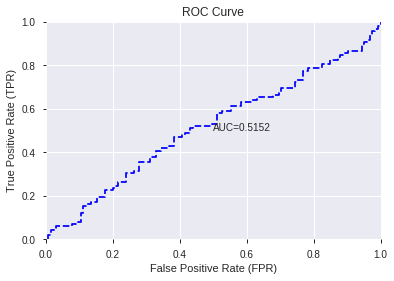

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


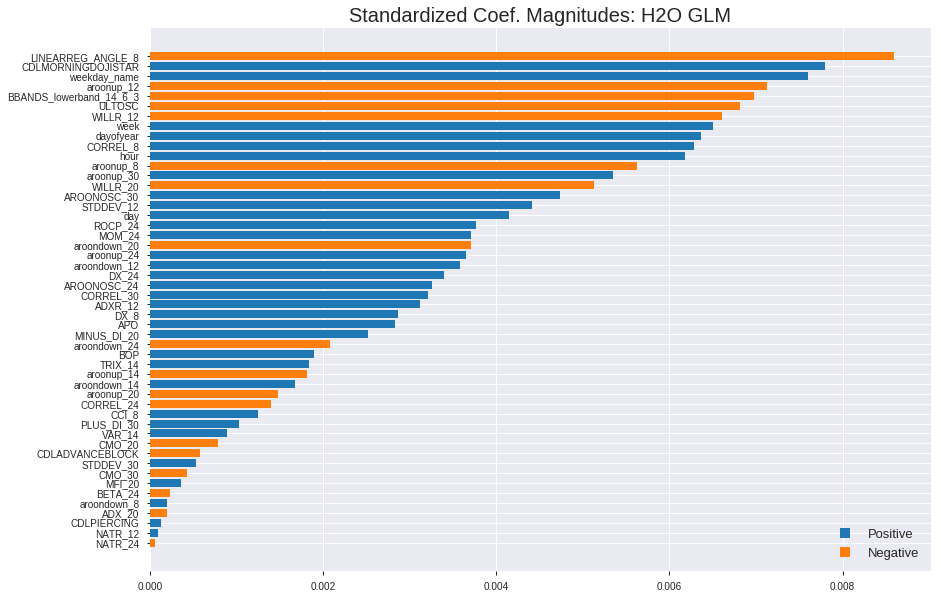

'log_likelihood'
--2019-08-27 19:00:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.137.52
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.137.52|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_190023_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_190023_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_85f7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['LINEARREG_ANGLE_8',
 'CDLMORNINGDOJISTAR',
 'weekday_name',
 'aroonup_12',
 'BBANDS_lowerband_14_6_3',
 'ULTOSC',
 'WILLR_12',
 'week',
 'dayofyear',
 'CORREL_8',
 'hour',
 'aroonup_8',
 'aroonup_30',
 'WILLR_20',
 'AROONOSC_30',
 'STDDEV_12',
 'day',
 'ROCP_24',
 'MOM_24',
 'aroondown_20',
 'aroonup_24',
 'aroondown_12',
 'DX_24',
 'AROONOSC_24',
 'CORREL_30',
 'ADXR_12',
 'DX_8',
 'APO',
 'MINUS_DI_20',
 'aroondown_24',
 'BOP',
 'TRIX_14',
 'aroonup_14',
 'aroondown_14',
 'aroonup_20',
 'CORREL_24',
 'CCI_8',
 'PLUS_DI_30',
 'VAR_14',
 'CMO_20',
 'CDLADVANCEBLOCK',
 'STDDEV_30',
 'CMO_30',
 'MFI_20',
 'BETA_24',
 'aroondown_8',
 'ADX_20',
 'CDLPIERCING',
 'NATR_12',
 'NATR_24']

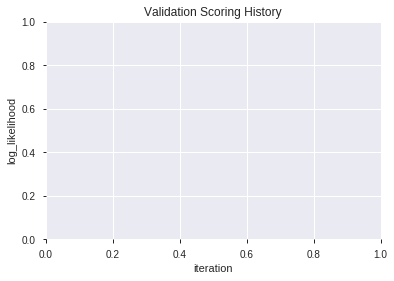

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_190035_model_4  0.540082  0.704649                 0.500  0.505632  0.255664
1  XGBoost_grid_1_AutoML_20190827_190035_model_2  0.526449  0.706334                 0.484  0.506498  0.256540
2  XGBoost_grid_1_AutoML_20190827_190035_model_5  0.520653  0.756325                 0.500  0.526777  0.277494
3  XGBoost_grid_1_AutoML_20190827_190035_model_3  0.518449  0.715375                 0.500  0.510585  0.260697
4               XGBoost_2_AutoML_20190827_190035  0.514122  0.713957                 0.500  0.510008  0.260108
5  XGBoost_grid_1_AutoML_20190827_190035_model_6  0.513388  0.718774                 0.500  0.512192  0.262341
6  XGBoost_grid_1_AutoML_20190827_190035_model_7  0.513224  0.715924                 0.500  0.510664  0.260778
7               XGBoost_1_AutoML_20190827_190035  0.511755  0.725733                 0.500  0.515097  0.265325
8               XGBoost_3_AutoML_20190827_190035  0.503510  0.717095                 0.500  0.511361  0.261490
9  XGBoost_grid_1_AutoML_20190827_190035_model_1  0.495673  0.717829                 0.500  0.511563  0.261697

variable  relative_importance  scaled_importance  percentage
0   BBANDS_lowerband_14_6_3           144.288239           1.000000    0.060178
1                  WILLR_12           138.110519           0.957185    0.057602
2         LINEARREG_ANGLE_8           107.379768           0.744203    0.044785
3                   BETA_24           101.744804           0.705150    0.042435
4                     CCI_8            95.141891           0.659388    0.039681
5                   TRIX_14            88.161423           0.611009    0.036769
6                    MFI_20            78.165688           0.541733    0.032601
7                       day            77.564438           0.537566    0.032350
8                       BOP            76.966698           0.533423    0.032100
9                  WILLR_20            76.142532           0.527711    0.031757
10                      APO            75.149292           0.520828    0.031343
11                     DX_8            74.282562           0.514821    0.030981
12              MINUS_DI_20            72.948280           0.505573    0.030425
13                     hour            71.882294           0.498185    0.029980
14               aroonup_24            64.856880           0.449495    0.027050
15                STDDEV_12            59.165184           0.410049    0.024676
16                dayofyear            57.267876           0.396899    0.023885
17                   ULTOSC            57.026108           0.395224    0.023784
18               aroonup_12            56.724621           0.393134    0.023658
19             weekday_name            53.350632           0.369750    0.022251
20                  NATR_24            52.884041           0.366517    0.022056
21              AROONOSC_30            50.975704           0.353291    0.021260
22                  NATR_12            49.391773           0.342313    0.020600
23              AROONOSC_24            48.839615           0.338486    0.020370
24                aroonup_8            48.607174           0.336876    0.020273
25             aroondown_20            45.052448           0.312239    0.018790
26                   MOM_24            44.571407           0.308905    0.018589
27                  ADXR_12            41.814060           0.289795    0.017439
28               aroonup_30            39.749126           0.275484    0.016578
29                STDDEV_30            37.061058           0.256854    0.015457
30                   ADX_20            35.329552           0.244854    0.014735
31               aroonup_14            30.134464           0.208849    0.012568
32                   CMO_30            28.022324           0.194211    0.011687
33               PLUS_DI_30            27.814081           0.192767    0.011600
34               aroonup_20            26.216917           0.181698    0.010934
35                   CMO_20            26.138382           0.181154    0.010902
36             aroondown_14            22.549337           0.156280    0.009405
37              aroondown_8            22.265942           0.154316    0.009286
38                   VAR_14            21.538010           0.149271    0.008983
39                  ROCP_24            19.995869           0.138583    0.008340
40             aroondown_24            17.457661           0.120992    0.007281
41                    DX_24            15.568031           0.107895    0.006493
42             aroondown_12            14.874922           0.103092    0.006204
43                CORREL_30             4.508331           0.031245    0.001880

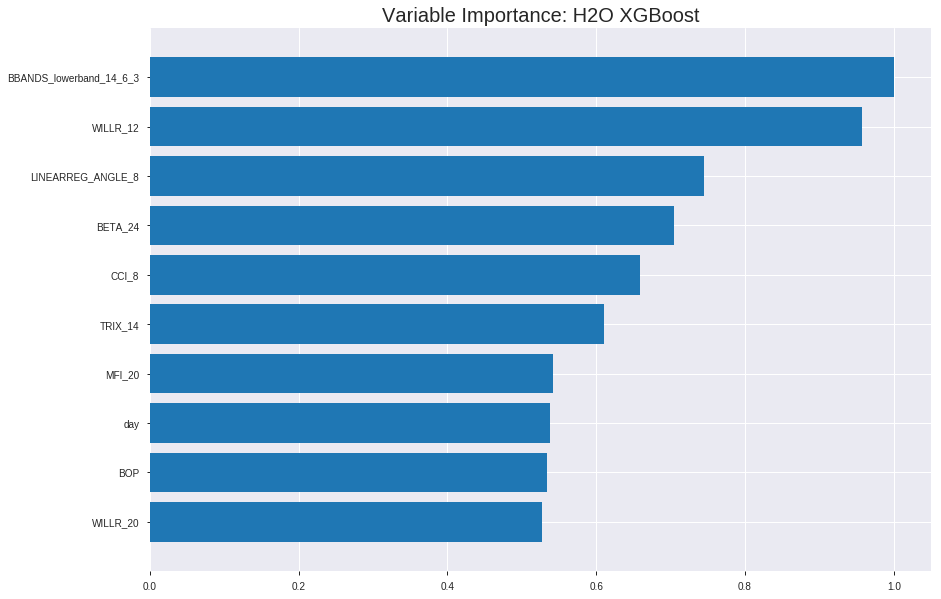

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_190035_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2205839573295014
RMSE: 0.46966366405067084
LogLoss: 0.6334831626223637
Mean Per-Class Error: 0.28346679002630726
AUC: 0.7805866606962356
pr_auc: 0.7770184037561518
Gini: 0.5611733213924712
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45555024594068527: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      397  396   0.4994   (396.0/793.0)
1      104  662   0.1358   (104.0/766.0)
Total  501  1058  0.3207   (500.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.45555      0.725877  251
max f2                       0.40132      0.837649  327
max f0point5                 0.519653     0.717306  150
max accuracy                 0.49142      0.716485  192
max precision                0.668003     1         0
max recall                   0.314119     1         395
max specificity              0.668003     1         0
max absolute_mcc             0.49142      0.433002  192
max min_per_class_accuracy   0.491973     0.713745  191
max mean_per_class_accuracy  0.49142      0.716533  192

Gains/Lift Table: Avg response rate: 49.13 %, avg score: 49.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.638783           2.03525   2.03525            1                0.647914  1                           0.647914            0.0208877       0.0208877                  103.525   103.525
    2        0.020526                    0.62794            2.03525   2.03525            1                0.633448  1                           0.640681            0.0208877       0.0417755                  103.525   103.525
    3        0.0301475                   0.619067           1.89956   1.99194            0.933333         0.622455  0.978723                    0.634864            0.0182768       0.0600522                  89.9565   99.1945
    4        0.0404105                   0.613539           1.65364   1.90603            0.8125           0.616796  0.936508                    0.630275            0.0169713       0.0770235                  65.3639   90.6026
    5        0.0500321                   0.607172           1.89956   1.90478            0.933333         0.611268  0.935897                    0.62662             0.0182768       0.0953003                  89.9565   90.4783
    6        0.100064                    0.585972           1.8265    1.86564            0.897436         0.596636  0.916667                    0.611628            0.0913838       0.186684                   82.6505   86.5644
    7        0.150096                    0.569422           1.72213   1.81781            0.846154         0.576641  0.893162                    0.599966            0.0861619       0.272846                   72.2133   81.7807
    8        0.200128                    0.555181           1.43511   1.72213            0.705128         0.561526  0.846154                    0.590356            0.0718016       0.344648                   43.5111   72.2133
    9        0.300192                    0.532343           1.36988   1.60471            0.673077         0.544166  0.788462                    0.574959            0.137076        0.481723                   36.9878   60.4715
    10       0.400257                    0.511312           1.22637   1.51013            0.602564         0.522397  0.741987                    0.561819            0.122715        0.604439                   22.6367   51.0128
    11       0.500321                    0.490874           1.16114   1.44033            0.570513         0.500548  0.707692                    0.549565            0.116188        0.720627                   16.1135   44.0329
    12       0.599743                    0.470489           0.774707  1.32999            0.380645         0.480323  0.653476                    0.538086            0.0770235       0.79765                    -22.5293  32.9986
    13       0.699808                    0.450212           0.782788  1.25174            0.384615         0.460397  0.615032                    0.526977            0.078329        0.875979                   -21.7212  25.1743
    14       0.799872                    0.426217           0.587091  1.16859            0.288462         0.438191  0.574178                    0.51587             0.0587467       0.934726                   -41.2909  16.8595
    15       0.899936                    0.395962           0.378347  1.08073            0.185897         0.411806  0.531005                    0.504299            0.037859        0.972585                   -62.1653  8.07269
    16       1                           0.278488           0.273976  1                  0.134615         0.369031  0.491341                    0.490764         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25094838343401904
RMSE: 0.5009474857048581
LogLoss: 0.6950684127004331
Mean Per-Class Error: 0.4534467503217503
AUC: 0.5253881113256113
pr_auc: 0.5192385625959661
Gini: 0.0507762226512225
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38908082246780396: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      17   205  0.9234   (205.0/222.0)
1      5    219  0.0223   (5.0/224.0)
Total  22   424  0.4709   (210.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.389081     0.675926  377
max f2                       0.302744     0.834575  399
max f0point5                 0.415493     0.576497  349
max accuracy                 0.472743     0.547085  245
max precision                0.639315     0.75      3
max recall                   0.302744     1         399
max specificity              0.668059     0.995495  0
max absolute_mcc             0.415493     0.135479  349
max min_per_class_accuracy   0.495215     0.504464  199
max mean_per_class_accuracy  0.472743     0.546553  245

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 49.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.624921           1.19464   1.19464            0.6              0.648915  0.6                         0.648915            0.0133929       0.0133929                  19.4643    19.4643
    2        0.0201794                   0.620058           1.4933    1.32738            0.75             0.621842  0.666667                    0.636883            0.0133929       0.0267857                  49.3304    32.7381
    3        0.0313901                   0.613588           0.796429  1.13776            0.4              0.61616   0.571429                    0.629482            0.00892857      0.0357143                  -20.3571   13.7755
    4        0.0403587                   0.609601           1.4933    1.21677            0.75             0.611559  0.611111                    0.625499            0.0133929       0.0491071                  49.3304    21.6766
    5        0.0515695                   0.604368           1.59286   1.29852            0.8              0.607897  0.652174                    0.621672            0.0178571       0.0669643                  59.2857    29.8525
    6        0.100897                    0.581799           0.905032  1.10615            0.454545         0.590312  0.555556                    0.606341            0.0446429       0.111607                   -9.49675   10.6151
    7        0.150224                    0.566064           0.633523  0.950959           0.318182         0.57339   0.477612                    0.595521            0.03125         0.142857                   -36.6477   -4.90405
    8        0.201794                    0.555551           1.03882   0.973413           0.521739         0.560363  0.488889                    0.586536            0.0535714       0.196429                   3.88199    -2.65873
    9        0.300448                    0.536257           1.04079   0.995536           0.522727         0.545579  0.5                         0.573088            0.102679        0.299107                   4.07873    -0.446429
    10       0.401345                    0.514924           1.0619    1.01222            0.533333         0.525889  0.50838                     0.561222            0.107143        0.40625                    6.19048    1.22207
    11       0.5                         0.494763           0.995536  1.00893            0.5              0.505072  0.506726                    0.550143            0.0982143       0.504464                   -0.446429  0.892857
    12       0.600897                    0.477124           1.28313   1.05497            0.644444         0.484779  0.529851                    0.539168            0.129464        0.633929                   28.3135    5.49707
    13       0.699552                    0.459009           0.905032  1.03383            0.454545         0.46873   0.519231                    0.529234            0.0892857       0.723214                   -9.49675   3.38255
    14       0.800448                    0.433915           1.0619    1.03736            0.533333         0.447354  0.521008                    0.518913            0.107143        0.830357                   6.19048    3.73649
    15       0.899103                    0.410618           1.04079   1.03774            0.522727         0.423456  0.521197                    0.508439            0.102679        0.933036                   4.07873    3.77405
    16       1                           0.302744           0.66369   1                  0.333333         0.382737  0.502242               


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 19:00:42  2.613 sec   0                  0.5              0.693147            0.5             0                  1                0.508659                         0.5                0.693147              0.5               0                    1                  0.497758
    2019-08-27 19:00:43  2.715 sec   5                  0.496235         0.685639            0.654238        0.631924           1.27203          0.431046                         0.499928           0.693003              0.50543           0.499029             1.19464            0.488789
    2019-08-27 19:00:43  2.770 sec   10                 0.492527         0.678286            0.695168        0.680797           1.79581          0.423348                         0.499618           0.692382              0.520331          0.510676             1.59286            0.495516
    2019-08-27 19:00:43  2.823 sec   15                 0.489078         0.671474            0.715345        0.699796           1.90805          0.386786                         0.49889            0.690929              0.540983          0.519894             0.398214           0.493274
    2019-08-27 19:00:43  2.881 sec   20                 0.485254         0.663958            0.73707         0.732904           1.90805          0.356639                         0.498842           0.690823              0.531049          0.520554             1.19464            0.493274
    2019-08-27 19:00:43  2.944 sec   25                 0.482516         0.658583            0.743507        0.739585           1.90805          0.341886                         0.499061           0.69124               0.526273          0.52551              1.59286            0.470852
    2019-08-27 19:00:43  3.005 sec   30                 0.479927         0.653487            0.743726        0.74011            1.90805          0.372675                         0.499175           0.691462              0.529631          0.527616             1.59286            0.475336
    2019-08-27 19:00:43  3.072 sec   35                 0.47668          0.647144            0.758052        0.753258           2.03525          0.36177                          0.500439           0.693996              0.51838           0.517433             1.19464            0.486547
    2019-08-27 19:00:43  3.138 sec   40                 0.474218         0.642355            0.768893        0.76671            2.03525          0.309173                         0.500821           0.694783              0.518068          0.514611             1.59286            0.488789
    2019-08-27 19:00:43  3.201 sec   45                 0.471749         0.637544            0.775994        0.772977           2.03525          0.319436                         0.500802           0.694755              0.523608          0.516869             1.59286            0.473094
    2019-08-27 19:00:43  3.271 sec   50                 0.469664         0.633483            0.780587        0.777018           2.03525          0.320718                         0.500947           0.695068              0.525388          0.519239             1.19464            0.470852

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
BBANDS_lowerband_14_6_3  144.28823852539062     1.0                   0.06017827277238903
WILLR_12                 138.1105194091797      0.9571848739762401    0.05760173243974699
LINEARREG_ANGLE_8        107.37976837158203     0.7442031968023939    0.044784862975258376
BETA_24                  101.74480438232422     0.7051496741671015    0.04243468943738908
CCI_8                    95.14189147949219      0.6593877120673971    0.03968081359955334
---                      ---                    ---                   ---
ROCP_24                  19.995868682861328     0.13858280402627982   0.008339673782256
aroondown_24             17.457660675048828     0.1209915711319518    0.007281063770738506
DX_24                    15.568031311035156     0.10789535910992236   0.006492956351391778
aroondown_12             14.874921798706055     0.10309171385503117   0.006203881276941143
CORREL_30                4.508330821990967      0.031245310553830268  0.0018802888213664036


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6053811659192825)

('F1', 0.6105919003115265)

('auc', 0.5400816326530612)

('logloss', 0.7046490545258155)

('mean_per_class_error', 0.4188163265306122)

('rmse', 0.5056320577976204)

('mse', 0.25566377787265615)

xgboost prediction progress: |████████████████████████████████████████████| 100%


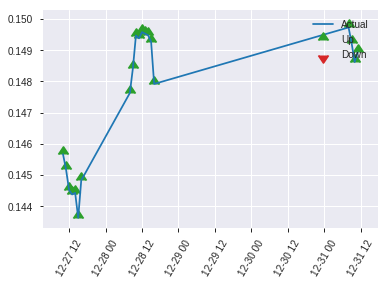


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25566377787265615
RMSE: 0.5056320577976204
LogLoss: 0.7046490545258155
Mean Per-Class Error: 0.4188163265306122
AUC: 0.5400816326530612
pr_auc: 0.5036115546653799
Gini: 0.08016326530612239
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3201974630355835: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    125  1        (125.0/125.0)
1      0    98   0        (0.0/98.0)
Total  0    223  0.5605   (125.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.320197     0.610592  222
max f2                       0.320197     0.796748  222
max f0point5                 0.577321     0.525641  72
max accuracy                 0.592969     0.605381  55
max precision                0.691786     1         0
max recall                   0.320197     1         222
max specificity              0.691786     1         0
max absolute_mcc             0.592969     0.174805  55
max min_per_class_accuracy   0.537712     0.540816  107
max mean_per_class_accuracy  0.577321     0.581184  72

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 53.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.661711           1.51701   1.51701            0.666667         0.675864  0.666667                    0.675864            0.0204082       0.0204082                  51.7007   51.7007
    2        0.0224215                   0.652926           2.27551   1.82041            1                0.655743  0.8                         0.667816            0.0204082       0.0408163                  127.551   82.0408
    3        0.0313901                   0.645678           1.13776   1.62536            0.5              0.648825  0.714286                    0.66239             0.0102041       0.0510204                  13.7755   62.5364
    4        0.0403587                   0.640164           1.13776   1.51701            0.5              0.643263  0.666667                    0.658139            0.0102041       0.0612245                  13.7755   51.7007
    5        0.0538117                   0.637036           1.51701   1.51701            0.666667         0.638469  0.666667                    0.653222            0.0204082       0.0816327                  51.7007   51.7007
    6        0.103139                    0.620633           0.827458  1.18722            0.363636         0.629118  0.521739                    0.641694            0.0408163       0.122449                   -17.2542  18.7223
    7        0.152466                    0.60954            0.827458  1.07083            0.363636         0.615691  0.470588                    0.633281            0.0408163       0.163265                   -17.2542  7.08283
    8        0.201794                    0.6013             1.86178   1.26417            0.818182         0.60413   0.555556                    0.626156            0.0918367       0.255102                   86.1781   26.4172
    9        0.300448                    0.579353           1.24119   1.25663            0.545455         0.59093   0.552239                    0.614589            0.122449        0.377551                   24.1187   25.6625
    10       0.399103                    0.562185           0.930891  1.17611            0.409091         0.570959  0.516854                    0.603804            0.0918367       0.469388                   -6.91095  17.6106
    11       0.502242                    0.533824           0.692547  1.0768             0.304348         0.546623  0.473214                    0.592061            0.0714286       0.540816                   -30.7453  7.68039
    12       0.600897                    0.515983           0.724026  1.01889            0.318182         0.525319  0.447761                    0.581104            0.0714286       0.612245                   -27.5974  1.88852
    13       0.699552                    0.487332           0.620594  0.962716           0.272727         0.499908  0.423077                    0.569653            0.0612245       0.673469                   -37.9406  -3.72841
    14       0.798206                    0.469724           0.930891  0.958782           0.409091         0.477583  0.421348                    0.558274            0.0918367       0.765306                   -6.91095  -4.12176
    15       0.896861                    0.443751           1.24119   0.989847           0.545455         0.457198  0.435                       0.547155            0.122449        0.887755                   24.1187   -1.01531
    16       1                           0.320197           1.08829   1                  0.478261         0.411352  0.439462                    0.533149      

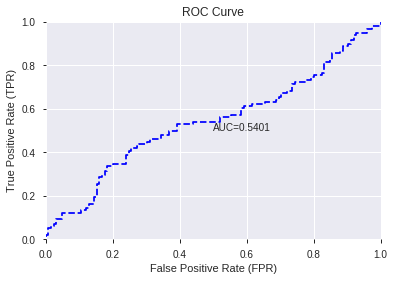

This function is available for GLM models only


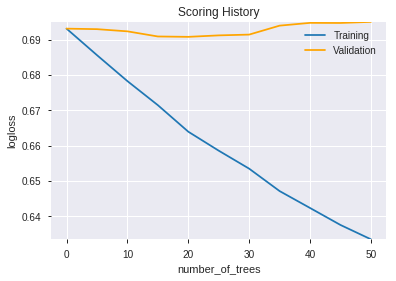

--2019-08-27 19:00:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.115.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.115.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_190035_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_190035_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_85f7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BBANDS_lowerband_14_6_3',
 'WILLR_12',
 'LINEARREG_ANGLE_8',
 'BETA_24',
 'CCI_8',
 'TRIX_14',
 'MFI_20',
 'day',
 'BOP',
 'WILLR_20',
 'APO',
 'DX_8',
 'MINUS_DI_20',
 'hour',
 'aroonup_24',
 'STDDEV_12',
 'dayofyear',
 'ULTOSC',
 'aroonup_12',
 'weekday_name',
 'NATR_24',
 'AROONOSC_30',
 'NATR_12',
 'AROONOSC_24',
 'aroonup_8',
 'aroondown_20',
 'MOM_24',
 'ADXR_12',
 'aroonup_30',
 'STDDEV_30',
 'ADX_20',
 'aroonup_14',
 'CMO_30',
 'PLUS_DI_30',
 'aroonup_20',
 'CMO_20',
 'aroondown_14',
 'aroondown_8',
 'VAR_14',
 'ROCP_24',
 'aroondown_24',
 'DX_24',
 'aroondown_12',
 'CORREL_30']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12  13 896 916 936] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_190102_model_2  0.542776  0.689958              0.484000  0.497878  0.247882
1  DeepLearning_grid_1_AutoML_20190827_190102_model_1  0.542612  1.461648              0.458612  0.604022  0.364842
2  DeepLearning_grid_1_AutoML_20190827_190102_model_5  0.511306  0.691670              0.490204  0.499260  0.249261
3  DeepLearning_grid_1_AutoML_20190827_190102_model_6  0.504735  0.692835              0.483306  0.499844  0.249844
4               DeepLearning_1_AutoML_20190827_190102  0.500735  0.726115              0.500000  0.514932  0.265155
5  DeepLearning_grid_1_AutoML_20190827_190102_model_8  0.500000  0.691839              0.500000  0.499345  0.249346
6  DeepLearning_grid_1_AutoML_20190827_190102_model_3  0.495918  0.735396              0.496000  0.516290  0.266555
7  DeepLearning_grid_1_AutoML_20190827_190102_model_4  0.484735  1.190439              0.496000  0.615375  0.378686
8  DeepLearning_grid_1_AutoML_20190827_190102_model_9  0.453551  0.692921              0.489102  0.499887  0.249887
9  DeepLearning_grid_1_AutoML_20190827_190102_model_7  0.444327  1.095456              0.500000  0.602917  0.363509

variable  relative_importance  scaled_importance  percentage
0                   dayofweek             1.000000           1.000000    0.001474
1                     weekday             0.992211           0.992211    0.001462
2             CDLLADDERBOTTOM             0.963981           0.963981    0.001421
3                 CDLPIERCING             0.950944           0.950944    0.001401
4                CDLTASUKIGAP             0.942267           0.942267    0.001389
...                       ...                  ...                ...         ...
1029  BBANDS_lowerband_24_3_4             0.578554           0.578554    0.000853
1030                   WMA_14             0.574681           0.574681    0.000847
1031                  MA_14_5             0.572395           0.572395    0.000844
1032           CDLHARAMICROSS             0.570357           0.570357    0.000841
1033  BBANDS_middleband_8_1_2             0.554918           0.554918    0.000818

[1034 rows x 4 columns]

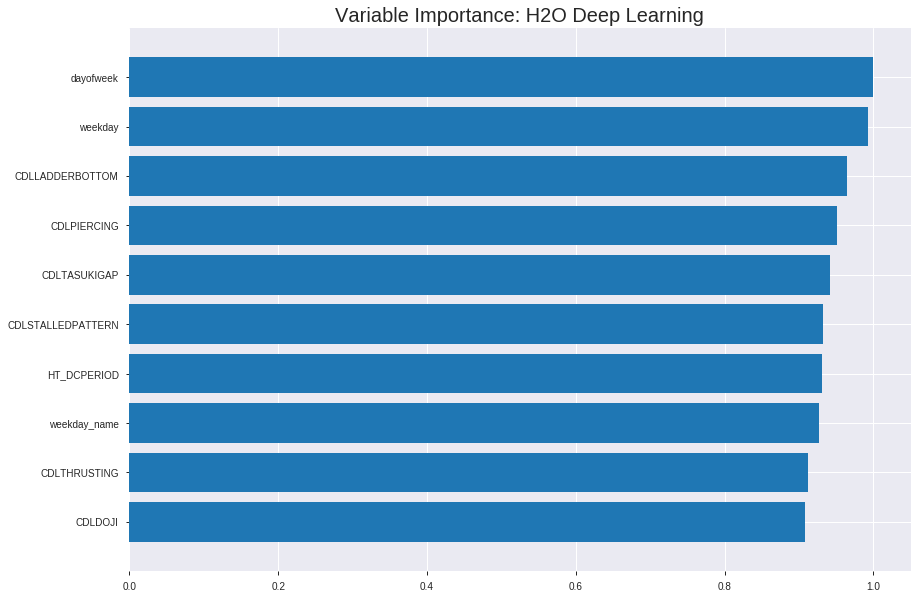

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_190102_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2494963790935551
RMSE: 0.4994961252037448
LogLoss: 0.6927108831129003
Mean Per-Class Error: 0.4483017196816794
AUC: 0.5563242668387556
pr_auc: 0.5494058120500864
Gini: 0.11264853367751115
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2120262320836216: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      3    790   0.9962   (790.0/793.0)
1      0    766   0        (0.0/766.0)
Total  3    1556  0.5067   (790.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.212026     0.659776  396
max f2                       0.212026     0.829004  396
max f0point5                 0.387611     0.548663  307
max accuracy                 0.505764     0.55356   144
max precision                0.820002     1         0
max recall                   0.212026     1         396
max specificity              0.820002     1         0
max absolute_mcc             0.505764     0.110042  144
max min_per_class_accuracy   0.465159     0.551072  202
max mean_per_class_accuracy  0.470937     0.551698  193

Gains/Lift Table: Avg response rate: 49.13 %, avg score: 46.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.6788             1.65364   1.65364            0.8125           0.73648   0.8125                      0.73648             0.0169713       0.0169713                  65.3639   65.3639
    2        0.020526                    0.646368           0.890421  1.27203            0.4375           0.665555  0.625                       0.701018            0.00913838      0.0261097                  -10.9579  27.203
    3        0.0301475                   0.623179           1.22115   1.25579            0.6              0.633511  0.617021                    0.679473            0.0117493       0.037859                   22.1149   25.5791
    4        0.0404105                   0.609847           1.27203   1.25992            0.625            0.614616  0.619048                    0.663001            0.0130548       0.0509138                  27.203    25.9915
    5        0.0500321                   0.597818           1.35683   1.27855            0.666667         0.603232  0.628205                    0.651507            0.0130548       0.0639687                  35.6832   27.8553
    6        0.100064                    0.569165           1.30465   1.2916             0.641026         0.580435  0.634615                    0.615971            0.0652742       0.129243                   30.4646   29.16
    7        0.150096                    0.549195           1.01762   1.20027            0.5              0.558641  0.589744                    0.596861            0.0509138       0.180157                   1.7624    20.0274
    8        0.200128                    0.530536           1.01762   1.15461            0.5              0.539382  0.567308                    0.582491            0.0509138       0.23107                    1.7624    15.4612
    9        0.300192                    0.503118           1.14809   1.15244            0.564103         0.515175  0.566239                    0.560053            0.114883        0.345953                   14.8089   15.2437
    10       0.400257                    0.48222            1.04372   1.12526            0.512821         0.492301  0.552885                    0.543115            0.104439        0.450392                   4.37169   12.5257
    11       0.500321                    0.464894           1.03067   1.10634            0.50641          0.473366  0.54359                     0.529165            0.103133        0.553525                   3.06705   10.634
    12       0.599743                    0.446559           0.82723   1.06007            0.406452         0.455652  0.520856                    0.516978            0.0822454       0.63577                    -17.277   6.00704
    13       0.699808                    0.426509           0.808881  1.02415            0.397436         0.436214  0.503208                    0.50543             0.0809399       0.71671                    -19.1119  2.41532
    14       0.799872                    0.405773           0.991531  1.02007            0.487179         0.416288  0.501203                    0.494278            0.0992167       0.815927                   -0.84689  2.00722
    15       0.899936                    0.377644           0.926299  1.00965            0.455128         0.392675  0.49608                     0.482981            0.0926893       0.908616                   -7.37012  0.96455
    16       1                           0.197959           0.913252  1                  0.448718         0.31358   0.491341                    0.46603             0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.25471086715480823
RMSE: 0.5046888815446683
LogLoss: 0.7031515322485092
Mean Per-Class Error: 0.47172619047619047
AUC: 0.5037805662805662
pr_auc: 0.5134490662457364
Gini: 0.007561132561132444
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27037389348596413: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    220  0.991    (220.0/222.0)
1      1    223  0.0045   (1.0/224.0)
Total  3    443  0.4955   (221.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.270374     0.668666   396
max f2                       0.248442     0.834575   399
max f0point5                 0.384283     0.559349   373
max accuracy                 0.531826     0.526906   78
max precision                0.729177     1          0
max recall                   0.248442     1          399
max specificity              0.729177     1          0
max absolute_mcc             0.317021     0.0790847  390
max min_per_class_accuracy   0.480138     0.486607   194
max mean_per_class_accuracy  0.531826     0.528274   78

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 47.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.674436           1.19464   1.19464            0.6              0.69835   0.6                         0.69835             0.0133929       0.0133929                  19.4643    19.4643
    2        0.0201794                   0.626133           1.4933    1.32738            0.75             0.655056  0.666667                    0.679108            0.0133929       0.0267857                  49.3304    32.7381
    3        0.0313901                   0.619016           0.796429  1.13776            0.4              0.621981  0.571429                    0.658705            0.00892857      0.0357143                  -20.3571   13.7755
    4        0.0403587                   0.605066           1.4933    1.21677            0.75             0.611686  0.611111                    0.648257            0.0133929       0.0491071                  49.3304    21.6766
    5        0.0515695                   0.581125           0.796429  1.12539            0.4              0.58889   0.565217                    0.635351            0.00892857      0.0580357                  -20.3571   12.5388
    6        0.100897                    0.550902           0.995536  1.0619             0.5              0.563665  0.533333                    0.600304            0.0491071       0.107143                   -0.446429  6.19048
    7        0.150224                    0.54078            0.814529  0.980677           0.409091         0.545087  0.492537                    0.582173            0.0401786       0.147321                   -18.5471   -1.9323
    8        0.201794                    0.530303           1.47166   1.10615            0.73913          0.535133  0.555556                    0.570152            0.0758929       0.223214                   47.1661    10.6151
    9        0.300448                    0.509618           0.859781  1.02525            0.431818         0.519786  0.514925                    0.553614            0.0848214       0.308036                   -14.0219   2.52532
    10       0.401345                    0.493406           1.01766   1.02334            0.511111         0.501334  0.513966                    0.540471            0.102679        0.410714                   1.76587    2.3344
    11       0.5                         0.475813           0.769278  0.973214           0.386364         0.485047  0.488789                    0.529535            0.0758929       0.486607                   -23.0722   -2.67857
    12       0.600897                    0.459055           1.1504    1.00297            0.577778         0.467649  0.503731                    0.519144            0.116071        0.602679                   15.0397    0.296509
    13       0.699552                    0.444758           0.769278  0.970009           0.386364         0.452828  0.487179                    0.509791            0.0758929       0.678571                   -23.0722   -2.99908
    14       0.800448                    0.425003           1.10615   0.98717            0.555556         0.43394   0.495798                    0.50023             0.111607        0.790179                   10.6151    -1.28301
    15       0.899103                    0.4028             1.08604   0.998018           0.545455         0.414521  0.501247                    0.490826            0.107143        0.897321                   8.6039     -0.198165
    16       1                           0.248442           1.01766   1                  0.511111         0.3586    0.502242               


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 19:02:44  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 19:02:45  1 min 41.003 sec  466 obs/sec       0.422065  1             658        0.684236         6.1592              -0.873278      0.498789        0.399602           1.22115          0.508659                         0.67479            3.9486                -0.821404        0.486587          0.475857             1.19464            0.497758
    2019-08-27 19:02:58  1 min 53.232 sec  384 obs/sec       3.10455   7             4840       0.539378         0.792582            -0.164063      0.529942        0.512338           1.01762          0.506735                         0.51836            0.73348               -0.0748103       0.499799          0.504346             0.796429           0.495516
    2019-08-27 19:03:09  2 min  4.788 sec  386 obs/sec       5.71969   13            8917       0.499496         0.692711            0.00171506     0.556324        0.549406           1.65364          0.506735                         0.504689           0.703152              -0.018864        0.503781          0.513449             1.19464            0.495516
    2019-08-27 19:03:21  2 min 16.289 sec  389 obs/sec       8.37139   19            13051      0.526632         0.765027            -0.109696      0.493553        0.485134           0.636015         0.508018                         0.5114             0.71756               -0.0461407       0.471917          0.476207             0.796429           0.491031
    2019-08-27 19:03:32  2 min 27.189 sec  395 obs/sec       11.0135   25            17170      0.531157         0.781347            -0.128849      0.544536        0.529183           1.01762          0.496472                         0.513746           0.723222              -0.0557628       0.525519          0.530267             1.19464            0.488789
    2019-08-27 19:03:42  2 min 38.028 sec  400 obs/sec       13.669    31            21310      0.527339         0.76675             -0.11268       0.52965         0.524741           1.27203          0.502245                         0.525246           0.753735              -0.103556        0.490629          0.501647             1.19464            0.495516
    2019-08-27 19:03:54  2 min 49.982 sec  407 obs/sec       16.7447   38            26105      0.570708         0.91949             -0.303223      0.491798        0.487574           0.763218         0.508659                         0.524597           0.750748              -0.100828        0.503177          0.518746             1.19464            0.493274
    2019-08-27 19:03:55  2 min 51.077 sec  406 obs/sec       16.7447   38            26105      0.499496         0.692711            0.00171506     0.556324        0.549406           1.65364          0.506735                         0.504689           0.703152              -0.018864        0.503781          0.513449             1.19464            0.495516

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
dayofweek                1.0                    1.0                  0.0014737717034933762
weekday                  0.9922114610671997     0.9922114610671997   0.0014622931752026585
CDLLADDERBOTTOM          0.9639811515808105     0.9639811515808105   0.0014206881439007577
CDLPIERCING              0.950944185256958      0.950944185256958    0.0014014746318332678
CDLTASUKIGAP             0.9422672390937805     0.9422672390937805   0.0013886867941052413
---                      ---                    ---                  ---
BBANDS_lowerband_24_3_4  0.5785537958145142     0.5785537958145142   0.0008526562132201154
WMA_14                   0.5746809244155884     0.5746809244155884   0.0008469484849411099
MA_14_5                  0.572395384311676      0.572395384311676    0.0008435801206087645
CDLHARAMICROSS           0.570356547832489      0.570356547832489    0.0008405753410976886
BBANDS_middleband_8_1_2  0.5549178719520569     0.5549178719520569   0.0008178222574457021


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5919282511210763)

('F1', 0.6182965299684543)

('auc', 0.5427755102040817)

('logloss', 0.6899578077154436)

('mean_per_class_error', 0.43563265306122445)

('rmse', 0.4978775905585309)

('mse', 0.24788209518036816)

deeplearning prediction progress: |███████████████████████████████████████| 100%


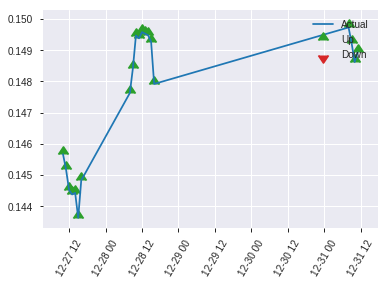


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24788209518036816
RMSE: 0.4978775905585309
LogLoss: 0.6899578077154436
Mean Per-Class Error: 0.43563265306122445
AUC: 0.5427755102040817
pr_auc: 0.4987314798380901
Gini: 0.08555102040816331
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21282770648015545: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    121  0.968    (121.0/125.0)
1      0    98   0        (0.0/98.0)
Total  4    219  0.5426   (121.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.212828     0.618297  218
max f2                       0.212828     0.801964  218
max f0point5                 0.212828     0.50308   218
max accuracy                 0.495353     0.591928  58
max precision                0.657565     1         0
max recall                   0.212828     1         218
max specificity              0.657565     1         0
max absolute_mcc             0.634198     0.152634  3
max min_per_class_accuracy   0.435592     0.540816  107
max mean_per_class_accuracy  0.495353     0.564367  58

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 42.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.645663           2.27551   2.27551            1                0.652471  1                           0.652471            0.0306122       0.0306122                  127.551   127.551
    2        0.0224215                   0.622687           1.13776   1.82041            0.5              0.633782  0.8                         0.644995            0.0102041       0.0408163                  13.7755   82.0408
    3        0.0313901                   0.606655           0         1.30029            0                0.608043  0.571429                    0.634438            0               0.0408163                  -100      30.0292
    4        0.0403587                   0.598531           1.13776   1.26417            0.5              0.604725  0.555556                    0.627835            0.0102041       0.0510204                  13.7755   26.4172
    5        0.0538117                   0.586652           2.27551   1.51701            1                0.590668  0.666667                    0.618543            0.0306122       0.0816327                  127.551   51.7007
    6        0.103139                    0.547294           1.03432   1.28616            0.454545         0.567296  0.565217                    0.594034            0.0510204       0.132653                   3.43228   28.6158
    7        0.152466                    0.520623           0.827458  1.13776            0.363636         0.534458  0.5                         0.574759            0.0408163       0.173469                   -17.2542  13.7755
    8        0.201794                    0.505894           1.65492   1.26417            0.727273         0.512677  0.555556                    0.559584            0.0816327       0.255102                   65.4917   26.4172
    9        0.300448                    0.483029           0.930891  1.15474            0.409091         0.495264  0.507463                    0.538464            0.0918367       0.346939                   -6.91095  15.4737
    10       0.399103                    0.454765           0.724026  1.04827            0.318182         0.469258  0.460674                    0.521357            0.0714286       0.418367                   -27.5974  4.82687
    11       0.502242                    0.431005           1.18722   1.0768             0.521739         0.443606  0.473214                    0.50539             0.122449        0.540816                   18.7223   7.68039
    12       0.600897                    0.409044           0.620594  1.0019             0.272727         0.419844  0.440299                    0.491345            0.0612245       0.602041                   -37.9406  0.190375
    13       0.699552                    0.38567            1.03432   1.00648            0.454545         0.399402  0.442308                    0.478379            0.102041        0.704082                   3.43228   0.647567
    14       0.798206                    0.344412           1.03432   1.00992            0.454545         0.366669  0.44382                     0.464572            0.102041        0.806122                   3.43228   0.991745
    15       0.896861                    0.30907            0.930891  1.00122            0.409091         0.329703  0.44                        0.449736            0.0918367       0.897959                   -6.91095  0.122449
    16       1                           0.202021           0.989352  1                  0.434783         0.256178  0.439462                    0.429773     

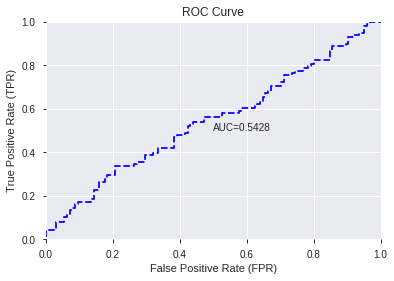

This function is available for GLM models only


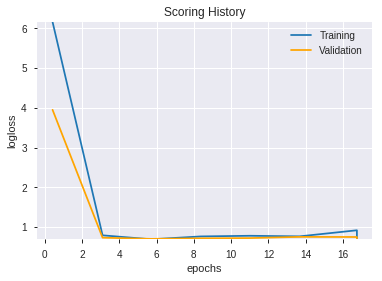

--2019-08-27 19:26:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.212
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.212|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_190102_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_190102_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_85f7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['dayofweek',
 'weekday',
 'CDLLADDERBOTTOM',
 'CDLPIERCING',
 'CDLTASUKIGAP',
 'CDLSTALLEDPATTERN',
 'HT_DCPERIOD',
 'weekday_name',
 'CDLTHRUSTING',
 'CDLDOJI',
 'day',
 'CDLEVENINGDOJISTAR',
 'CDLDARKCLOUDCOVER',
 'days_in_month',
 'STOCHRSI_fastd',
 'CDLEVENINGSTAR',
 'BOP',
 'CDLMORNINGDOJISTAR',
 'ADOSC',
 'CDLGRAVESTONEDOJI',
 'CORREL_8',
 'HT_TRENDMODE',
 'hour',
 'STOCHRSI_fastk',
 'CDLRICKSHAWMAN',
 'DIV',
 'is_month_start',
 'CDLLONGLEGGEDDOJI',
 'CDLLONGLINE',
 'Volume',
 'aroonup_24',
 'CDLSEPARATINGLINES',
 'HT_PHASOR_quadrature',
 'aroonup_30',
 'DX_8',
 'SUB',
 'CCI_8',
 'CDLHAMMER',
 'aroonup_20',
 'CORREL_30',
 'CDLIDENTICAL3CROWS',
 'OBV',
 'aroonup_12',
 'aroondown_20',
 'aroondown_8',
 'HT_PHASOR_inphase',
 'SAREXT',
 'BETA_8',
 'ADXR_12',
 'BETA_12',
 'TRANGE',
 'aroonup_14',
 'CDLSHOOTINGSTAR',
 'CORREL_20',
 'aroonup_8',
 'AROONOSC_12',
 'VAR_8',
 'CDLTAKURI',
 'BBANDS_upperband_8_1_5',
 'CDLSPINNINGTOP',
 'CDLMORNINGSTAR',
 'STOCHF_fastk',
 'STOCH_slowk',
 'BET

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse      mse
0  GLM_grid_1_AutoML_20190827_192639_model_1  0.541143  0.692302              0.481102  0.49958  0.24958

variable  relative_importance  scaled_importance    percentage
0                        ADOSC         8.409502e-03           1.000000  1.483482e-02
1                       Volume         6.830307e-03           0.812213  1.204903e-02
2           CDLIDENTICAL3CROWS         6.259286e-03           0.744311  1.104172e-02
3         HT_PHASOR_quadrature         6.137056e-03           0.729776  1.082610e-02
4                 CDLSHORTLINE         5.497068e-03           0.653673  9.697126e-03
...                        ...                  ...                ...           ...
1029                      TANH         8.943415e-07           0.000106  1.577667e-06
1030  BBANDS_middleband_14_1_2         8.142665e-07           0.000097  1.436410e-06
1031                       TAN         6.225984e-07           0.000074  1.098297e-06
1032   BBANDS_upperband_30_7_2         1.196986e-07           0.000014  2.111549e-07
1033                      ACOS         1.109876e-07           0.000013  1.957881e-07

[1034 rows x 4 columns]

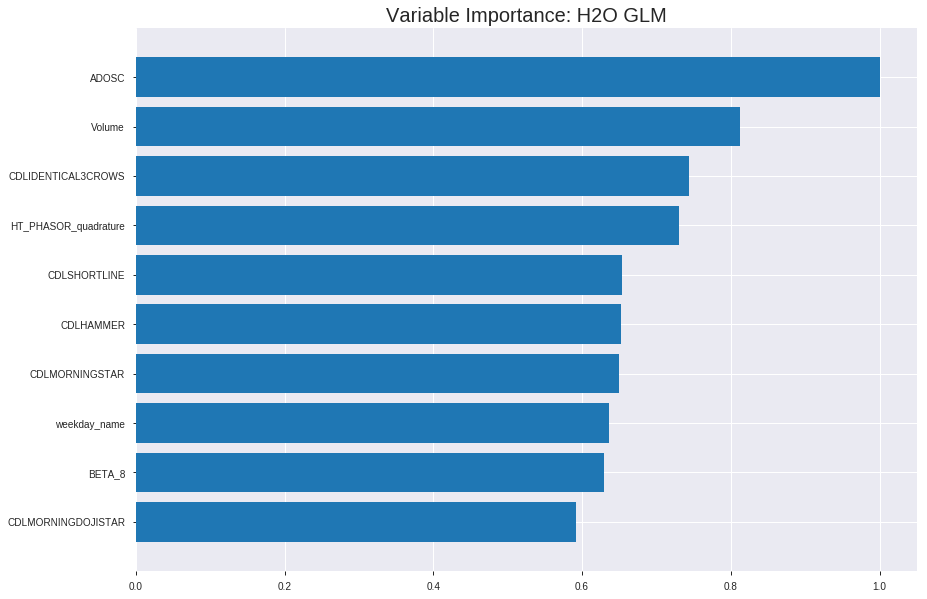

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_192639_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.246934154867178
RMSE: 0.49692469738097944
LogLoss: 0.686999102598439
Null degrees of freedom: 1558
Residual degrees of freedom: 524
Null deviance: 2160.7652781666966
Residual deviance: 2142.0632019019326
AIC: 4212.063201901932
AUC: 0.5768613422275195
pr_auc: 0.5628657684282348
Gini: 0.153722684455039
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4311295655910279: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      9    784   0.9887   (784.0/793.0)
1      1    765   0.0013   (1.0/766.0)
Total  10   1549  0.5035   (785.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.43113      0.660907  391
max f2                       0.430156     0.829543  393
max f0point5                 0.471873     0.563445  278
max accuracy                 0.50914      0.554843  130
max precision                0.585946     1         0
max recall                   0.430156     1         393
max specificity              0.585946     1         0
max absolute_mcc             0.522175     0.134924  83
max min_per_class_accuracy   0.490867     0.551072  202
max mean_per_class_accuracy  0.4893       0.554568  208

Gains/Lift Table: Avg response rate: 49.13 %, avg score: 49.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.558099           1.14483   1.14483            0.5625           0.569243  0.5625                      0.569243            0.0117493       0.0117493                  14.4827   14.4827
    2        0.020526                    0.549587           1.39923   1.27203            0.6875           0.554222  0.625                       0.561732            0.0143603       0.0261097                  39.9233   27.203
    3        0.0301475                   0.544085           1.49252   1.3424             0.733333         0.546295  0.659574                    0.556806            0.0143603       0.04047                    49.2515   34.2398
    4        0.0404105                   0.539052           1.27203   1.32453            0.625            0.541479  0.650794                    0.552913            0.0130548       0.0535248                  27.203    32.4527
    5        0.0500321                   0.536088           1.35683   1.33074            0.666667         0.537814  0.653846                    0.55001             0.0130548       0.0665796                  35.6832   33.0739
    6        0.100064                    0.524928           1.17418   1.25246            0.576923         0.529503  0.615385                    0.539756            0.0587467       0.125326                   17.4182   25.246
    7        0.150096                    0.520173           1.43511   1.31334            0.705128         0.522471  0.645299                    0.533995            0.0718016       0.197128                   43.5111   31.3344
    8        0.200128                    0.515027           0.965438  1.22637            0.474359         0.517515  0.602564                    0.529875            0.0483029       0.245431                   -3.45618  22.6367
    9        0.300192                    0.507044           0.991531  1.14809            0.487179         0.511059  0.564103                    0.523603            0.0992167       0.344648                   -0.84689  14.8089
    10       0.400257                    0.497828           1.08286   1.13178            0.532051         0.502381  0.55609                     0.518297            0.108355        0.453003                   8.28563   13.1781
    11       0.500321                    0.490822           1.01762   1.10895            0.5              0.494145  0.544872                    0.513467            0.101828        0.55483                    1.7624    10.8949
    12       0.599743                    0.482945           0.879752  1.07095            0.432258         0.486844  0.526203                    0.509053            0.0874674       0.642298                   -12.0248  7.0954
    13       0.699808                    0.475003           1.01762   1.06333            0.5              0.47927   0.522456                    0.504795            0.101828        0.744125                   1.7624    6.33285
    14       0.799872                    0.467254           0.926299  1.04619            0.455128         0.471285  0.514034                    0.500603            0.0926893       0.836815                   -7.37012  4.6186
    15       0.899936                    0.457069           0.939345  1.03431            0.461538         0.462479  0.508197                    0.496364            0.0939948       0.930809                   -6.06547  3.43064
    16       1                           0.406769           0.691462  1                  0.339744         0.446166  0.491341                    0.491341            0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2504067479249114
RMSE: 0.5004065826154882
LogLoss: 0.6939636042192595
Null degrees of freedom: 445
Residual degrees of freedom: -589
Null deviance: 618.4903607498804
Residual deviance: 619.0155349635795
AIC: 2689.0155349635797
AUC: 0.49813988095238093
pr_auc: 0.51675622822647
Gini: -0.0037202380952381375
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4531318836422355: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    216  0.973    (216.0/222.0)
1      3    221  0.0134   (3.0/224.0)
Total  9    437  0.491    (219.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.453132     0.668684  391
max f2                       0.42875      0.834575  399
max f0point5                 0.453132     0.560345  391
max accuracy                 0.510262     0.522422  61
max precision                0.554869     1         0
max recall                   0.42875      1         399
max specificity              0.554869     1         0
max absolute_mcc             0.541889     0.081924  2
max min_per_class_accuracy   0.488894     0.495495  201
max mean_per_class_accuracy  0.510262     0.524011  61

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 48.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.540042           1.19464   1.19464            0.6              0.544888  0.6                         0.544888            0.0133929       0.0133929                  19.4643    19.4643
    2        0.0201794                   0.534673           0.995536  1.10615            0.5              0.536586  0.555556                    0.541198            0.00892857      0.0223214                  -0.446429  10.6151
    3        0.0313901                   0.53028            1.19464   1.13776            0.6              0.532253  0.571429                    0.538004            0.0133929       0.0357143                  19.4643    13.7755
    4        0.0403587                   0.52581            0.995536  1.10615            0.5              0.529126  0.555556                    0.536031            0.00892857      0.0446429                  -0.446429  10.6151
    5        0.0515695                   0.522054           0.796429  1.03882            0.4              0.523706  0.521739                    0.533351            0.00892857      0.0535714                  -20.3571   3.88199
    6        0.100897                    0.514937           1.17654   1.10615            0.590909         0.518306  0.555556                    0.525996            0.0580357       0.111607                   17.6542    10.6151
    7        0.150224                    0.509744           1.17654   1.12926            0.590909         0.511968  0.567164                    0.52139             0.0580357       0.169643                   17.6542    12.9264
    8        0.201794                    0.505651           0.865683  1.0619             0.434783         0.507475  0.533333                    0.517834            0.0446429       0.214286                   -13.4317   6.19048
    9        0.300448                    0.498427           0.995536  1.04011            0.5              0.50185   0.522388                    0.512585            0.0982143       0.3125                     -0.446429  4.01119
    10       0.401345                    0.492109           0.929167  1.01222            0.466667         0.495664  0.50838                     0.508331            0.09375         0.40625                    -7.08333   1.22207
    11       0.5                         0.488869           0.905032  0.991071           0.454545         0.490525  0.497758                    0.504818            0.0892857       0.495536                   -9.49675   -0.892857
    12       0.600897                    0.484193           0.884921  0.973248           0.444444         0.486731  0.488806                    0.501781            0.0892857       0.584821                   -11.5079   -2.67524
    13       0.699552                    0.478307           0.995536  0.976391           0.5              0.481179  0.490385                    0.498876            0.0982143       0.683036                   -0.446429  -2.36092
    14       0.800448                    0.473704           0.929167  0.970438           0.466667         0.476164  0.487395                    0.496013            0.09375         0.776786                   -7.08333   -2.95618
    15       0.899103                    0.465318           1.08604   0.983123           0.545455         0.469836  0.493766                    0.49314             0.107143        0.883929                   8.6039     -1.68774
    16       1                           0.42875            1.1504    1                  0.577778         0.45747   0.502242              


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 19:26:42  0.000 sec   2            3.8       1035          1.374             1.38793
    2019-08-27 19:26:44  2.113 sec   4            2.7       1035          1.37134           1.38873
    2019-08-27 19:26:46  4.129 sec   6            2         1035          1.36813           1.38974
    2019-08-27 19:26:48  6.183 sec   8            1.5       1035          1.36428           1.3911
    2019-08-27 19:26:51  8.212 sec   10           1.1       1035          1.35977           1.39288

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5964125560538116)

('F1', 0.6178343949044586)

('auc', 0.5411428571428571)

('logloss', 0.6923019250328185)

('mean_per_class_error', 0.4470612244897959)

('rmse', 0.4995798945418329)

('mse', 0.24958007103042884)

glm prediction progress: |████████████████████████████████████████████████| 100%


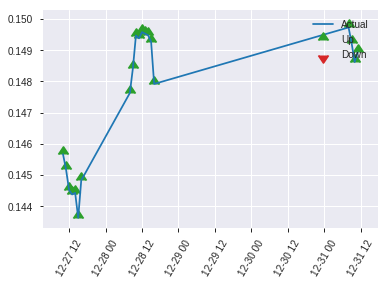


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24958007103042884
RMSE: 0.4995798945418329
LogLoss: 0.6923019250328185
Null degrees of freedom: 222
Residual degrees of freedom: -812
Null deviance: 308.275230921901
Residual deviance: 308.766658564637
AIC: 2378.766658564637
AUC: 0.5411428571428571
pr_auc: 0.49789189481832424
Gini: 0.0822857142857143
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4651186527668238: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    119  0.952    (119.0/125.0)
1      1    97   0.0102   (1.0/98.0)
Total  7    216  0.5381   (120.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.465119     0.617834  215
max f2                       0.465119     0.797697  215
max f0point5                 0.465119     0.504158  215
max accuracy                 0.53351      0.596413  23
max precision                0.554173     1         0
max recall                   0.449678     1         222
max specificity              0.554173     1         0
max absolute_mcc             0.53351      0.158977  23
max min_per_class_accuracy   0.506127     0.540816  109
max mean_per_class_accuracy  0.53129      0.552939  29

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 50.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.550448           1.51701   1.51701            0.666667         0.552527  0.666667                    0.552527            0.0204082       0.0204082                  51.7007   51.7007
    2        0.0224215                   0.546669           2.27551   1.82041            1                0.548279  0.8                         0.550828            0.0204082       0.0408163                  127.551   82.0408
    3        0.0313901                   0.544514           0         1.30029            0                0.544648  0.571429                    0.549062            0               0.0408163                  -100      30.0292
    4        0.0403587                   0.542298           2.27551   1.51701            1                0.543955  0.666667                    0.547927            0.0204082       0.0612245                  127.551   51.7007
    5        0.0538117                   0.540308           1.51701   1.51701            0.666667         0.541298  0.666667                    0.54627             0.0204082       0.0816327                  51.7007   51.7007
    6        0.103139                    0.533715           1.44805   1.48403            0.636364         0.535867  0.652174                    0.541295            0.0714286       0.153061                   44.8052   48.4028
    7        0.152466                    0.529548           1.03432   1.33854            0.454545         0.531591  0.588235                    0.538155            0.0510204       0.204082                   3.43228   33.8535
    8        0.201794                    0.524222           1.03432   1.26417            0.454545         0.52667   0.555556                    0.535348            0.0510204       0.255102                   3.43228   26.4172
    9        0.300448                    0.51708            0.827458  1.12077            0.363636         0.520727  0.492537                    0.530547            0.0816327       0.336735                   -17.2542  12.0774
    10       0.399103                    0.511578           0.827458  1.04827            0.363636         0.51446   0.460674                    0.52657             0.0816327       0.418367                   -17.2542  4.82687
    11       0.502242                    0.505859           1.18722   1.0768             0.521739         0.508616  0.473214                    0.522883            0.122449        0.540816                   18.7223   7.68039
    12       0.600897                    0.499262           1.03432   1.06983            0.454545         0.502823  0.470149                    0.51959             0.102041        0.642857                   3.43228   6.98294
    13       0.699552                    0.496177           0.724026  1.02106            0.318182         0.497813  0.448718                    0.516519            0.0714286       0.714286                   -27.5974  2.10623
    14       0.798206                    0.486534           0.620594  0.971566           0.272727         0.49245   0.426966                    0.513544            0.0612245       0.77551                    -37.9406  -2.84338
    15       0.896861                    0.473453           1.34462   1.0126             0.590909         0.481043  0.445                       0.509969            0.132653        0.908163                   34.462    1.2602
    16       1                           0.449678           0.890417  1                  0.391304         0.465234  0.439462                    0.505355         

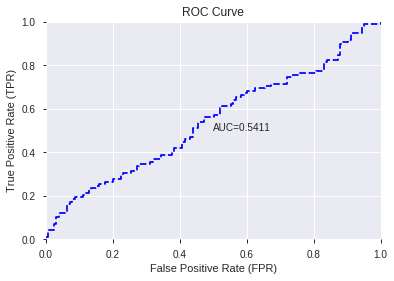

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


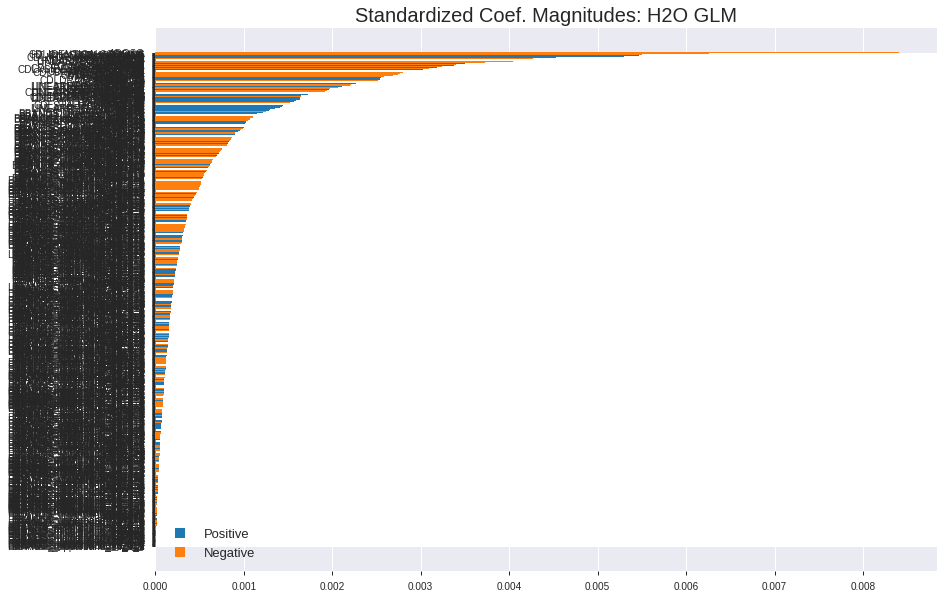

'log_likelihood'
--2019-08-27 19:27:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.93.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.93.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_192639_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_192639_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_85f7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['ADOSC',
 'Volume',
 'CDLIDENTICAL3CROWS',
 'HT_PHASOR_quadrature',
 'CDLSHORTLINE',
 'CDLHAMMER',
 'CDLMORNINGSTAR',
 'weekday_name',
 'BETA_8',
 'CDLMORNINGDOJISTAR',
 'hour',
 'days_in_month',
 'TRANGE',
 'LINEARREG_ANGLE_8',
 'LINEARREG_SLOPE_8',
 'CDLSHOOTINGSTAR',
 'aroonup_12',
 'CDL3INSIDE',
 'weekday',
 'dayofweek',
 'CORREL_8',
 'STOCH_slowd',
 'SUB',
 'VAR_8',
 'DIV',
 'AROONOSC_12',
 'CDLHARAMICROSS',
 'aroonup_30',
 'CDLTASUKIGAP',
 'ULTOSC',
 'STOCHRSI_fastd',
 'CDLEVENINGDOJISTAR',
 'WILLR_12',
 'CDLXSIDEGAP3METHODS',
 'is_month_start',
 'AROONOSC_30',
 'SAREXT',
 'CDL3BLACKCROWS',
 'day',
 'WILLR_14',
 'CDLGRAVESTONEDOJI',
 'MACDEXT_signal',
 'aroonup_8',
 'CDLDOJISTAR',
 'MACDEXT_hist',
 'STDDEV_8',
 'CDL3LINESTRIKE',
 'MACDFIX_hist_8',
 'aroondown_20',
 'STDDEV_12',
 'MACD_hist',
 'MOM_24',
 'ROCR_24',
 'ROCR100_24',
 'ROC_24',
 'WILLR_20',
 'ROCP_24',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'aroonup_24',
 'is_month_end',
 'BETA_12',
 'CORREL_30',
 'MFI_12',
 'AROONOSC_2

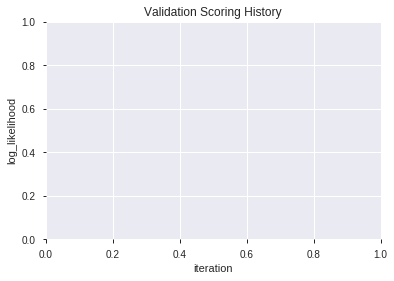

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_192723_model_3  0.543673  0.709109              0.500000  0.507563  0.257620
1  XGBoost_grid_1_AutoML_20190827_192723_model_2  0.542122  0.707072              0.500000  0.506667  0.256712
2               XGBoost_3_AutoML_20190827_192723  0.518122  0.712062              0.500000  0.508948  0.259028
3  XGBoost_grid_1_AutoML_20190827_192723_model_1  0.515265  0.710976              0.496000  0.508543  0.258616
4  XGBoost_grid_1_AutoML_20190827_192723_model_4  0.513878  0.701483              0.471306  0.504060  0.254077
5               XGBoost_2_AutoML_20190827_192723  0.509469  0.720824              0.500000  0.513083  0.263254
6  XGBoost_grid_1_AutoML_20190827_192723_model_7  0.507755  0.732930              0.496000  0.518172  0.268502
7  XGBoost_grid_1_AutoML_20190827_192723_model_6  0.492327  0.717195              0.492000  0.511361  0.261490
8  XGBoost_grid_1_AutoML_20190827_192723_model_5  0.481959  0.761741              0.500000  0.530074  0.280978
9               XGBoost_1_AutoML_20190827_192723  0.479755  0.733377              0.477102  0.518966  0.269326

variable  relative_importance  scaled_importance  percentage
0                     Volume           100.918777           1.000000    0.019957
1                     MFI_12            83.417435           0.826580    0.016496
2                    BETA_24            81.221390           0.804819    0.016062
3                        BOP            74.103996           0.734293    0.014654
4                      ADOSC            72.938194           0.722742    0.014424
..                       ...                  ...                ...         ...
273   BBANDS_upperband_8_6_3             1.710552           0.016950    0.000338
274                   ATR_14             1.330320           0.013182    0.000263
275  BBANDS_lowerband_12_0_2             1.201735           0.011908    0.000238
276   BBANDS_lowerband_8_5_5             0.961031           0.009523    0.000190
277  BBANDS_upperband_12_1_4             0.854515           0.008467    0.000169

[278 rows x 4 columns]

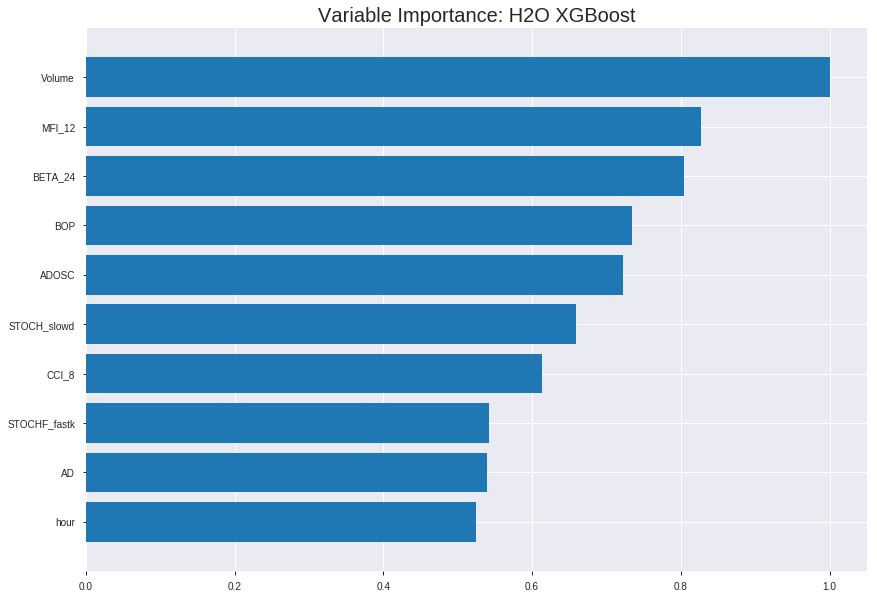

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_192723_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17910814627227267
RMSE: 0.42321170384604523
LogLoss: 0.5470269319974902
Mean Per-Class Error: 0.1326950240189122
AUC: 0.937062712573135
pr_auc: 0.931926863471498
Gini: 0.87412542514627
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4797263989845912: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      677  116  0.1463   (116.0/793.0)
1      92   674  0.1201   (92.0/766.0)
Total  769  790  0.1334   (208.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479726     0.866324  208
max f2                       0.429715     0.90898   256
max f0point5                 0.503258     0.882436  187
max accuracy                 0.481524     0.867223  206
max precision                0.805282     1         0
max recall                   0.351525     1         333
max specificity              0.805282     1         0
max absolute_mcc             0.481524     0.734504  206
max min_per_class_accuracy   0.482781     0.865069  205
max mean_per_class_accuracy  0.481524     0.867305  206

Gains/Lift Table: Avg response rate: 49.13 %, avg score: 49.06 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.733198           2.03525    2.03525            1                0.757556  1                           0.757556            0.0208877       0.0208877                  103.525   103.525
    2        0.020526                    0.716406           2.03525    2.03525            1                0.723423  1                           0.74049             0.0208877       0.0417755                  103.525   103.525
    3        0.0301475                   0.702306           2.03525    2.03525            1                0.708703  1                           0.730345            0.0195822       0.0613577                  103.525   103.525
    4        0.0404105                   0.690379           2.03525    2.03525            1                0.695525  1                           0.721502            0.0208877       0.0822454                  103.525   103.525
    5        0.0500321                   0.684556           1.89956    2.00916            0.933333         0.687576  0.987179                    0.714978            0.0182768       0.100522                   89.9565   100.916
    6        0.100064                    0.645804           2.03525    2.0222             1                0.663397  0.99359                     0.689187            0.101828        0.20235                    103.525   102.22
    7        0.150096                    0.618379           1.98306    2.00916            0.974359         0.631149  0.987179                    0.669841            0.0992167       0.301567                   98.3062   100.916
    8        0.200128                    0.597959           1.93088    1.98959            0.948718         0.607956  0.977564                    0.65437             0.0966057       0.398172                   93.0876   98.9585
    9        0.300192                    0.559962           1.81346    1.93088            0.891026         0.578359  0.948718                    0.629033            0.181462        0.579634                   81.3458   93.0876
    10       0.400257                    0.519513           1.64385    1.85912            0.807692         0.540464  0.913462                    0.606891            0.164491        0.744125                   64.3854   85.9121
    11       0.500321                    0.480514           1.31769    1.75084            0.647436         0.499398  0.860256                    0.585392            0.131854        0.875979                   31.7693   75.0835
    12       0.599743                    0.448816           0.577748   1.55637            0.283871         0.464902  0.764706                    0.565418            0.0574413       0.93342                    -42.2252  55.6366
    13       0.699808                    0.418724           0.482719   1.40285            0.237179         0.435035  0.689276                    0.546775            0.0483029       0.981723                   -51.7281  40.2847
    14       0.799872                    0.387699           0.143511   1.2453             0.0705128        0.403559  0.611868                    0.528858            0.0143603       0.996084                   -85.6489  24.5304
    15       0.899936                    0.348977           0.0391394  1.11119            0.0192308        0.368918  0.545973                    0.511075            0.00391645      1                          -96.0861  11.119
    16       1                           0.16865            0          1                  0                0.306544  0.491341                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2562902996454911
RMSE: 0.5062512218706154
LogLoss: 0.7064113795723738
Mean Per-Class Error: 0.4640846203346203
AUC: 0.5086369851994852
pr_auc: 0.5135921252199063
Gini: 0.017273970398970384
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29696354269981384: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    221  0.9955   (221.0/222.0)
1      0    224  0        (0.0/224.0)
Total  1    445  0.4955   (221.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.296964     0.669656   398
max f2                       0.296964     0.835198   398
max f0point5                 0.296964     0.558882   398
max accuracy                 0.51819      0.535874   195
max precision                0.736894     0.666667   2
max recall                   0.296964     1          398
max specificity              0.751742     0.995495   0
max absolute_mcc             0.51819      0.0718416  195
max min_per_class_accuracy   0.515647     0.531532   200
max mean_per_class_accuracy  0.51819      0.535915   195

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 51.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.726709           1.19464   1.19464            0.6              0.737563  0.6                         0.737563            0.0133929       0.0133929                  19.4643    19.4643
    2        0.0201794                   0.710938           0.497768  0.884921           0.25             0.722797  0.444444                    0.731001            0.00446429      0.0178571                  -50.2232   -11.5079
    3        0.0313901                   0.69116            1.59286   1.13776            0.8              0.699712  0.571429                    0.719826            0.0178571       0.0357143                  59.2857    13.7755
    4        0.0403587                   0.668744           0.995536  1.10615            0.5              0.684311  0.555556                    0.711934            0.00892857      0.0446429                  -0.446429  10.6151
    5        0.0515695                   0.660472           1.19464   1.12539            0.6              0.663373  0.565217                    0.701377            0.0133929       0.0580357                  19.4643    12.5388
    6        0.100897                    0.621729           1.08604   1.10615            0.545455         0.638978  0.555556                    0.670871            0.0535714       0.111607                   8.6039     10.6151
    7        0.150224                    0.600524           1.08604   1.09955            0.545455         0.610878  0.552239                    0.651172            0.0535714       0.165179                   8.6039     9.95469
    8        0.201794                    0.581088           0.605978  0.973413           0.304348         0.590757  0.488889                    0.635732            0.03125         0.196429                   -39.4022   -2.65873
    9        0.300448                    0.552786           1.04079   0.995536           0.522727         0.566464  0.5                         0.612987            0.102679        0.299107                   4.07873    -0.446429
    10       0.401345                    0.532004           1.0619    1.01222            0.533333         0.541109  0.50838                     0.594917            0.107143        0.40625                    6.19048    1.22207
    11       0.5                         0.515788           1.26705   1.0625             0.636364         0.523333  0.533632                    0.580793            0.125           0.53125                    26.7045    6.25
    12       0.600897                    0.498009           0.796429  1.01782            0.4              0.506145  0.511194                    0.568259            0.0803571       0.611607                   -20.3571   1.78238
    13       0.699552                    0.477543           0.950284  1.0083             0.477273         0.487279  0.50641                     0.556839            0.09375         0.705357                   -4.97159   0.829899
    14       0.800448                    0.451561           0.796429  0.981593           0.4              0.464866  0.492997                    0.545246            0.0803571       0.785714                   -20.3571   -1.84074
    15       0.899103                    0.421633           0.995536  0.983123           0.5              0.435318  0.493766                    0.533184            0.0982143       0.883929                   -0.446429  -1.68774
    16       1                           0.279567           1.1504    1                  0.577778         0.37072   0.502242                


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 19:27:47  7.983 sec   0                  0.5              0.693147            0.5             0                  1                0.508659                         0.5                0.693147              0.5               0                    1                  0.497758
    2019-08-27 19:27:48  9.189 sec   5                  0.489493         0.672304            0.75149         0.732347           1.90805          0.33932                          0.500551           0.69423               0.497476          0.518037             1.59286            0.495516
    2019-08-27 19:27:49  9.537 sec   10                 0.479294         0.65237             0.81569         0.80609            2.03525          0.263631                         0.502262           0.697679              0.488387          0.515054             1.59286            0.493274
    2019-08-27 19:27:49  9.881 sec   15                 0.472879         0.639911            0.830737        0.823874           2.03525          0.262989                         0.503506           0.700187              0.467242          0.498501             1.19464            0.484305
    2019-08-27 19:27:49  10.243 sec  20                 0.465582         0.625916            0.857982        0.851018           2.03525          0.23669                          0.503746           0.700672              0.47607           0.509651             1.19464            0.484305
    2019-08-27 19:27:50  10.589 sec  25                 0.45925          0.613827            0.871816        0.865346           2.03525          0.221937                         0.504132           0.701492              0.47975           0.513755             1.19464            0.486547
    2019-08-27 19:27:50  10.964 sec  30                 0.451202         0.598607            0.890347        0.885487           2.03525          0.187941                         0.504548           0.702399              0.486708          0.509482             1.59286            0.488789
    2019-08-27 19:27:50  11.326 sec  35                 0.44411          0.585418            0.909206        0.906562           2.03525          0.168698                         0.505175           0.703815              0.497225          0.502401             1.19464            0.493274
    2019-08-27 19:27:51  11.693 sec  40                 0.435294         0.569126            0.922204        0.91849            2.03525          0.156511                         0.505906           0.705523              0.500804          0.502822             0.398214           0.488789
    2019-08-27 19:27:51  12.050 sec  45                 0.430014         0.559371            0.928877        0.925803           2.03525          0.144965                         0.505309           0.704323              0.505731          0.509738             0.796429           0.491031
    2019-08-27 19:27:51  12.423 sec  50                 0.423212         0.547027            0.937063        0.931927           2.03525          0.133419                         0.506251           0.706411              0.508637          0.513592             1.19464            0.495516

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
Volume                   100.91877746582031     1.0                   0.019957073641207478
MFI_12                   83.41743469238281      0.8265799169102603    0.016496116272121226
BETA_24                  81.22138977050781      0.8048193984317368    0.016061840002374473
BOP                      74.10399627685547      0.734293440107847     0.014654348258487876
ADOSC                    72.93819427490234      0.7227415561945885    0.014423806460536296
---                      ---                    ---                   ---
BBANDS_upperband_8_6_3   1.7105522155761719     0.016949791292859354  0.00033826823303469145
ATR_14                   1.3303203582763672     0.013182089514777633  0.0002630759311914062
BBANDS_lowerband_12_0_2  1.2017345428466797     0.011907937977683978  0.0002376475951355704
BBANDS_lowerband_8_5_5   0.9610309600830078     0.009522816112278953  0.00019004754242442817
BBANDS_upperband_12_1_4  0.8545150756835938     0.00846735461072153   0.0001689836195123873


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5874439461883408)

('F1', 0.6105919003115265)

('auc', 0.5436734693877551)

('logloss', 0.7091094363819704)

('mean_per_class_error', 0.4363265306122449)

('rmse', 0.5075627370213801)

('mse', 0.25761993201263467)

xgboost prediction progress: |████████████████████████████████████████████| 100%


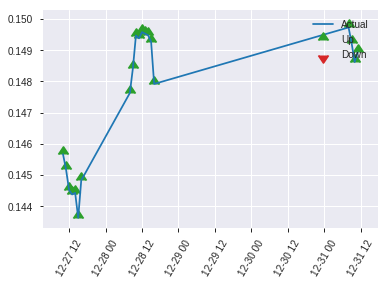


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25761993201263467
RMSE: 0.5075627370213801
LogLoss: 0.7091094363819704
Mean Per-Class Error: 0.4363265306122449
AUC: 0.5436734693877551
pr_auc: 0.47663651517216094
Gini: 0.08734693877551014
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35146042704582214: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    125  1        (125.0/125.0)
1      0    98   0        (0.0/98.0)
Total  0    223  0.5605   (125.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.35146      0.610592  222
max f2                       0.35146      0.796748  222
max f0point5                 0.549089     0.502008  99
max accuracy                 0.586725     0.587444  65
max precision                0.736699     1         0
max recall                   0.35146      1         222
max specificity              0.736699     1         0
max absolute_mcc             0.586725     0.138463  65
max min_per_class_accuracy   0.541183     0.530612  108
max mean_per_class_accuracy  0.586725     0.563673  65

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 54.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.712345           1.51701   1.51701            0.666667         0.723704  0.666667                    0.723704            0.0204082       0.0204082                  51.7007   51.7007
    2        0.0224215                   0.705932           0         0.910204           0                0.709306  0.4                         0.717945            0               0.0204082                  -100      -8.97959
    3        0.0313901                   0.694117           1.13776   0.975219           0.5              0.701161  0.428571                    0.71315             0.0102041       0.0306122                  13.7755   -2.47813
    4        0.0403587                   0.686089           1.13776   1.01134            0.5              0.690707  0.444444                    0.708162            0.0102041       0.0408163                  13.7755   1.13379
    5        0.0538117                   0.677027           2.27551   1.32738            1                0.682481  0.583333                    0.701742            0.0306122       0.0714286                  127.551   32.7381
    6        0.103139                    0.649317           1.03432   1.18722            0.454545         0.664724  0.521739                    0.684038            0.0510204       0.122449                   3.43228   18.7223
    7        0.152466                    0.627152           1.24119   1.20468            0.545455         0.632986  0.529412                    0.667521            0.0612245       0.183673                   24.1187   20.4682
    8        0.201794                    0.613558           0.620594  1.0619             0.272727         0.622051  0.466667                    0.656406            0.0306122       0.214286                   -37.9406  6.19048
    9        0.300448                    0.586088           1.55148   1.22266            0.681818         0.59871   0.537313                    0.637461            0.153061        0.367347                   55.1484   22.2662
    10       0.399103                    0.560893           0.827458  1.12497            0.363636         0.572168  0.494382                    0.621321            0.0816327       0.44898                    -17.2542  12.4971
    11       0.502242                    0.536626           0.791482  1.05649            0.347826         0.5479    0.464286                    0.606244            0.0816327       0.530612                   -20.8518  5.64869
    12       0.600897                    0.513101           1.03432   1.05285            0.454545         0.525167  0.462687                    0.592933            0.102041        0.632653                   3.43228   5.2848
    13       0.699552                    0.496763           1.03432   1.05024            0.454545         0.504217  0.461538                    0.580421            0.102041        0.734694                   3.43228   5.02355
    14       0.798206                    0.469639           0.724026  1.00992            0.318182         0.481407  0.44382                     0.568184            0.0714286       0.806122                   -27.5974  0.991745
    15       0.896861                    0.435582           0.827458  0.989847           0.363636         0.45259   0.435                       0.555468            0.0816327       0.887755                   -17.2542  -1.01531
    16       1                           0.35146            1.08829   1                  0.478261         0.408881  0.439462                    0.54035       

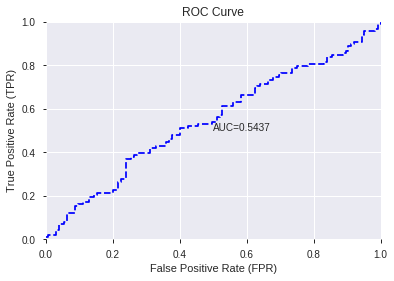

This function is available for GLM models only


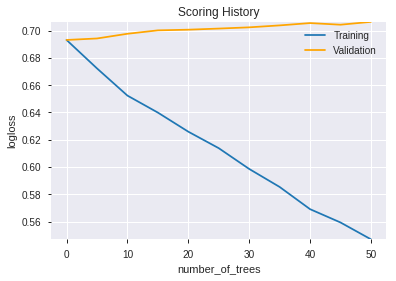

--2019-08-27 19:28:19--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_192723_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_192723_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_85f7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['Volume',
 'MFI_12',
 'BETA_24',
 'BOP',
 'ADOSC',
 'STOCH_slowd',
 'CCI_8',
 'STOCHF_fastk',
 'AD',
 'hour',
 'aroondown_30',
 'ATR_30',
 'BETA_8',
 'AROONOSC_30',
 'TRANGE',
 'STOCHRSI_fastd',
 'CMO_8',
 'MFI_8',
 'ROC_14',
 'BETA_14',
 'STOCHF_fastd',
 'BETA_12',
 'AROONOSC_24',
 'MFI_14',
 'MACDEXT_signal',
 'MFI_20',
 'HT_PHASOR_quadrature',
 'NATR_8',
 'MINUS_DM_8',
 'LINEARREG_ANGLE_8',
 'PLUS_DM_30',
 'AROONOSC_12',
 'HT_PHASOR_inphase',
 'CCI_12',
 'CCI_24',
 'MINUS_DM_20',
 'dayofweek',
 'MACDEXT_hist',
 'MINUS_DI_8',
 'PLUS_DI_24',
 'MACDFIX_hist_12',
 'day',
 'LINEARREG_ANGLE_14',
 'CCI_14',
 'ATR_24',
 'BETA_20',
 'OBV',
 'DX_14',
 'STDDEV_30',
 'MOM_14',
 'MINUS_DM_24',
 'MACDFIX_signal_12',
 'CCI_20',
 'LINEARREG_SLOPE_8',
 'dayofyear',
 'DIV',
 'STOCHRSI_fastk',
 'ATR_20',
 'aroonup_24',
 'WILLR_20',
 'TRIX_14',
 'ADX_14',
 'MACDFIX_hist_24',
 'ULTOSC',
 'MFI_30',
 'MACDFIX_hist_8',
 'NATR_14',
 'DX_20',
 'BBANDS_upperband_24_3_3',
 'BBANDS_upperband_20_7_3',
 'CDLBELT

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

408

['WMA_14',
 'MA_14_0',
 'MAVP_14_0',
 'BBANDS_upperband_14_0_2',
 'BBANDS_middleband_14_0_2',
 'BBANDS_lowerband_14_0_2',
 'BBANDS_upperband_14_0_3',
 'BBANDS_middleband_14_0_3',
 'BBANDS_lowerband_14_0_3',
 'BBANDS_upperband_14_0_4',
 'BBANDS_middleband_14_0_4',
 'BBANDS_lowerband_14_0_4',
 'BBANDS_upperband_14_0_5',
 'BBANDS_middleband_14_0_5',
 'BBANDS_lowerband_14_0_5',
 'MA_14_1',
 'MAVP_14_1',
 'BBANDS_upperband_14_1_2',
 'BBANDS_middleband_14_1_2',
 'BBANDS_lowerband_14_1_2',
 'BBANDS_upperband_14_1_3',
 'BBANDS_middleband_14_1_3',
 'BBANDS_lowerband_14_1_3',
 'BBANDS_upperband_14_1_4',
 'BBANDS_middleband_14_1_4',
 'BBANDS_lowerband_14_1_4',
 'BBANDS_upperband_14_1_5',
 'BBANDS_middleband_14_1_5',
 'BBANDS_lowerband_14_1_5',
 'MA_14_2',
 'MAVP_14_2',
 'BBANDS_upperband_14_2_2',
 'BBANDS_middleband_14_2_2',
 'BBANDS_lowerband_14_2_2',
 'BBANDS_upperband_14_2_3',
 'BBANDS_middleband_14_2_3',
 'BBANDS_lowerband_14_2_3',
 'BBANDS_upperband_14_2_4',
 'BBANDS_middleband_14_2_4',
 'BB

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_192934_model_1  0.571592  1.293011              0.455306  0.590966  0.349240
1  DeepLearning_grid_1_AutoML_20190827_192934_model_2  0.566694  0.697279              0.488000  0.500150  0.250150
2  DeepLearning_grid_1_AutoML_20190827_192934_model_3  0.553224  0.722596              0.469102  0.511247  0.261373
3  DeepLearning_grid_1_AutoML_20190827_192934_model_9  0.548898  0.697087              0.492000  0.501966  0.251969
4  DeepLearning_grid_1_AutoML_20190827_192934_model_7  0.542857  0.781942              0.419714  0.528062  0.278850
5  DeepLearning_grid_1_AutoML_20190827_192934_model_4  0.513714  1.218937              0.492000  0.600490  0.360588
6               DeepLearning_1_AutoML_20190827_192934  0.478531  0.765793              0.469510  0.527878  0.278655
7  DeepLearning_grid_1_AutoML_20190827_192934_model_8  0.471306  0.703550              0.500000  0.504545  0.254566
8  DeepLearning_grid_1_AutoML_20190827_192934_model_6  0.465306  0.711059              0.496000  0.508635  0.258709
9  DeepLearning_grid_1_AutoML_20190827_192934_model_5  0.434694  0.701778              0.496000  0.503708  0.253721

variable  relative_importance  scaled_importance  percentage
0                      ROCP_8             1.000000           1.000000    0.002689
1                   STDDEV_12             0.998709           0.998709    0.002685
2    BBANDS_middleband_14_3_2             0.995051           0.995051    0.002675
3                 MINUS_DI_14             0.990140           0.990140    0.002662
4                  aroonup_24             0.975231           0.975231    0.002622
..                        ...                  ...                ...         ...
402  BBANDS_middleband_24_0_2             0.850531           0.850531    0.002287
403  BBANDS_middleband_24_0_3             0.846074           0.846074    0.002275
404   BBANDS_upperband_24_2_2             0.843304           0.843304    0.002267
405                    ATR_12             0.843127           0.843127    0.002267
406   BBANDS_lowerband_14_2_4             0.842440           0.842440    0.002265

[407 rows x 4 columns]

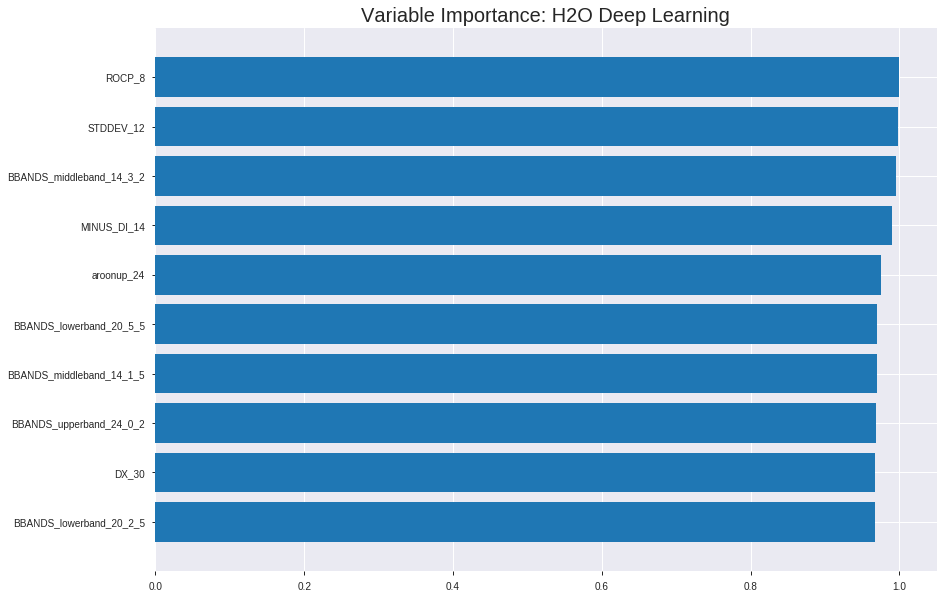

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_192934_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2844893466031289
RMSE: 0.5333754274459304
LogLoss: 1.0336796118133647
Mean Per-Class Error: 0.3553350300771436
AUC: 0.7009628966248407
pr_auc: 0.6402782483500992
Gini: 0.40192579324968136
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3219256980637803: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      293  500   0.6305   (500.0/793.0)
1      90   676   0.1175   (90.0/766.0)
Total  383  1176  0.3784   (590.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.321926     0.696189  281
max f2                       0.00739764   0.831507  395
max f0point5                 0.885588     0.641476  85
max accuracy                 0.885588     0.645927  85
max precision                0.999884     0.878049  0
max recall                   0.000142797  1         399
max specificity              0.999884     0.993695  0
max absolute_mcc             0.339239     0.292826  275
max min_per_class_accuracy   0.817462     0.638381  116
max mean_per_class_accuracy  0.885588     0.644665  85

Gains/Lift Table: Avg response rate: 49.13 %, avg score: 65.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.999952           2.03525   2.03525            1                0.999987   1                           0.999987            0.0208877       0.0208877                  103.525   103.525
    2        0.020526                    0.999805           1.65364   1.84444            0.8125           0.99989    0.90625                     0.999938            0.0169713       0.037859                   65.3639   84.4444
    3        0.0301475                   0.999514           1.6282    1.77543            0.8              0.999637   0.87234                     0.999842            0.0156658       0.0535248                  62.8198   77.5429
    4        0.0404105                   0.999313           1.27203   1.64758            0.625            0.999427   0.809524                    0.999737            0.0130548       0.0665796                  27.203    64.7582
    5        0.0500321                   0.998886           1.49252   1.61776            0.733333         0.999109   0.794872                    0.999616            0.0143603       0.0809399                  49.2515   61.7761
    6        0.100064                    0.995235           1.61776   1.61776            0.794872         0.997196   0.794872                    0.998406            0.0809399       0.16188                    61.7761   61.7761
    7        0.150096                    0.988906           1.51339   1.58297            0.74359          0.992415   0.777778                    0.996409            0.075718        0.237598                   51.339    58.2971
    8        0.200128                    0.981862           1.22637   1.49382            0.602564         0.985977   0.733974                    0.993801            0.0613577       0.298956                   22.6367   49.382
    9        0.300192                    0.956147           1.27855   1.42206            0.628205         0.971322   0.698718                    0.986308            0.127937        0.426893                   27.8553   42.2064
    10       0.400257                    0.901682           1.16114   1.35683            0.570513         0.934334   0.666667                    0.973314            0.116188        0.543081                   16.1135   35.6832
    11       0.500321                    0.810194           0.991531  1.28377            0.487179         0.859202   0.630769                    0.950492            0.0992167       0.642298                   -0.84689  28.3772
    12       0.599743                    0.635542           0.932275  1.2255             0.458065         0.73003    0.602139                    0.913945            0.0926893       0.734987                   -6.77251  22.5502
    13       0.699808                    0.440091           0.952392  1.18645            0.467949         0.542991   0.582951                    0.860903            0.0953003       0.830287                   -4.76083  18.6451
    14       0.799872                    0.23478            0.782788  1.13595            0.384615         0.336322   0.55814                     0.795278            0.078329        0.908616                   -21.7212  13.5952
    15       0.899936                    0.0608642          0.495766  1.06477            0.24359          0.141881   0.523165                    0.722626            0.0496084       0.958225                   -50.4234  6.47698
    16       1                           1.555e-11          0.417487  1                  0.205128         0.0186549  0.491341                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.39035210996984415
RMSE: 0.6247816498344395
LogLoss: 1.595718956327453
Mean Per-Class Error: 0.45372828185328185
AUC: 0.5022220881595881
pr_auc: 0.4858497423260938
Gini: 0.004444176319176263
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0007969554121701102: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    213  0.9595   (213.0/222.0)
1      4    220  0.0179   (4.0/224.0)
Total  13   433  0.4865   (217.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.000796955  0.669711  392
max f2                       1.21059e-05  0.834575  399
max f0point5                 0.227461     0.567255  283
max accuracy                 0.247824     0.547085  276
max precision                0.999991     1         0
max recall                   1.21059e-05  1         399
max specificity              0.999991     1         0
max absolute_mcc             0.227461     0.100754  283
max min_per_class_accuracy   0.593495     0.509009  198
max mean_per_class_accuracy  0.247824     0.546272  276

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 54.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.999855           1.59286   1.59286            0.8              0.999964    0.8                         0.999964            0.0178571       0.0178571                  59.2857    59.2857
    2        0.0201794                   0.999541           0.995536  1.32738            0.5              0.999765    0.666667                    0.999876            0.00892857      0.0267857                  -0.446429  32.7381
    3        0.0313901                   0.999163           0.398214  0.995536           0.2              0.999364    0.5                         0.999693            0.00446429      0.03125                    -60.1786   -0.446429
    4        0.0403587                   0.998544           0.497768  0.884921           0.25             0.998969    0.444444                    0.999532            0.00446429      0.0357143                  -50.2232   -11.5079
    5        0.0515695                   0.997928           0.796429  0.865683           0.4              0.998225    0.434783                    0.999248            0.00892857      0.0446429                  -20.3571   -13.4317
    6        0.100897                    0.993147           0.905032  0.884921           0.454545         0.996001    0.444444                    0.997661            0.0446429       0.0892857                  -9.49675   -11.5079
    7        0.150224                    0.986773           0.814529  0.861807           0.409091         0.990246    0.432836                    0.995226            0.0401786       0.129464                   -18.5471   -13.8193
    8        0.201794                    0.969294           1.12539   0.929167           0.565217         0.979882    0.466667                    0.991305            0.0580357       0.1875                     12.5388    -7.08333
    9        0.300448                    0.914863           0.905032  0.921242           0.454545         0.946245    0.462687                    0.976509            0.0892857       0.276786                   -9.49675   -7.8758
    10       0.401345                    0.759622           1.10615   0.967727           0.555556         0.843724    0.486034                    0.943127            0.111607        0.388393                   10.6151    -3.22725
    11       0.5                         0.597256           1.22179   1.01786            0.613636         0.682103    0.511211                    0.891625            0.120536        0.508929                   22.1794    1.78571
    12       0.600897                    0.420662           1.0619    1.02525            0.533333         0.513428    0.514925                    0.828121            0.107143        0.616071                   6.19048    2.52532
    13       0.699552                    0.226888           1.3123    1.06573            0.659091         0.305883    0.535256                    0.754472            0.129464        0.745536                   31.2297    6.57337
    14       0.800448                    0.0849325          0.66369   1.01506            0.333333         0.138376    0.509804                    0.676813            0.0669643       0.8125                     -33.631    1.5056
    15       0.899103                    0.018645           0.859781  0.998018           0.431818         0.04783     0.501247                    0.607798            0.0848214       0.897321                   -14.0219   -0.198165
    16       1                           7.80132e-07        1.01766   1                  0.511111    


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 19:29:35  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 19:29:40  5.433 sec   472 obs/sec       1.40795   1             2195       0.620793         2.15954             -0.541996      0.561175        0.525417           1.52644          0.508659                         0.636311           1.82865               -0.619597        0.488477          0.510265             1.59286            0.497758
    2019-08-27 19:29:49  14.592 sec  495 obs/sec       4.22386   3             6585       0.604649         1.76608             -0.462839      0.610137        0.570692           1.65364          0.466966                         0.641266           1.96327               -0.64492         0.513564          0.508556             1.59286            0.497758
    2019-08-27 19:29:58  23.471 sec  508 obs/sec       7.04618   5             10985      0.533375         1.03368             -0.138299      0.700963        0.640278           2.03525          0.378448                         0.624782           1.59572               -0.56144         0.502222          0.48585              1.59286            0.486547
    2019-08-27 19:30:07  32.134 sec  516 obs/sec       9.8576    7             15368      0.561866         1.58708             -0.263152      0.647396        0.629604           1.90805          0.508659                         0.645736           2.23431               -0.667932        0.527278          0.513657             0.796429           0.497758
    2019-08-27 19:30:16  40.804 sec  522 obs/sec       12.7081   9             19812      0.560822         1.37179             -0.258463      0.661047        0.636271           1.90805          0.449006                         0.648489           2.08161               -0.682185        0.505882          0.500557             1.59286            0.497758
    2019-08-27 19:30:24  49.287 sec  527 obs/sec       15.5144   11            24187      0.521784         1.20707             -0.0893594     0.708367        0.69376            2.03525          0.402181                         0.644394           2.01447               -0.661006        0.520431          0.512463             1.59286            0.488789
    2019-08-27 19:30:25  49.829 sec  526 obs/sec       15.5144   11            24187      0.533375         1.03368             -0.138299      0.700963        0.640278           2.03525          0.378448                         0.624782           1.59572               -0.56144         0.502222          0.48585              1.59286            0.486547

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
ROCP_8                    1.0                    1.0                  0.002688613965486901
STDDEV_12                 0.998709499835968      0.998709499835968    0.002685144308723421
BBANDS_middleband_14_3_2  0.9950507283210754     0.9950507283210754   0.0026753072845319553
MINUS_DI_14               0.9901403784751892     0.9901403784751892   0.0026621052493608793
aroonup_24                0.9752311706542969     0.9752311706542969   0.0026220201449992813
---                       ---                    ---                  ---
BBANDS_middleband_24_0_2  0.8505308628082275     0.8505308628082275   0.0022867491558238237
BBANDS_middleband_24_0_3  0.8460738062858582     0.8460738062858582   0.0022747658514128168
BBANDS_upperband_24_2_2   0.843304455280304      0.843304455280304    0.0022673201356239485
ATR_12                    0.8431272506713867     0.8431272506713867   0.002266843700837665
BBANDS_lowerband_14_2_4   0.842440128326416      0.842440128326416    0.0022649962941049787


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.57847533632287)

('F1', 0.6270627062706271)

('auc', 0.5715918367346938)

('logloss', 1.2930108608736697)

('mean_per_class_error', 0.4224489795918367)

('rmse', 0.5909656548491278)

('mse', 0.34924040521125843)

deeplearning prediction progress: |███████████████████████████████████████| 100%


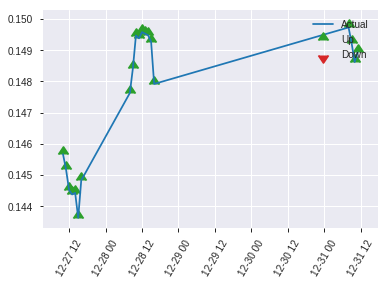


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.34924040521125843
RMSE: 0.5909656548491278
LogLoss: 1.2930108608736697
Mean Per-Class Error: 0.4224489795918367
AUC: 0.5715918367346938
pr_auc: 0.47407807957712206
Gini: 0.14318367346938765
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.010875968398662613: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      15   110  0.88     (110.0/125.0)
1      3    95   0.0306   (3.0/98.0)
Total  18   205  0.5067   (113.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.010876     0.627063  204
max f2                       0.0030087    0.801964  218
max f0point5                 0.221696     0.533141  148
max accuracy                 0.771678     0.578475  81
max precision                0.999933     1         0
max recall                   0.0030087    1         218
max specificity              0.999933     1         0
max absolute_mcc             0.0454381    0.16545   189
max min_per_class_accuracy   0.614666     0.540816  106
max mean_per_class_accuracy  0.221696     0.577551  148

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 52.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.999852           0.758503  0.758503           0.333333         0.999921    0.333333                    0.999921            0.0102041       0.0102041                  -24.1497  -24.1497
    2        0.0224215                   0.999161           1.13776   0.910204           0.5              0.99958     0.4                         0.999785            0.0102041       0.0204082                  13.7755   -8.97959
    3        0.0313901                   0.998583           1.13776   0.975219           0.5              0.998664    0.428571                    0.999465            0.0102041       0.0306122                  13.7755   -2.47813
    4        0.0403587                   0.997203           2.27551   1.26417            1                0.998418    0.555556                    0.999232            0.0204082       0.0510204                  127.551   26.4172
    5        0.0538117                   0.996674           0.758503  1.13776            0.333333         0.996871    0.5                         0.998642            0.0102041       0.0612245                  -24.1497  13.7755
    6        0.103139                    0.98956            0.827458  0.989352           0.363636         0.993023    0.434783                    0.995955            0.0408163       0.102041                   -17.2542  -1.06477
    7        0.152466                    0.96947            1.24119   1.07083            0.545455         0.982484    0.470588                    0.991596            0.0612245       0.163265                   24.1187   7.08283
    8        0.201794                    0.939496           1.44805   1.16304            0.636364         0.951986    0.511111                    0.981914            0.0714286       0.234694                   44.8052   16.3039
    9        0.300448                    0.850604           1.13776   1.15474            0.5              0.899914    0.507463                    0.954989            0.112245        0.346939                   13.7755   15.4737
    10       0.399103                    0.73042            1.13776   1.15054            0.5              0.792654    0.505618                    0.914861            0.112245        0.459184                   13.7755   15.0539
    11       0.502242                    0.590131           0.791482  1.0768             0.347826         0.66126     0.473214                    0.862782            0.0816327       0.540816                   -20.8518  7.68039
    12       0.600897                    0.327979           1.24119   1.10379            0.545455         0.456376    0.485075                    0.796059            0.122449        0.663265                   24.1187   10.3792
    13       0.699552                    0.183354           0.930891  1.07941            0.409091         0.248845    0.474359                    0.718888            0.0918367       0.755102                   -6.91095  7.94087
    14       0.798206                    0.0863454          1.03432   1.07384            0.454545         0.139535    0.47191                     0.647282            0.102041        0.857143                   3.43228   7.38363
    15       0.896861                    0.0198697          0.724026  1.03536            0.318182         0.0500277   0.455                       0.581584            0.0714286       0.928571                   -27.5974  3.53571
    16       1                           0.000693168        0.692547  1                  0.304348         0.00787327  0.439

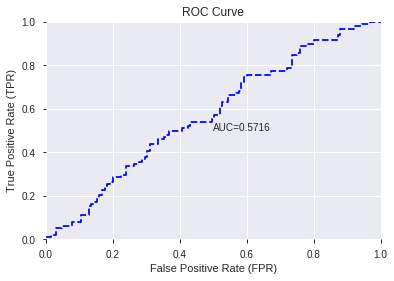

This function is available for GLM models only


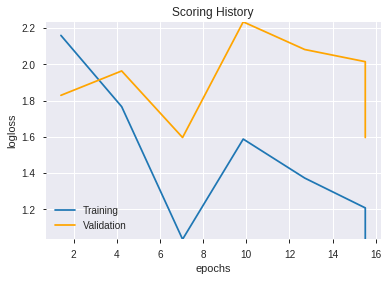

--2019-08-27 19:43:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.133.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.133.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_192934_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_192934_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_85f7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['ROCP_8',
 'STDDEV_12',
 'BBANDS_middleband_14_3_2',
 'MINUS_DI_14',
 'aroonup_24',
 'BBANDS_lowerband_20_5_5',
 'BBANDS_middleband_14_1_5',
 'BBANDS_upperband_24_0_2',
 'DX_30',
 'BBANDS_lowerband_20_2_5',
 'RSI_12',
 'MAVP_24_5',
 'BBANDS_upperband_30_0_3',
 'CDLTHRUSTING',
 'CDLGAPSIDESIDEWHITE',
 'CDLHIKKAKE',
 'TRANGE',
 'ROCR100_12',
 'CDLSHORTLINE',
 'BBANDS_upperband_14_0_2',
 'BETA_8',
 'MAVP_14_3',
 'CDLIDENTICAL3CROWS',
 'STOCH_slowd',
 'TRIX_8',
 'ADX_14',
 'CORREL_12',
 'BBANDS_middleband_20_7_3',
 'BBANDS_lowerband_20_0_5',
 'BBANDS_lowerband_14_5_4',
 'MA_24_5',
 'BBANDS_middleband_14_2_3',
 'BBANDS_middleband_20_1_5',
 'aroondown_14',
 'MFI_24',
 'MFI_12',
 'BBANDS_lowerband_14_3_5',
 'NATR_8',
 'BBANDS_lowerband_20_6_4',
 'DX_8',
 'CDLEVENINGDOJISTAR',
 'aroonup_30',
 'MA_14_2',
 'BBANDS_lowerband_20_6_3',
 'aroonup_12',
 'BBANDS_lowerband_24_3_5',
 'HT_TRENDMODE',
 'ATR_8',
 'BBANDS_middleband_14_7_2',
 'BBANDS_upperband_14_4_4',
 'aroondown_20',
 'SMA_20',
 'MINUS_D

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_194346_model_1  0.545224  0.690922              0.485102  0.498888  0.248889

variable  relative_importance  scaled_importance  percentage
0                      ADOSC             0.008471           1.000000    0.021763
1         CDLIDENTICAL3CROWS             0.006269           0.740128    0.016107
2       HT_PHASOR_quadrature             0.006180           0.729568    0.015877
3                  CDLHAMMER             0.005540           0.654059    0.014234
4               CDLSHORTLINE             0.005501           0.649469    0.014134
..                       ...                  ...                ...         ...
402   LINEARREG_INTERCEPT_14             0.000012           0.001387    0.000030
403  BBANDS_upperband_14_4_5             0.000011           0.001270    0.000028
404  BBANDS_upperband_14_0_2             0.000010           0.001142    0.000025
405  BBANDS_upperband_14_3_2             0.000009           0.001061    0.000023
406                  MA_14_5             0.000002           0.000194    0.000004

[407 rows x 4 columns]

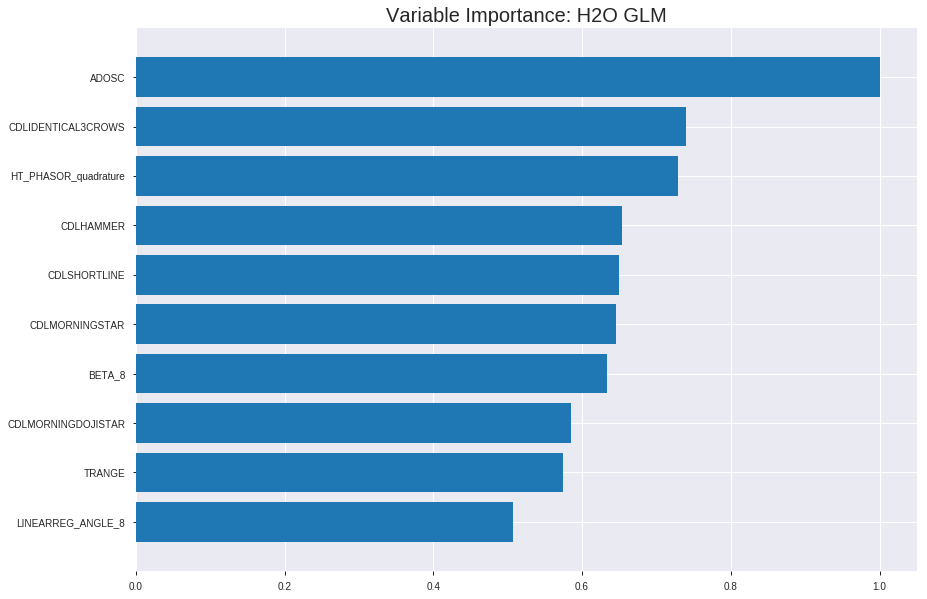

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_194346_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24757986223945685
RMSE: 0.4975739766501629
LogLoss: 0.6882984857691121
Null degrees of freedom: 1558
Residual degrees of freedom: 1151
Null deviance: 2160.7652781666966
Residual deviance: 2146.1146786280915
AIC: 2962.1146786280915
AUC: 0.5683674712480944
pr_auc: 0.5574323534886008
Gini: 0.13673494249618878
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43266541178136464: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      4    789   0.995    (789.0/793.0)
1      0    766   0        (0.0/766.0)
Total  4    1555  0.5061   (789.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.432665     0.66006   395
max f2                       0.432665     0.829184  395
max f0point5                 0.463063     0.556999  319
max accuracy                 0.512009     0.557409  111
max precision                0.572321     1         0
max recall                   0.432665     1         395
max specificity              0.572321     1         0
max absolute_mcc             0.512009     0.126581  111
max min_per_class_accuracy   0.490732     0.539723  202
max mean_per_class_accuracy  0.494335     0.553279  186

Gains/Lift Table: Avg response rate: 49.13 %, avg score: 49.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.551358           1.14483   1.14483            0.5625           0.559968  0.5625                      0.559968            0.0117493       0.0117493                  14.4827   14.4827
    2        0.020526                    0.544043           1.14483   1.14483            0.5625           0.548047  0.5625                      0.554008            0.0117493       0.0234987                  14.4827   14.4827
    3        0.0301475                   0.537691           1.49252   1.25579            0.733333         0.540495  0.617021                    0.549695            0.0143603       0.037859                   49.2515   25.5791
    4        0.0404105                   0.533467           1.52644   1.32453            0.75             0.53499   0.650794                    0.54596             0.0156658       0.0535248                  52.6436   32.4527
    5        0.0500321                   0.530806           1.35683   1.33074            0.666667         0.532146  0.653846                    0.543304            0.0130548       0.0665796                  35.6832   33.0739
    6        0.100064                    0.522155           1.35683   1.34379            0.666667         0.525615  0.660256                    0.534459            0.0678851       0.134465                   35.6832   34.3786
    7        0.150096                    0.517556           1.06981   1.25246            0.525641         0.51979   0.615385                    0.529569            0.0535248       0.18799                    6.98099   25.246
    8        0.200128                    0.513683           1.14809   1.22637            0.564103         0.515607  0.602564                    0.526079            0.0574413       0.245431                   14.8089   22.6367
    9        0.300192                    0.506059           0.952392  1.13504            0.467949         0.509719  0.557692                    0.520626            0.0953003       0.340731                   -4.76083  13.5042
    10       0.400257                    0.497476           1.01762   1.10569            0.5              0.501657  0.543269                    0.515883            0.101828        0.442559                   1.7624    10.5688
    11       0.500321                    0.490714           0.991531  1.08286            0.487179         0.494031  0.532051                    0.511513            0.0992167       0.541775                   -0.84689  8.28563
    12       0.599743                    0.484339           0.984797  1.0666             0.483871         0.487487  0.524064                    0.50753             0.0979112       0.639687                   -1.52026  6.66006
    13       0.699808                    0.477366           1.00458   1.05773            0.49359          0.480908  0.519707                    0.503723            0.100522        0.740209                   0.457756  5.7732
    14       0.799872                    0.469439           0.926299  1.04129            0.455128         0.473399  0.511628                    0.49993             0.0926893       0.832898                   -7.37012  4.12897
    15       0.899936                    0.458686           0.874113  1.0227             0.429487         0.464455  0.502495                    0.495985            0.0874674       0.920366                   -12.5887  2.27013
    16       1                           0.427857           0.795834  1                  0.391026         0.449568  0.491341                    0.491341           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2502558605711099
RMSE: 0.5002557951399562
LogLoss: 0.6936612211181298
Null degrees of freedom: 445
Residual degrees of freedom: 38
Null deviance: 618.4903607498804
Residual deviance: 618.7458092373718
AIC: 1434.7458092373718
AUC: 0.4995374839124839
pr_auc: 0.5244943050372167
Gini: -0.0009250321750321477
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4386621302418873: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    221  0.9955   (221.0/222.0)
1      0    224  0        (0.0/224.0)
Total  1    445  0.4955   (221.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.438662     0.669656  398
max f2                       0.438662     0.835198  398
max f0point5                 0.438662     0.558882  398
max accuracy                 0.511043     0.53139   42
max precision                0.539585     1         0
max recall                   0.438662     1         398
max specificity              0.539585     1         0
max absolute_mcc             0.511043     0.107998  42
max min_per_class_accuracy   0.487833     0.495536  200
max mean_per_class_accuracy  0.511043     0.53316   42

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 48.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.526482           1.19464   1.19464            0.6              0.531747  0.6                         0.531747            0.0133929       0.0133929                  19.4643    19.4643
    2        0.0201794                   0.52407            1.99107   1.54861            1                0.525103  0.777778                    0.528794            0.0178571       0.03125                    99.1071    54.8611
    3        0.0313901                   0.520734           1.19464   1.42219            0.6              0.521941  0.714286                    0.526346            0.0133929       0.0446429                  19.4643    42.2194
    4        0.0403587                   0.518159           0.995536  1.32738            0.5              0.519607  0.666667                    0.524849            0.00892857      0.0535714                  -0.446429  32.7381
    5        0.0515695                   0.5163             0.796429  1.21196            0.4              0.517309  0.608696                    0.52321             0.00892857      0.0625                     -20.3571   21.1957
    6        0.100897                    0.511075           1.35755   1.28313            0.681818         0.513121  0.644444                    0.518278            0.0669643       0.129464                   35.7549    28.3135
    7        0.150224                    0.505574           0.724026  1.09955            0.363636         0.508453  0.552239                    0.515052            0.0357143       0.165179                   -27.5974   9.95469
    8        0.201794                    0.502695           1.12539   1.10615            0.565217         0.504057  0.555556                    0.512242            0.0580357       0.223214                   12.5388    10.6151
    9        0.300448                    0.497135           0.724026  0.980677           0.363636         0.499829  0.492537                    0.508166            0.0714286       0.294643                   -27.5974   -1.9323
    10       0.401345                    0.491378           1.19464   1.03447            0.6              0.49437   0.519553                    0.504698            0.120536        0.415179                   19.4643    3.44673
    11       0.5                         0.487733           0.814529  0.991071           0.409091         0.489266  0.497758                    0.501653            0.0803571       0.495536                   -18.5471   -0.892857
    12       0.600897                    0.483142           0.929167  0.980677           0.466667         0.48565   0.492537                    0.498966            0.09375         0.589286                   -7.08333   -1.9323
    13       0.699552                    0.479061           0.995536  0.982772           0.5              0.481084  0.49359                     0.496444            0.0982143       0.6875                     -0.446429  -1.72276
    14       0.800448                    0.472278           0.973413  0.981593           0.488889         0.475947  0.492997                    0.49386             0.0982143       0.785714                   -2.65873   -1.84074
    15       0.899103                    0.466735           1.04079   0.988088           0.522727         0.469524  0.496259                    0.49119             0.102679        0.888393                   4.07873    -1.19122
    16       1                           0.436081           1.10615   1                  0.555556         0.460042  0.502242               


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 19:43:47  0.000 sec   2            3.8       408           1.3766            1.38732
    2019-08-27 19:43:47  0.352 sec   4            2.7       408           1.37464           1.38782
    2019-08-27 19:43:47  0.714 sec   6            2         408           1.3723            1.38853
    2019-08-27 19:43:48  1.071 sec   8            1.5       408           1.36951           1.38944
    2019-08-27 19:43:48  1.420 sec   10           1.1       408           1.36622           1.3906

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.600896860986547)

('F1', 0.6158730158730159)

('auc', 0.5452244897959183)

('logloss', 0.6909219311623458)

('mean_per_class_error', 0.4349387755102041)

('rmse', 0.4988882380005242)

('mse', 0.24888947401526768)

glm prediction progress: |████████████████████████████████████████████████| 100%


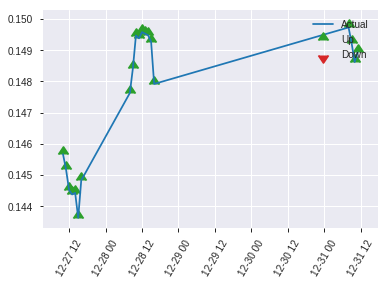


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24888947401526768
RMSE: 0.4988882380005242
LogLoss: 0.6909219311623458
Null degrees of freedom: 222
Residual degrees of freedom: -185
Null deviance: 308.275230921901
Residual deviance: 308.15118129840624
AIC: 1124.1511812984063
AUC: 0.5452244897959183
pr_auc: 0.5115979786183166
Gini: 0.09044897959183662
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46347651047004906: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    120  0.96     (120.0/125.0)
1      1    97   0.0102   (1.0/98.0)
Total  6    217  0.5426   (121.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.463477     0.615873  216
max f2                       0.447351     0.796748  222
max f0point5                 0.500947     0.50738   110
max accuracy                 0.525174     0.600897  30
max precision                0.544008     1         0
max recall                   0.447351     1         222
max specificity              0.544008     1         0
max absolute_mcc             0.525174     0.166533  30
max min_per_class_accuracy   0.500947     0.552     110
max mean_per_class_accuracy  0.515773     0.565061  51

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 50.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.537479           1.51701   1.51701            0.666667         0.541713  0.666667                    0.541713            0.0204082       0.0204082                  51.7007   51.7007
    2        0.0224215                   0.535271           2.27551   1.82041            1                0.536425  0.8                         0.539598            0.0204082       0.0408163                  127.551   82.0408
    3        0.0313901                   0.534235           2.27551   1.95044            1                0.534715  0.857143                    0.538203            0.0204082       0.0612245                  127.551   95.0437
    4        0.0403587                   0.532519           1.13776   1.76984            0.5              0.533312  0.777778                    0.537116            0.0102041       0.0714286                  13.7755   76.9841
    5        0.0538117                   0.531304           1.51701   1.70663            0.666667         0.531993  0.75                        0.535835            0.0204082       0.0918367                  51.7007   70.6633
    6        0.103139                    0.526195           0.827458  1.28616            0.363636         0.527705  0.565217                    0.531947            0.0408163       0.132653                   -17.2542  28.6158
    7        0.152466                    0.521286           1.44805   1.33854            0.636364         0.524941  0.588235                    0.52968             0.0714286       0.204082                   44.8052   33.8535
    8        0.201794                    0.517568           1.03432   1.26417            0.454545         0.519284  0.555556                    0.527139            0.0510204       0.255102                   3.43228   26.4172
    9        0.300448                    0.512499           0.930891  1.15474            0.409091         0.514918  0.507463                    0.523126            0.0918367       0.346939                   -6.91095  15.4737
    10       0.399103                    0.506886           0.827458  1.07384            0.363636         0.509617  0.47191                     0.519787            0.0816327       0.428571                   -17.2542  7.38363
    11       0.502242                    0.500798           1.28616   1.11744            0.565217         0.504078  0.491071                    0.516561            0.132653        0.561224                   28.6158   11.7438
    12       0.600897                    0.495243           0.620594  1.03587            0.272727         0.497849  0.455224                    0.513489            0.0612245       0.622449                   -37.9406  3.58666
    13       0.699552                    0.491045           0.827458  1.00648            0.363636         0.493063  0.442308                    0.510608            0.0816327       0.704082                   -17.2542  0.647567
    14       0.798206                    0.484422           0.827458  0.98435            0.363636         0.489032  0.432584                    0.507941            0.0816327       0.785714                   -17.2542  -1.56501
    15       0.896861                    0.473561           1.13776   1.00122            0.5              0.479755  0.44                        0.504841            0.112245        0.897959                   13.7755   0.122449
    16       1                           0.447351           0.989352  1                  0.434783         0.465274  0.439462                    0.50076       

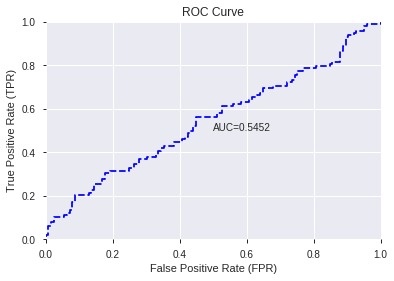

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


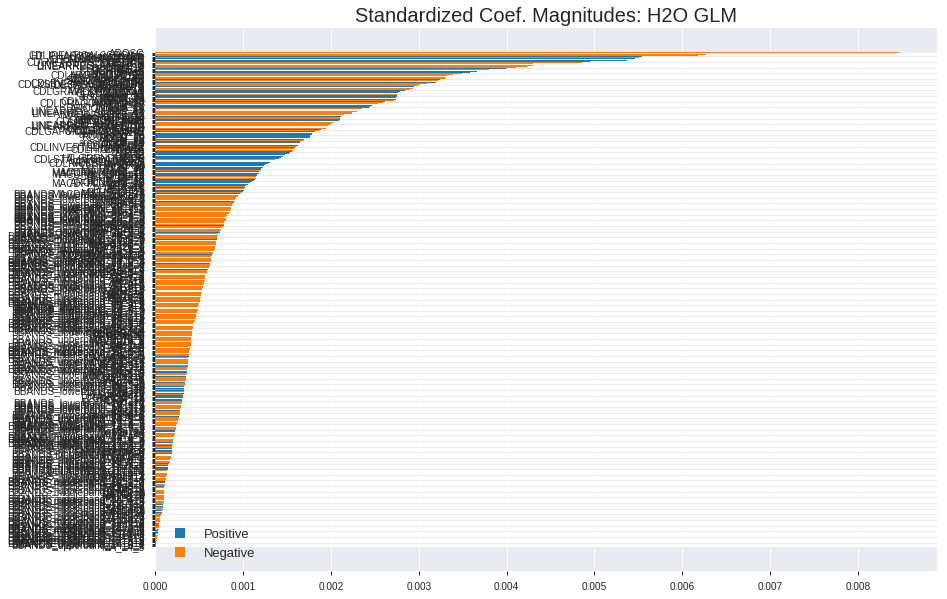

'log_likelihood'
--2019-08-27 19:44:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.128.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.128.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_194346_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_194346_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_85f7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['ADOSC',
 'CDLIDENTICAL3CROWS',
 'HT_PHASOR_quadrature',
 'CDLHAMMER',
 'CDLSHORTLINE',
 'CDLMORNINGSTAR',
 'BETA_8',
 'CDLMORNINGDOJISTAR',
 'TRANGE',
 'LINEARREG_ANGLE_8',
 'LINEARREG_SLOPE_8',
 'aroonup_12',
 'CDL3INSIDE',
 'CORREL_8',
 'STOCH_slowd',
 'VAR_8',
 'aroonup_30',
 'AROONOSC_12',
 'CDLHARAMICROSS',
 'ULTOSC',
 'CDLTASUKIGAP',
 'STOCHRSI_fastd',
 'AROONOSC_30',
 'WILLR_12',
 'CDLEVENINGDOJISTAR',
 'CDLXSIDEGAP3METHODS',
 'CDL3BLACKCROWS',
 'aroonup_8',
 'STDDEV_8',
 'WILLR_14',
 'MACDFIX_hist_8',
 'CDLGRAVESTONEDOJI',
 'STDDEV_12',
 'CDLDOJISTAR',
 'aroondown_20',
 'MOM_24',
 'ROCR_24',
 'ROCP_24',
 'ROC_24',
 'CDL3LINESTRIKE',
 'aroonup_24',
 'CDLDRAGONFLYDOJI',
 'WILLR_20',
 'BETA_12',
 'AROONOSC_24',
 'VAR_12',
 'MFI_12',
 'LINEARREG_ANGLE_12',
 'LINEARREG_SLOPE_12',
 'AD',
 'MACDFIX_hist_12',
 'aroondown_30',
 'BETA_14',
 'STOCH_slowk',
 'STOCHF_fastd',
 'CDL3OUTSIDE',
 'CDLHANGINGMAN',
 'CDLENGULFING',
 'LINEARREG_ANGLE_14',
 'LINEARREG_SLOPE_14',
 'WILLR_8',
 'HT_D

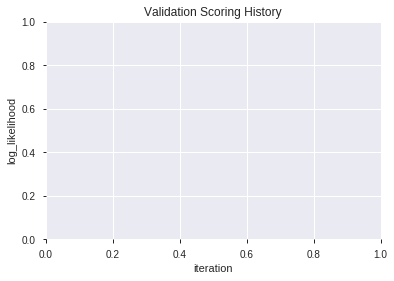

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_194408_model_1  0.521306  0.703436              0.478204  0.505032  0.255058
1  XGBoost_grid_1_AutoML_20190827_194408_model_5  0.521143  0.733230              0.500000  0.516468  0.266740
2  XGBoost_grid_1_AutoML_20190827_194408_model_2  0.516653  0.707690              0.500000  0.506836  0.256883
3  XGBoost_grid_1_AutoML_20190827_194408_model_4  0.512327  0.703023              0.482204  0.504785  0.254808
4               XGBoost_2_AutoML_20190827_194408  0.495184  0.710363              0.500000  0.508137  0.258203
5  XGBoost_grid_1_AutoML_20190827_194408_model_7  0.494286  0.727781              0.463714  0.515627  0.265871
6  XGBoost_grid_1_AutoML_20190827_194408_model_6  0.494122  0.722983              0.500000  0.513902  0.264096
7               XGBoost_1_AutoML_20190827_194408  0.493020  0.728584              0.500000  0.516114  0.266374
8               XGBoost_3_AutoML_20190827_194408  0.492490  0.717193              0.496000  0.511238  0.261364
9  XGBoost_grid_1_AutoML_20190827_194408_model_3  0.486449  0.714946              0.500000  0.510438  0.260547

variable  relative_importance  scaled_importance  percentage
0                     MFI_12           103.481575           1.000000    0.024359
1                      ADOSC           102.065628           0.986317    0.024026
2                MINUS_DM_20            98.494034           0.951803    0.023185
3       HT_PHASOR_quadrature            95.768356           0.925463    0.022544
4                        BOP            91.520576           0.884414    0.021544
..                       ...                  ...                ...         ...
170                   ROC_30             4.417713           0.042691    0.001040
171             HT_TRENDMODE             4.329059           0.041834    0.001019
172        MACDFIX_signal_24             3.315466           0.032039    0.000780
173              MINUS_DI_20             3.112540           0.030078    0.000733
174  BBANDS_lowerband_14_7_3             2.872505           0.027759    0.000676

[175 rows x 4 columns]

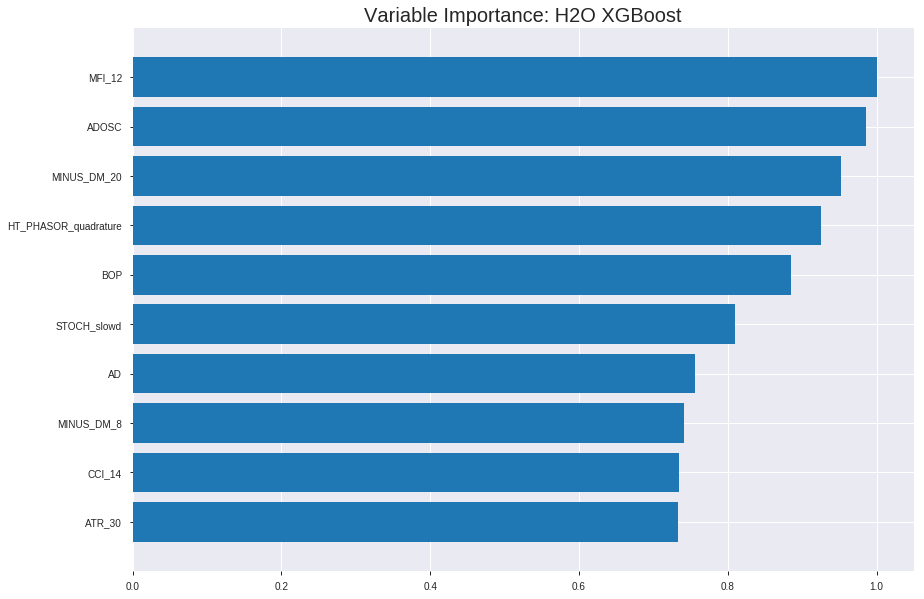

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_194408_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1854603851297456
RMSE: 0.4306511176459961
LogLoss: 0.5603699243277056
Mean Per-Class Error: 0.1358698336291111
AUC: 0.9350032431293399
pr_auc: 0.9321969257826795
Gini: 0.8700064862586798
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47612902025381726: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      652  141  0.1778   (141.0/793.0)
1      75   691  0.0979   (75.0/766.0)
Total  727  832  0.1386   (216.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476129     0.864831  225
max f2                       0.443518     0.905647  261
max f0point5                 0.505895     0.874497  194
max accuracy                 0.486651     0.864015  215
max precision                0.791859     1         0
max recall                   0.364574     1         335
max specificity              0.791859     1         0
max absolute_mcc             0.486651     0.728151  215
max min_per_class_accuracy   0.487993     0.861286  214
max mean_per_class_accuracy  0.486651     0.86413   215

Gains/Lift Table: Avg response rate: 49.13 %, avg score: 49.20 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.740543           2.03525    2.03525            1                0.762039  1                           0.762039            0.0208877       0.0208877                  103.525   103.525
    2        0.020526                    0.714225           2.03525    2.03525            1                0.72688   1                           0.744459            0.0208877       0.0417755                  103.525   103.525
    3        0.0301475                   0.69604            2.03525    2.03525            1                0.707667  1                           0.732717            0.0195822       0.0613577                  103.525   103.525
    4        0.0404105                   0.68851            2.03525    2.03525            1                0.692674  1                           0.722548            0.0208877       0.0822454                  103.525   103.525
    5        0.0500321                   0.678385           2.03525    2.03525            1                0.682448  1                           0.714836            0.0195822       0.101828                   103.525   103.525
    6        0.100064                    0.635643           2.03525    2.03525            1                0.654198  1                           0.684517            0.101828        0.203655                   103.525   103.525
    7        0.150096                    0.608133           2.03525    2.03525            1                0.62111   1                           0.663381            0.101828        0.305483                   103.525   103.525
    8        0.200128                    0.583211           1.8526     1.98959            0.910256         0.596601  0.977564                    0.646686            0.0926893       0.398172                   85.2598   98.9585
    9        0.300192                    0.542996           1.80041    1.92653            0.884615         0.562383  0.946581                    0.618585            0.180157        0.578329                   80.0412   92.6528
    10       0.400257                    0.51478            1.59167    1.84281            0.782051         0.527422  0.905449                    0.595794            0.159269        0.737598                   59.1668   84.2813
    11       0.500321                    0.486069           1.33074    1.7404             0.653846         0.500743  0.855128                    0.576784            0.133159        0.870757                   33.0739   74.0398
    12       0.599743                    0.460224           0.682793   1.56507            0.335484         0.472174  0.768984                    0.559442            0.0678851       0.938642                   -31.7207  56.5073
    13       0.699808                    0.430855           0.339208   1.38979            0.166667         0.446267  0.68286                     0.54326             0.0339426       0.972585                   -66.0792  38.9789
    14       0.799872                    0.402852           0.195697   1.24041            0.0961538        0.416971  0.609463                    0.527461            0.0195822       0.992167                   -80.4303  24.0408
    15       0.899936                    0.359138           0.0782788  1.11119            0.0384615        0.383582  0.545973                    0.511463            0.0078329       1                          -92.1721  11.119
    16       1                           0.210994           0          1                  0                0.316785  0.491341                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25156315825549347
RMSE: 0.5015607224010802
LogLoss: 0.6962320269042515
Mean Per-Class Error: 0.4688907657657657
AUC: 0.5235883204633205
pr_auc: 0.524619284609211
Gini: 0.04717664092664098
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3373463749885559: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    216  0.973    (216.0/222.0)
1      2    222  0.0089   (2.0/224.0)
Total  8    438  0.4888   (218.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.337346     0.670695   391
max f2                       0.291548     0.835821   397
max f0point5                 0.380819     0.566737   370
max accuracy                 0.483667     0.53139    222
max precision                0.792522     1          0
max recall                   0.291548     1          397
max specificity              0.792522     1          0
max absolute_mcc             0.380819     0.0907195  370
max min_per_class_accuracy   0.494456     0.517857   198
max mean_per_class_accuracy  0.483667     0.531109   222

Gains/Lift Table: Avg response rate: 50.22 %, avg score: 49.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.69113            1.59286   1.59286            0.8              0.725912  0.8                         0.725912            0.0178571       0.0178571                  59.2857    59.2857
    2        0.0201794                   0.663701           0.995536  1.32738            0.5              0.674006  0.666667                    0.702843            0.00892857      0.0267857                  -0.446429  32.7381
    3        0.0313901                   0.64148            1.19464   1.27997            0.6              0.65216   0.642857                    0.684742            0.0133929       0.0401786                  19.4643    27.9974
    4        0.0403587                   0.622353           0.995536  1.21677            0.5              0.632242  0.611111                    0.673075            0.00892857      0.0491071                  -0.446429  21.6766
    5        0.0515695                   0.611631           1.19464   1.21196            0.6              0.617708  0.608696                    0.661039            0.0133929       0.0625                     19.4643    21.1957
    6        0.100897                    0.585807           0.633523  0.929167           0.318182         0.597109  0.466667                    0.629784            0.03125         0.09375                    -36.6477   -7.08333
    7        0.150224                    0.563676           1.17654   1.01039            0.590909         0.57338   0.507463                    0.611263            0.0580357       0.151786                   17.6542    1.03945
    8        0.201794                    0.543678           1.12539   1.03978            0.565217         0.553235  0.522222                    0.596434            0.0580357       0.209821                   12.5388    3.97817
    9        0.300448                    0.523729           1.08604   1.05497            0.545455         0.532767  0.529851                    0.575528            0.107143        0.316964                   8.6039     5.49707
    10       0.401345                    0.506398           1.10615   1.06784            0.555556         0.514096  0.536313                    0.560084            0.111607        0.428571                   10.6151    6.78372
    11       0.5                         0.494294           0.905032  1.03571            0.454545         0.499639  0.520179                    0.548158            0.0892857       0.517857                   -9.49675   3.57143
    12       0.600897                    0.476096           1.01766   1.03268            0.511111         0.485055  0.518657                    0.537562            0.102679        0.620536                   1.76587    3.26826
    13       0.699552                    0.458897           0.859781  1.0083             0.431818         0.469335  0.50641                     0.527941            0.0848214       0.705357                   -14.0219   0.829899
    14       0.800448                    0.435882           0.973413  1.0039             0.488889         0.448529  0.504202                    0.517931            0.0982143       0.803571                   -2.65873   0.390156
    15       0.899103                    0.401834           1.08604   1.01291            0.545455         0.419083  0.508728                    0.507085            0.107143        0.910714                   8.6039     1.29141
    16       1                           0.21285            0.884921  1                  0.444444         0.362396  0.502242                 


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 19:44:16  0.023 sec   0                  0.5              0.693147            0.5             0                  1                0.508659                         0.5                0.693147              0.5               0                    1                  0.497758
    2019-08-27 19:44:16  0.480 sec   5                  0.490427         0.674113            0.728502        0.726591           2.03525          0.375241                         0.499333           0.691804              0.501498          0.510715             1.65923            0.497758
    2019-08-27 19:44:17  0.571 sec   10                 0.482166         0.657913            0.79514         0.790714           2.03525          0.313663                         0.498747           0.690618              0.52394           0.530355             1.65923            0.493274
    2019-08-27 19:44:17  0.661 sec   15                 0.474482         0.642996            0.838247        0.835509           2.03525          0.257216                         0.499174           0.691459              0.521738          0.522538             1.59286            0.488789
    2019-08-27 19:44:17  0.755 sec   20                 0.46778          0.630072            0.859685        0.852473           2.03525          0.23669                          0.499036           0.691146              0.529028          0.523713             1.59286            0.484305
    2019-08-27 19:44:17  0.854 sec   25                 0.461373         0.617847            0.875728        0.87103            2.03525          0.215523                         0.499608           0.692303              0.526203          0.528009             1.59286            0.488789
    2019-08-27 19:44:17  0.952 sec   30                 0.455761         0.607177            0.885836        0.881625           2.03525          0.198204                         0.500516           0.694085              0.515947          0.519064             1.59286            0.484305
    2019-08-27 19:44:17  1.056 sec   35                 0.449402         0.595233            0.901374        0.898026           2.03525          0.183451                         0.501243           0.695603              0.517535          0.5162               1.19464            0.486547
    2019-08-27 19:44:17  1.153 sec   40                 0.444524         0.586005            0.910288        0.906207           2.03525          0.175754                         0.502113           0.697381              0.513554          0.512852             1.19464            0.486547
    2019-08-27 19:44:17  1.259 sec   45                 0.437856         0.573608            0.923125        0.919164           2.03525          0.152021                         0.502037           0.697221              0.51835           0.519069             1.59286            0.488789
    2019-08-27 19:44:17  1.368 sec   50                 0.430651         0.56037             0.935003        0.932197           2.03525          0.13855                          0.501561           0.696232              0.523588          0.524619             1.59286            0.488789

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
MFI_12                   103.48157501220703     1.0                   0.024359462832907332
ADOSC                    102.06562805175781     0.9863169171876038    0.024026150285699176
MINUS_DM_20              98.49403381347656      0.9518026160875294    0.02318540045084814
HT_PHASOR_quadrature     95.76835632324219      0.9254628788936101    0.022543778601644315
BOP                      91.52057647705078      0.8844142202730748    0.021543855327636686
---                      ---                    ---                   ---
ROC_30                   4.417713165283203      0.042690818773893566  0.001039925413229043
HT_TRENDMODE             4.329058647155762      0.04183410086911696   0.0010190562252693509
MACDFIX_signal_24        3.3154664039611816     0.032039195417832386  0.0007804575899769429
MINUS_DI_20              3.112539768218994      0.03007820249983467   0.000732688855875383
BBANDS_lowerband_14_7_3  2.8725051879882812     0.0277586148804696    0.0006761849474737876


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5829596412556054)

('F1', 0.6173633440514469)

('auc', 0.5213061224489797)

('logloss', 0.7034356428985382)

('mean_per_class_error', 0.4634285714285714)

('rmse', 0.5050324414095696)

('mse', 0.2550577668761103)

xgboost prediction progress: |████████████████████████████████████████████| 100%


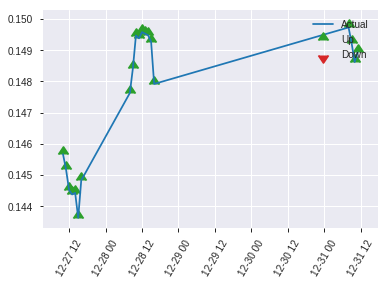


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2550577668761103
RMSE: 0.5050324414095696
LogLoss: 0.7034356428985382
Mean Per-Class Error: 0.4634285714285714
AUC: 0.5213061224489797
pr_auc: 0.4815210951851781
Gini: 0.04261224489795934
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3697172701358795: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    117  0.936    (117.0/125.0)
1      2    96   0.0204   (2.0/98.0)
Total  10   213  0.5336   (119.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.369717     0.617363  212
max f2                       0.313708     0.799347  220
max f0point5                 0.446544     0.508475  181
max accuracy                 0.687692     0.58296   4
max precision                0.710579     1         0
max recall                   0.313708     1         220
max specificity              0.710579     1         0
max absolute_mcc             0.687692     0.17104   4
max min_per_class_accuracy   0.521588     0.489796  108
max mean_per_class_accuracy  0.446544     0.536571  181

Gains/Lift Table: Avg response rate: 43.95 %, avg score: 51.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.696965           2.27551   2.27551            1                0.702407  1                           0.702407            0.0306122       0.0306122                  127.551   127.551
    2        0.0224215                   0.686516           2.27551   2.27551            1                0.69229   1                           0.69836             0.0204082       0.0510204                  127.551   127.551
    3        0.0313901                   0.681852           1.13776   1.95044            0.5              0.684628  0.857143                    0.694437            0.0102041       0.0612245                  13.7755   95.0437
    4        0.0403587                   0.675801           0         1.51701            0                0.67894   0.666667                    0.690993            0               0.0612245                  -100      51.7007
    5        0.0538117                   0.671869           1.51701   1.51701            0.666667         0.673942  0.666667                    0.68673             0.0204082       0.0816327                  51.7007   51.7007
    6        0.103139                    0.640312           0.827458  1.18722            0.363636         0.651162  0.521739                    0.669719            0.0408163       0.122449                   -17.2542  18.7223
    7        0.152466                    0.61154            1.24119   1.20468            0.545455         0.623887  0.529412                    0.654891            0.0612245       0.183673                   24.1187   20.4682
    8        0.201794                    0.588502           0.827458  1.11247            0.363636         0.600422  0.488889                    0.641577            0.0408163       0.22449                    -17.2542  11.2472
    9        0.300448                    0.564665           0.620594  0.950959           0.272727         0.575037  0.41791                     0.619728            0.0612245       0.285714                   -37.9406  -4.90405
    10       0.399103                    0.535643           1.24119   1.0227             0.545455         0.54984   0.449438                    0.602452            0.122449        0.408163                   24.1187   2.27012
    11       0.502242                    0.519999           0.791482  0.975219           0.347826         0.528214  0.428571                    0.587207            0.0816327       0.489796                   -20.8518  -2.47813
    12       0.600897                    0.501274           1.34462   1.03587            0.590909         0.511249  0.455224                    0.574736            0.132653        0.622449                   34.462    3.58666
    13       0.699552                    0.473414           0.827458  1.00648            0.363636         0.486805  0.442308                    0.562336            0.0816327       0.704082                   -17.2542  0.647567
    14       0.798206                    0.451379           1.13776   1.0227             0.5              0.462728  0.449438                    0.550025            0.112245        0.816327                   13.7755   2.27012
    15       0.896861                    0.412528           1.03432   1.02398            0.454545         0.432134  0.45                        0.537057            0.102041        0.918367                   3.43228   2.39796
    16       1                           0.306165           0.791482  1                  0.347826         0.368252  0.439462                    0.519646      

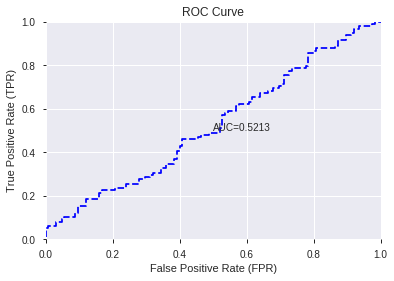

This function is available for GLM models only


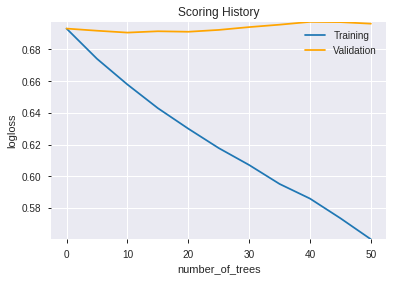

--2019-08-27 19:44:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.81.144
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.81.144|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_194408_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_194408_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_85f7',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['MFI_12',
 'ADOSC',
 'MINUS_DM_20',
 'HT_PHASOR_quadrature',
 'BOP',
 'STOCH_slowd',
 'AD',
 'MINUS_DM_8',
 'CCI_14',
 'ATR_30',
 'OBV',
 'MOM_14',
 'BETA_8',
 'MINUS_DM_12',
 'LINEARREG_ANGLE_8',
 'TRANGE',
 'HT_PHASOR_inphase',
 'ROC_14',
 'AROONOSC_20',
 'aroondown_8',
 'CCI_12',
 'MFI_8',
 'STOCHRSI_fastd',
 'ADX_12',
 'aroonup_24',
 'WILLR_8',
 'MOM_8',
 'AROONOSC_30',
 'aroondown_30',
 'PLUS_DM_20',
 'STDDEV_8',
 'MINUS_DI_12',
 'CCI_30',
 'BBANDS_lowerband_20_0_5',
 'LINEARREG_ANGLE_12',
 'STDDEV_12',
 'BETA_12',
 'CDLBELTHOLD',
 'TRIX_14',
 'PLUS_DM_30',
 'WILLR_12',
 'RSI_8',
 'HT_DCPERIOD',
 'DX_14',
 'PLUS_DI_20',
 'STOCH_slowk',
 'MOM_20',
 'aroonup_8',
 'STOCHRSI_fastk',
 'MINUS_DM_24',
 'NATR_8',
 'MOM_24',
 'BBANDS_upperband_30_5_5',
 'MACDFIX_hist_12',
 'MACDFIX_hist_14',
 'aroondown_20',
 'MINUS_DI_14',
 'aroonup_20',
 'APO',
 'ULTOSC',
 'BBANDS_lowerband_30_6_4',
 'MFI_14',
 'NATR_12',
 'LINEARREG_SLOPE_8',
 'ROCP_20',
 'PLUS_DI_24',
 'CORREL_14',
 'ADX_20',
 'MFI_24

In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.605
GLM             0.601
XGBoost         0.605
dtype: float64

DeepLearning    GLM  XGBoost
All          0.605  0.596    0.587
DLF          0.561  0.570    0.605
Fwe          0.592  0.596    0.587
RFE          0.578  0.601    0.583
XGBF         0.583  0.570    0.605





F1


DeepLearning    0.627
GLM             0.618
XGBoost         0.617
dtype: float64

DeepLearning    GLM  XGBoost
All          0.613  0.618    0.611
DLF          0.620  0.611    0.611
Fwe          0.618  0.618    0.611
RFE          0.627  0.616    0.617
XGBF         0.615  0.611    0.611





auc


DeepLearning    0.572
GLM             0.545
XGBoost         0.544
dtype: float64

DeepLearning    GLM  XGBoost
All          0.571  0.541    0.544
DLF          0.557  0.515    0.540
Fwe          0.543  0.541    0.544
RFE          0.572  0.545    0.521
XGBF         0.553  0.515    0.540





logloss


DeepLearning    1.293
GLM             0.694
XGBoost         0.709
dtype: float64

DeepLearning    GLM  XGBoost
All          0.693  0.692    0.709
DLF          0.691  0.694    0.705
Fwe          0.690  0.692    0.709
RFE          1.293  0.691    0.703
XGBF         0.746  0.694    0.705





mean_per_class_error


DeepLearning    0.441
GLM             0.457
XGBoost         0.463
dtype: float64

DeepLearning    GLM  XGBoost
All          0.422  0.447    0.436
DLF          0.437  0.457    0.419
Fwe          0.436  0.447    0.436
RFE          0.422  0.435    0.463
XGBF         0.441  0.457    0.419





rmse


DeepLearning    0.591
GLM             0.500
XGBoost         0.508
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.500    0.508
DLF          0.499  0.500    0.506
Fwe          0.498  0.500    0.508
RFE          0.591  0.499    0.505
XGBF         0.516  0.500    0.506





mse


DeepLearning    0.349
GLM             0.250
XGBoost         0.258
dtype: float64

DeepLearning    GLM  XGBoost
All          0.250  0.250    0.258
DLF          0.249  0.250    0.256
Fwe          0.248  0.250    0.258
RFE          0.349  0.249    0.255
XGBF         0.266  0.250    0.256

{'F1':       DeepLearning    GLM  XGBoost
 All          0.613    NaN      NaN
 DLF          0.620    NaN      NaN
 DLF            NaN  0.611      NaN
 DLF            NaN    NaN    0.611
 All            NaN  0.618      NaN
 All            NaN    NaN    0.611
 XGBF         0.615    NaN      NaN
 XGBF           NaN  0.611      NaN
 XGBF           NaN    NaN    0.611
 Fwe          0.618    NaN      NaN
 Fwe            NaN  0.618      NaN
 Fwe            NaN    NaN    0.611
 RFE          0.627    NaN      NaN
 RFE            NaN  0.616      NaN
 RFE            NaN    NaN    0.617,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.605    NaN      NaN
 DLF          0.561    NaN      NaN
 DLF            NaN  0.570      NaN
 DLF            NaN    NaN    0.605
 All            NaN  0.596      NaN
 All            NaN    NaN    0.587
 XGBF         0.583    NaN      NaN
 XGBF           NaN  0.570      NaN
 XGBF           NaN    NaN    0.605
 Fwe          0.592    NaN      NaN
 Fwe     